<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/AUDUSD/AUDUSD_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AUDUSD"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 13:09:39,791 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 13:09:39,792 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AUDUSD
2019-08-24 13:13:25,263 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 13:21:44,515 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 13:25:54,864 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 13:29:58,255 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 13:34:12,014 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 13:38:24,785 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 13:42:46,266 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 13:46:51,866 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 14:00:11,766 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AUDUSD__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AUDUSD__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AUDUSD to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close       Volume
Date                                                                
2018-01-01 22:00:00  0.78043  0.78173  0.77910  0.78146  1436.320068
2018-01-01 23:00:00  0.78140  0.78143  0.77943  0.77987  5022.520020
2018-01-02 00:00:00  0.77987  0.78129  0.77987  0.78125  3243.840088
2018-01-02 01:00:00  0.78123  0.78268  0.78103  0.78188  5189.169922
2018-01-02 02:00:00  0.78184  0.78233  0.78179  0.78211  3486.640137
...                      ...      ...      ...      ...          ...
2018-12-31 17:00:00  0.70456  0.70474  0.70403  0.70425  4867.319824
2018-12-31 18:00:00  0.70425  0.70462  0.70396  0.70429  2684.649902
2018-12-31 19:00:00  0.70429  0.70471  0.70417  0.70449  2686.000000
2018-12-31 20:00:00  0.70449  0.70469  0.70422  0.70438  3155.590088
2018-12-31 21:00:00  0.70436  0.70565  0.70392  0.70409  1964.189941

[6216 rows x 5 columns]

Open         High          Low        Close        Volume
count  6216.000000  6216.000000  6216.000000  6216.000000   6216.000000
mean      0.747737     0.748331     0.747144     0.747723   4971.834473
std       0.028113     0.028148     0.028077     0.028115   2690.245850
min       0.701880     0.702370     0.701630     0.701870    148.460007
25%       0.723455     0.723957     0.722878     0.723430   3247.062622
50%       0.741770     0.742310     0.741225     0.741770   4683.764893
75%       0.771690     0.772223     0.771100     0.771650   6312.324951
max       0.813340     0.813550     0.811210     0.813340  76686.281250

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close       Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-01-04 00:00:00  0.78264  0.78280  0.78202  0.78233  3277.209961    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.783379  0.774701 -0.784333  0.782780  0.783076  0.783052    0.783200    0.783235  0.784151  0.783399  0.782431  0.783471  0.783064  0.783399  0.782547  0.783318                0.784800                 0.783399                0.781998                0.785500                 0.783399                0.781297                0.786201                 0.783399                0.780597                0.786902                 0.783399                0.779896  0.783076  0.782619  0.783381                0.784477                 0.783076                0.781675                0.785177                 0.783076                0.780974                0.785878                 0.783076                0.780274                0.786579                 0.783076   
2018-01-04 01:00:00  0.78233  0.78234  0.78140  0.78186  3634.310059    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.783303  0.774916 -0.784194  0.782366  0.782806  0.782522    0.782965    0.782925  0.783981  0.783123  0.781982  0.783137  0.782722  0.783123  0.782095  0.783302                0.784740                 0.783123                0.781505                0.785549                 0.783123                0.780696                0.786358                 0.783123                0.779887                0.787166                 0.783123                0.779079  0.782806  0.782063  0.783346                0.784423                 0.782806                0.781188                0.785232                 0.782806                0.780379                0.786041                 0.782806                0.779571                0.786849                 0.782806   
2018-01-04 02:00:00  0.78185  0.78319  0.781

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6166.000000  6166.000000  6166.000000  6166.000000   6166.000000  6166.000000  6166.000000  6166.000000    6166.000000  6166.000000   6166.000000     6166.000000     6166.000000       6166.000000  6166.000000  6166.000000  6166.000000  6166.000000   6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000  6166.000000             6166.000000              6166.000000             6166.000000             6166.000000              6166.000000             6166.000000             6166.000000              6166.000000             6166.000000             6166.000000              6166.000000             6166.000000  6166.000000  6166.000000  6166.000000             6166.000000              6166.000000             6166.000000             6166.000000              6166.000000             6166.000000             6166.000000   
mean      0.747453     0.748047     0.746859     0.747438   4984.766602    15.904314     2.049465   183.891502      30.440804    11.489296      0.034382        0.972429        0.004054          0.995135     6.549627     2.520435    26.649043     2.049465      2.027246    26.649043     0.747485     0.747556    -0.021803     0.747439     0.747484     0.747504     0.747473     0.747484     0.747531     0.747484     0.747439     0.747484     0.747469     0.747484     0.747450     0.747573                0.749073                 0.747484                0.745894                0.749868                 0.747484                0.745100                0.750663                 0.747484                0.744305                0.751457                 0.747484                0.743510     0.747484     0.747449     0.747559                0.749073                 0.747484                0.745894                0.749868                 0.747484                0.745100                0.750663   
std       0.028049     0.028085     0.028012     0.028050   2695.857178     8.726348     1.509092   104.071191       0.844225     6.925965      0.182223        0.163752        0.063551          0.069588     3.411547     1.113139    14.866808     1.509092      1.457226    14.866808     0.028028     0.027946     0.747783     0.028056     0.028022     0.028020     0.028018     0.028006     0.028013     0.028029     0.028054     0.028033     0.028034     0.028029     0.028044     0.027992                0.028133                 0.028029                0.027957                0.028196                 0.028029                0.027932                0.028267                 0.028029                0.027916                0.028346                 0.028029                0.027907     0.028022     0.028043     0.027997                0.028126                 0.028022                0.027950                0.028189                 0.028022                0.027925                0.028260   
min       0.701880     0.702370     0.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.724565  0.723422  0.733619  0.721808  0.040878    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.747636  0.673687  0.017998  0.733666  0.742310  0.748904    0.737644    0.738027  0.737325  0.742549  0.728432  0.743218  0.740635  0.742549  0.731027  0.749889                0.738390                 0.742549                0.745501                0.728365                 0.742549                0.750284                0.711176                 0.742549                0.754931                0.694867                 0.742549                0.756185  0.742310  0.729788  0.749611                0.733228                 0.742310                0.745201                0.727647                 0.742310                0.749047                0.714875                 0.742310                0.750250                0.698254                 0.742310   
2018-01-04 01:00:00  0.721783  0.719284  0.727962  0.717592  0.045544    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.746936  0.675719  0.018084  0.729909  0.739816  0.743938    0.735493    0.735189  0.735801  0.740016  0.724376  0.740160  0.737498  0.740016  0.726926  0.749739                0.737847                 0.740016                0.740996                0.728797                 0.740016                0.744868                0.712537                 0.740016                0.748630                0.697109                 0.740016                0.749056  0.739816  0.724755  0.749281                0.732740                 0.739816                0.740721                0.728137                 0.739816                0.743630                0.716308                 0.739816                0.743946                0.700578                 0.739816   
2018-01-04 02:00:00  0.717477  0.726929  

140216

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnsl6n9d_
  JVM stdout: /tmp/tmpnsl6n9d_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpnsl6n9d_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_pbkgha
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.518407  0.900791              0.496845  0.554768  0.307768
1  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.514921  0.696671              0.495358  0.501707  0.251710
2  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.513281  0.692539              0.495358  0.499505  0.249505
3  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.508333  0.745866              0.493691  0.522452  0.272956
4  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.506483  0.758371              0.500000  0.524744  0.275356
5              DeepLearning_1_AutoML_20190824_141529  0.500000  0.693034              0.500000  0.499944  0.249944
6  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.500000  0.694913              0.500000  0.500882  0.250882
7  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.500000  0.693428              0.500000  0.500140  0.250140
8  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.500000  0.695980              0.500000  0.501413  0.251415
9  DeepLearning_grid_1_AutoML_20190824_141529_mod...  0.500000  0.694901              0.500000  0.500876  0.250877

variable  relative_importance  scaled_importance  percentage
0              CDLSHOOTINGSTAR             1.000000           1.000000    0.003794
1            CDLINVERTEDHAMMER             0.986613           0.986613    0.003744
2                    CORREL_14             0.972950           0.972950    0.003692
3                    CORREL_12             0.959093           0.959093    0.003639
4               CDLMORNINGSTAR             0.951391           0.951391    0.003610
...                        ...                  ...                ...         ...
1035   BBANDS_upperband_24_1_3             0.210025           0.210025    0.000797
1036                   MA_12_6             0.209751           0.209751    0.000796
1037             MINMAX_max_14             0.207039           0.207039    0.000786
1038   BBANDS_upperband_14_5_2             0.206743           0.206743    0.000784
1039  BBANDS_middleband_24_3_2             0.205186           0.205186    0.000779

[1040 rows x 4 columns]

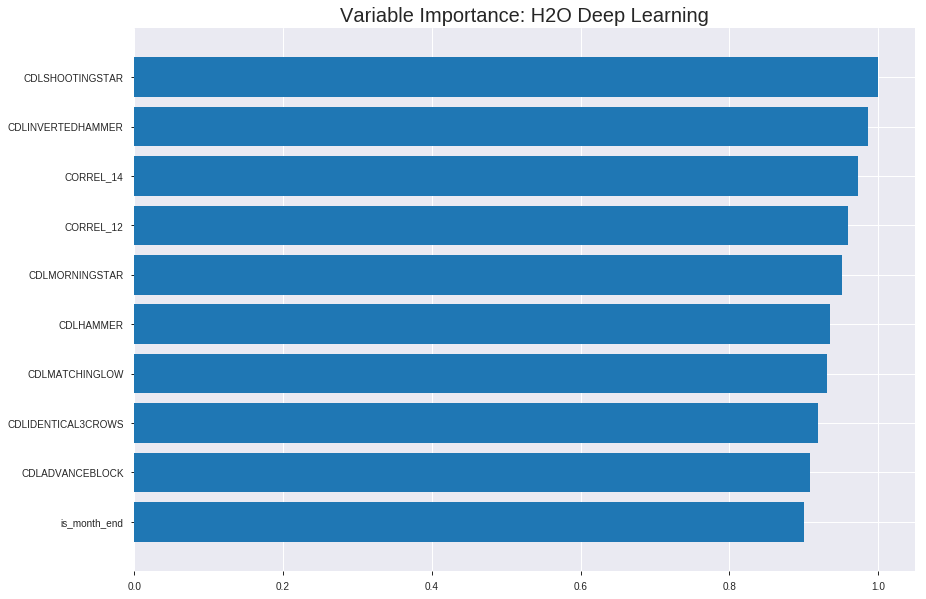

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_141529_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2958169228056164
RMSE: 0.5438905430374906
LogLoss: 0.9221399597418016
Mean Per-Class Error: 0.42326791917400175
AUC: 0.5984760688079781
pr_auc: 0.567486746153003
Gini: 0.1969521376159562
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23936348735780189: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      313  1866  0.8564   (1866.0/2179.0)
1      126  2010  0.059    (126.0/2136.0)
Total  439  3876  0.4616   (1992.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.239363     0.668663  332
max f2                       0.0197227    0.831516  395
max f0point5                 0.45797      0.583567  246
max accuracy                 0.599369     0.57613   182
max precision                0.9985       0.857143  0
max recall                   0.00058326   1         399
max specificity              0.9985       0.999082  0
max absolute_mcc             0.451788     0.166351  249
max min_per_class_accuracy   0.663345     0.571161  154
max mean_per_class_accuracy  0.599369     0.576732  182

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 63.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.995556           1.42327   1.42327            0.704545         0.9971    0.704545                    0.9971              0.0145131       0.0145131                  42.3274   42.3274
    2        0.0201622                   0.993371           1.08054   1.25387            0.534884         0.994527  0.62069                     0.995828            0.0107678       0.0252809                  8.05352   25.3874
    3        0.0301275                   0.990627           1.36241   1.28978            0.674419         0.991708  0.638462                    0.994465            0.0135768       0.0388577                  36.2414   28.9776
    4        0.0400927                   0.987407           1.26845   1.28448            0.627907         0.989049  0.635838                    0.993119            0.0126404       0.0514981                  26.8454   28.4476
    5        0.0500579                   0.985135           1.31543   1.29064            0.651163         0.986304  0.638889                    0.991763            0.0131086       0.0646067                  31.5434   29.0639
    6        0.100116                    0.971117           1.26258   1.27661            0.625            0.978377  0.631944                    0.98507             0.0632022       0.127809                   26.2582   27.6611
    7        0.150174                    0.950513           1.05683   1.20335            0.523148         0.961697  0.595679                    0.977279            0.0529026       0.180712                   5.68278   20.335
    8        0.2                         0.924706           1.08993   1.17509            0.539535         0.939574  0.581692                    0.967885            0.0543071       0.235019                   8.99312   17.5094
    9        0.300116                    0.85206            1.11294   1.15436            0.550926         0.891995  0.571429                    0.942569            0.111423        0.346442                   11.2943   15.4361
    10       0.4                         0.761037           1.12021   1.14583            0.554524         0.80725   0.567207                    0.908779            0.111891        0.458333                   12.0212   14.5833
    11       0.500116                    0.66092            1.141     1.14487            0.564815         0.711287  0.566728                    0.869244            0.114232        0.572566                   14.1      14.4866
    12       0.6                         0.563801           1.00303   1.12125            0.49652          0.608767  0.555041                    0.825881            0.100187        0.672753                   0.303492  12.1255
    13       0.699884                    0.458045           1.03584   1.10907            0.512761         0.511946  0.549007                    0.781078            0.103464        0.776217                   3.58445   10.9065
    14       0.8                         0.357198           0.883807  1.08088            0.4375           0.407842  0.535052                    0.734369            0.0884831       0.8647                     -11.6193  8.08755
    15       0.899884                    0.236457           0.778055  1.04726            0.385151         0.296696  0.518414                    0.685789            0.0777154       0.942416                   -22.1945  4.72634
    16       1                           1.87114e-05        0.575176  1                  0.284722         0.149542  0.495017                    0.632102          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3080780316671322
RMSE: 0.555047774220501
LogLoss: 0.9053286636550365
Mean Per-Class Error: 0.4725568430546252
AUC: 0.511569031808904
pr_auc: 0.5585923132208799
Gini: 0.023138063617808013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0005990673413822213: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    587   1        (587.0/587.0)
1      0    646   0        (0.0/646.0)
Total  0    1233  0.4761   (587.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000599067  0.6876     399
max f2                       0.000599067  0.846214   399
max f0point5                 0.129236     0.579305   352
max accuracy                 0.136898     0.532847   349
max precision                0.999313     1          0
max recall                   0.000599067  1          399
max specificity              0.999313     1          0
max absolute_mcc             0.765002     0.0931195  47
max min_per_class_accuracy   0.372059     0.49226    223
max mean_per_class_accuracy  0.616498     0.527443   104

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 39.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.942563           1.61503   1.61503            0.846154         0.968156   0.846154                    0.968156            0.0170279       0.0170279                  61.5027   61.5027
    2        0.0202758                   0.877708           1.27245   1.45059            0.666667         0.91796    0.76                        0.944062            0.0123839       0.0294118                  27.2446   45.0588
    3        0.0300081                   0.845952           1.11339   1.34123            0.583333         0.860847   0.702703                    0.917073            0.0108359       0.0402477                  11.339    34.1227
    4        0.0405515                   0.815492           1.17457   1.29789            0.615385         0.834344   0.68                        0.895564            0.0123839       0.0526316                  17.4565   29.7895
    5        0.0502839                   0.784005           1.27245   1.29297            0.666667         0.800059   0.677419                    0.877079            0.0123839       0.0650155                  27.2446   29.2969
    6        0.100568                    0.704683           1.20061   1.24679            0.629032         0.738875   0.653226                    0.807977            0.0603715       0.125387                   20.0614   24.6792
    7        0.150041                    0.642309           0.969979  1.15552            0.508197         0.673385   0.605405                    0.763598            0.0479876       0.173375                   -3.00208  15.5518
    8        0.200324                    0.59209            0.892764  1.08956            0.467742         0.613672   0.57085                     0.725965            0.0448916       0.218266                   -10.7236  8.95639
    9        0.300081                    0.50938            0.900023  1.02655            0.471545         0.551701   0.537838                    0.668034            0.0897833       0.30805                    -9.99773  2.65543
    10       0.399838                    0.442127           0.884505  0.991114           0.463415         0.477203   0.51927                     0.620423            0.0882353       0.396285                   -11.5495  -0.888601
    11       0.500406                    0.369668           0.954334  0.983722           0.5              0.40777    0.515397                    0.577685            0.0959752       0.49226                    -4.56656  -1.62777
    12       0.600162                    0.309827           1.0552    0.995603           0.552846         0.340291   0.521622                    0.538227            0.105263        0.597523                   5.5199    -0.439712
    13       0.699919                    0.250789           1.11727   1.01294            0.585366         0.280303   0.530707                    0.501466            0.111455        0.708978                   11.727    1.29435
    14       0.799676                    0.186883           0.931058  1.00273            0.487805         0.220623   0.525355                    0.466432            0.0928793       0.801858                   -6.89421  0.27286
    15       0.899432                    0.117277           1.03968   1.00683            0.544715         0.153908   0.527502                    0.431769            0.103715        0.905573                   3.96813   0.682706
    16       1                           0.000119726        0.938942  1                  0.491935         0.0561489  0.523925             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:15:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:15:40  6.788 sec         185 obs/sec       0.114253  1             493        0.69499          8.58503             -0.932234      0.506376        0.318656           0.88057          0.504983                         0.723827           16.0718               -1.10051         0.461515          0.497186             1.17457            0.476075
    2019-08-24 14:16:20  46.067 sec        228 obs/sec       2.03291   18            8772       0.651089         2.88634             -0.695837      0.537562        0.464264           1.33145          0.504983                         0.69942            4.26589               -0.961243        0.47831           0.503764             1.02774            0.476075
    2019-08-24 14:16:56  1 min 22.342 sec  232 obs/sec       3.83453   34            16546      0.649447         3.31402             -0.687295      0.542429        0.495525           1.42327          0.504983                         0.668246           3.45062               -0.79031         0.535307          0.468666             1.02774            0.47283
    2019-08-24 14:17:31  1 min 56.999 sec  236 obs/sec       5.61182   50            24215      0.665672         3.65734             -0.772655      0.53428         0.393852           1.1478           0.504983                         0.689886           9.13834               -0.908143        0.525092          0.171518             1.02774            0.474453
    2019-08-24 14:18:06  2 min 32.427 sec  239 obs/sec       7.47439   67            32252      0.637514         2.64245             -0.625856      0.570657        0.401859           1.19371          0.472538                         0.672348           3.30029               -0.812358        0.522158          0.509715             1.46821            0.471208
    2019-08-24 14:18:41  3 min  6.778 sec  243 obs/sec       9.31495   83            40194      0.627718         2.07791             -0.576274      0.576218        0.470916           1.23963          0.482966                         0.680109           3.42839               -0.854438        0.53077           0.535394             1.46821            0.475264
    2019-08-24 14:19:17  3 min 43.088 sec  246 obs/sec       11.3481   101           48967      0.552844         0.999916            -0.222669      0.612068        0.582466           1.65283          0.462804                         0.621671           1.36829               -0.549446        0.507222          0.543752             1.32139            0.46472
    2019-08-24 14:19:52  4 min 17.731 sec  248 obs/sec       13.241    118           57135      0.546085         0.932095            -0.192955      0.60094         0.577893           1.60692          0.484589                         0.630237           1.39522               -0.592443        0.499631          0.540743             1.46821            0.474453
    2019-08-24 14:20:26  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLSHOOTINGSTAR           1.0                    1.0                  0.0037943925041849826
CDLINVERTEDHAMMER         0.9866129159927368     0.9866129159927368   0.0037435966529749285
CORREL_14                 0.9729501008987427     0.9729501008987427   0.0036917545697962117
CORREL_12                 0.9590930938720703     0.9590930938720703   0.0036391756462037677
CDLMORNINGSTAR            0.9513909816741943     0.9513909816741943   0.0036099508094137554
---                       ---                    ---                  ---
BBANDS_upperband_24_1_3   0.21002501249313354    0.21002501249313354  0.0007969173330953033
MA_12_6                   0.20975109934806824    0.20975109934806824  0.0007958779991108697
MINMAX_max_14             0.20703937113285065    0.20703937113285065  0.0007855886378976612
BBANDS_upperband_14_5_2   0.2067425400018692     0.2067425400018692   0.0007844623440792564
BBANDS_middleband_24_3_2  0.2051856964826584     0.2051856964826584   0.000778555068699774


See the whole table with table.as_data_frame()


('accuracy', 0.5316045380875203)

('F1', 0.6557377049180327)

('auc', 0.5184069400630915)

('logloss', 0.9007906628064759)

('mean_per_class_error', 0.46718717139852783)

('rmse', 0.5547680027248114)

('mse', 0.3077675368472764)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


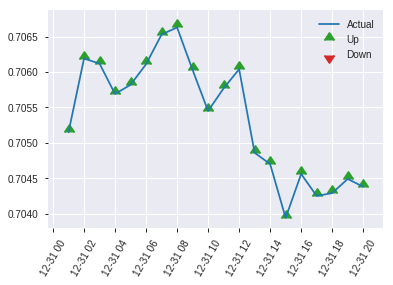


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3077675368472764
RMSE: 0.5547680027248114
LogLoss: 0.9007906628064759
Mean Per-Class Error: 0.46718717139852783
AUC: 0.5184069400630915
pr_auc: 0.5019179424469321
Gini: 0.03681388012618303
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0028186550545357854: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    315  0.9937   (315.0/317.0)
1      0    300  0        (0.0/300.0)
Total  2    615  0.5105   (315.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00281866   0.655738   397
max f2                       0.00281866   0.826446   397
max f0point5                 0.00281866   0.543478   397
max accuracy                 0.343062     0.531605   227
max precision                0.999995     1          0
max recall                   0.00281866   1          397
max specificity              0.999995     1          0
max absolute_mcc             0.262476     0.0666129  272
max min_per_class_accuracy   0.381448     0.520505   210
max mean_per_class_accuracy  0.343062     0.532813   227

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 40.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.943351           1.46905   1.46905            0.714286         0.973938  0.714286                    0.973938            0.0166667       0.0166667                  46.9048   46.9048
    2        0.0210697                   0.920713           1.02833   1.26564            0.5              0.931209  0.615385                    0.954217            0.01            0.0266667                  2.83333   26.5641
    3        0.0307942                   0.888669           1.02833   1.1907             0.5              0.904525  0.578947                    0.938525            0.01            0.0366667                  2.83333   19.0702
    4        0.0405186                   0.86114            1.02833   1.15173            0.5              0.873442  0.56                        0.922905            0.01            0.0466667                  2.83333   15.1733
    5        0.0502431                   0.85016            0.685556  1.06151            0.333333         0.855998  0.516129                    0.909955            0.00666667      0.0533333                  -31.4444  6.15054
    6        0.100486                    0.744044           0.862473  0.961989           0.419355         0.789077  0.467742                    0.849516            0.0433333       0.0966667                  -13.7527  -3.80108
    7        0.150729                    0.687519           1.26054   1.06151            0.612903         0.712998  0.516129                    0.80401             0.0633333       0.16                       26.0538   6.15054
    8        0.200972                    0.636291           0.862473  1.01175            0.419355         0.658746  0.491935                    0.767694            0.0433333       0.203333                   -13.7527  1.17473
    9        0.299838                    0.538583           0.944044  0.989423           0.459016         0.589058  0.481081                    0.708792            0.0933333       0.296667                   -5.59563  -1.05766
    10       0.400324                    0.462346           1.29371   1.0658             0.629032         0.499045  0.518219                    0.656143            0.13            0.426667                   29.371    6.5803
    11       0.50081                     0.381325           0.961989  1.04497            0.467742         0.423874  0.508091                    0.609539            0.0966667       0.523333                   -3.80108  4.4973
    12       0.599676                    0.299068           0.944044  1.02833            0.459016         0.338988  0.5                         0.564935            0.0933333       0.616667                   -5.59563  2.83333
    13       0.700162                    0.245376           1.02833   1.02833            0.5              0.271463  0.5                         0.522816            0.103333        0.72                       2.83333   2.83333
    14       0.799028                    0.179896           0.775464  0.997045           0.377049         0.216011  0.484787                    0.484854            0.0766667       0.796667                   -22.4536  -0.29547
    15       0.899514                    0.0934069          0.961989  0.993129           0.467742         0.141558  0.482883                    0.446504            0.0966667       0.893333                   -3.80108  -0.687087
    16       1                           0.000444208        1.06151   1                  0.516129         0.047852  0.486224                    0.406445      

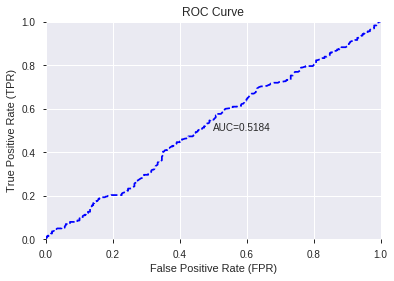

This function is available for GLM models only


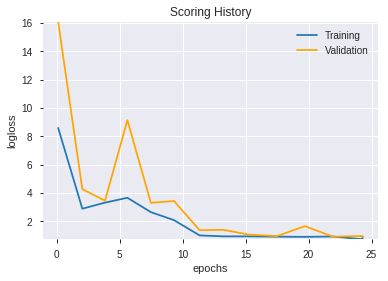

--2019-08-24 15:15:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.100
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  50.1MB/s    in 7.4s    

2019-08-24 15:15:52 (47.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_141529_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_141529_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_151647_model_7  0.532666  0.720666              0.487471  0.509315  0.259402
1  DeepLearning_grid_1_AutoML_20190824_151647_model_6  0.520673  0.707552              0.489048  0.506629  0.256673
2  DeepLearning_grid_1_AutoML_20190824_151647_model_8  0.505662  0.720292              0.500000  0.513133  0.263305
3  DeepLearning_grid_1_AutoML_20190824_151647_model_4  0.505510  0.702174              0.490536  0.503428  0.253440
4  DeepLearning_grid_1_AutoML_20190824_151647_model_1  0.500347  0.855271              0.487471  0.528673  0.279495
5  DeepLearning_grid_1_AutoML_20190824_151647_model_2  0.483244  0.782338              0.500000  0.525815  0.276482
6  DeepLearning_grid_1_AutoML_20190824_151647_model_3  0.480557  0.715224              0.496935  0.508777  0.258854
7  DeepLearning_grid_1_AutoML_20190824_151647_model_5  0.466504  0.723906              0.500000  0.514763  0.264981
8               DeepLearning_1_AutoML_20190824_151647  0.465315  0.704260              0.484585  0.504862  0.254886

variable  relative_importance  scaled_importance  percentage
0         days_in_month             1.000000           1.000000    0.029845
1             STDDEV_24             0.898978           0.898978    0.026830
2                 VAR_8             0.865652           0.865652    0.025836
3          is_month_end             0.786665           0.786665    0.023478
4             CORREL_20             0.774280           0.774280    0.023109
5                VAR_12             0.751455           0.751455    0.022427
6                   SUB             0.751357           0.751357    0.022424
7                TRANGE             0.743799           0.743799    0.022199
8        CDLRICKSHAWMAN             0.730270           0.730270    0.021795
9                   DIV             0.718113           0.718113    0.021432
10      CDLADVANCEBLOCK             0.716094           0.716094    0.021372
11       is_month_start             0.697343           0.697343    0.020812
12        CDLHANGINGMAN             0.693800           0.693800    0.020707
13              CDLDOJI             0.689789           0.689789    0.020587
14    CDLGRAVESTONEDOJI             0.689072           0.689072    0.020565
15    CDLLONGLEGGEDDOJI             0.685374           0.685374    0.020455
16            CDLHAMMER             0.677027           0.677027    0.020206
17            CDLONNECK             0.667715           0.667715    0.019928
18      CDLSHOOTINGSTAR             0.667160           0.667160    0.019912
19   CDLSEPARATINGLINES             0.662161           0.662161    0.019762
20             CORREL_8             0.658465           0.658465    0.019652
21            CORREL_12             0.645784           0.645784    0.019274
22          CDLPIERCING             0.645316           0.645316    0.019260
23     is_quarter_start             0.644258           0.644258    0.019228
24          CDLDOJISTAR             0.636998           0.636998    0.019011
25  CDLRISEFALL3METHODS             0.636953           0.636953    0.019010
26   CDLEVENINGDOJISTAR             0.636537           0.636537    0.018998
27    CDLSTALLEDPATTERN             0.633827           0.633827    0.018917
28  CDLXSIDEGAP3METHODS             0.632039           0.632039    0.018863
29         CDLTHRUSTING             0.630594           0.630594    0.018820
30        CDLHIKKAKEMOD             0.630341           0.630341    0.018813
31    CDL3WHITESOLDIERS             0.625786           0.625786    0.018677
32  CDLGAPSIDESIDEWHITE             0.624327           0.624327    0.018633
33    CDLINVERTEDHAMMER             0.624229           0.624229    0.018630
34            CORREL_14             0.623226           0.623226    0.018600
35         CDLTASUKIGAP             0.621863           0.621863    0.018560
36       CDLMATCHINGLOW             0.621494           0.621494    0.018549
37   CDLIDENTICAL3CROWS             0.619853           0.619853    0.018500
38     CDLSTICKSANDWICH             0.617829           0.617829    0.018439
39       CDL3BLACKCROWS             0.617804           0.617804    0.018438
40      CDLHOMINGPIGEON             0.614799           0.614799    0.018349
41    CDLDARKCLOUDCOVER             0.613712           0.613712    0.018316
42       CDLEVENINGSTAR             0.608138           0.608138    0.018150
43   CDLMORNINGDOJISTAR             0.606197           0.606197    0.018092
44     CDLDRAGONFLYDOJI             0.602375           0.602375    0.017978
45       CDLMORNINGSTAR             0.601263           0.601263    0.017945
46            CDLTAKURI             0.597212           0.597212    0.017824
47       CDLHARAMICROSS             0.595520           0.595520    0.017773
48       CDL3LINESTRIKE             0.588794           0.588794    0.017573
49            CDLINNECK             0.584563           0.584563    0.017446

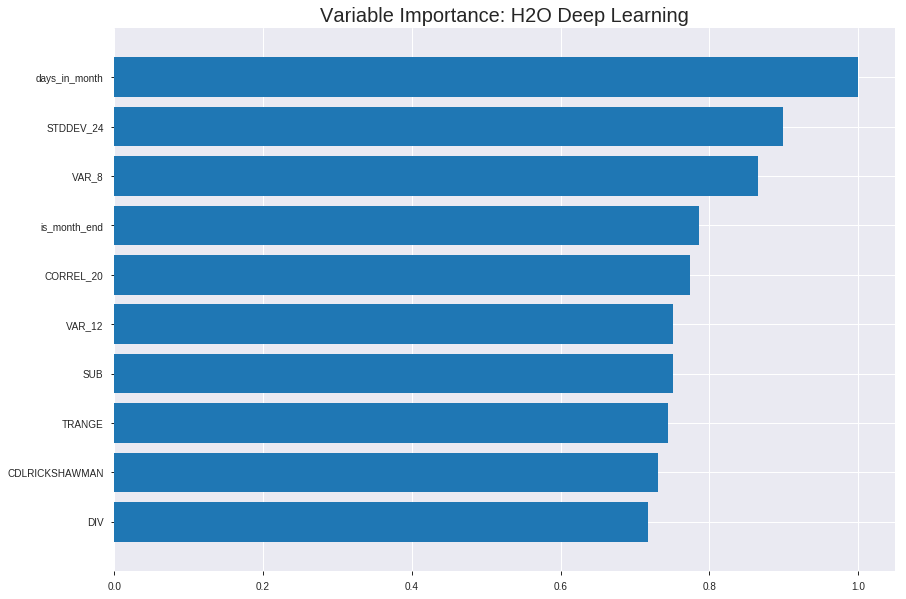

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_151647_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2376754125711965
RMSE: 0.4875196535230108
LogLoss: 0.663526783074872
Mean Per-Class Error: 0.4449162975491283
AUC: 0.591651154276521
pr_auc: 0.612768478221102
Gini: 0.18330230855304208
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4439826277638196: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      283  1896  0.8701   (1896.0/2179.0)
1      65   2071  0.0304   (65.0/2136.0)
Total  348  3967  0.4545   (1961.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443983     0.678683  260
max f2                       0.294841     0.835955  325
max f0point5                 0.514954     0.576052  225
max accuracy                 0.585412     0.552955  154
max precision                0.999107     1         0
max recall                   0.0548672    1         383
max specificity              0.999107     1         0
max absolute_mcc             0.443983     0.182597  260
max min_per_class_accuracy   0.555633     0.309775  181
max mean_per_class_accuracy  0.552858     0.555084  187

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 54.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.944836           2.02013   2.02013            1                0.974805  1                           0.974805            0.0205993       0.0205993                  102.013   102.013
    2        0.0201622                   0.864705           1.83221   1.92725            0.906977         0.905464  0.954023                    0.940533            0.0182584       0.0388577                  83.2212   92.7251
    3        0.0301275                   0.787333           1.92617   1.92689            0.953488         0.826866  0.953846                    0.902935            0.0191948       0.0580524                  92.6172   92.6894
    4        0.0400927                   0.739499           1.50335   1.82162            0.744186         0.761974  0.901734                    0.867899            0.0149813       0.0730337                  50.3353   82.1621
    5        0.0500579                   0.694745           1.45637   1.74891            0.72093          0.714428  0.865741                    0.837347            0.0145131       0.0875468                  45.6374   74.891
    6        0.100116                    0.61569            1.11294   1.43093            0.550926         0.650971  0.708333                    0.744159            0.0557116       0.143258                   11.2943   43.0926
    7        0.150174                    0.574084           1.11294   1.32493            0.550926         0.593523  0.655864                    0.693947            0.0557116       0.19897                    11.2943   32.4932
    8        0.2                         0.557455           0.97718   1.2383             0.483721         0.565026  0.612978                    0.661829            0.0486891       0.247659                   -2.28203  23.8296
    9        0.740904                    0.555633           1.01007   1.07167            0.5              0.555651  0.530497                    0.584312            0.546348        0.794007                   1.00655   7.16742
    10       0.8                         0.550268           0.966494  1.0639             0.478431         0.553559  0.526651                    0.582041            0.0571161       0.851124                   -3.35059  6.39045
    11       0.899884                    0.480123           1.00772   1.05767            0.49884          0.526326  0.523564                    0.575856            0.100655        0.951779                   0.7722    5.76684
    12       1                           0.000953641        0.481652  1                  0.238426         0.313418  0.495017                    0.549582            0.048221        1                          -51.8348  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25879071882765126
RMSE: 0.5087147715838919
LogLoss: 0.7255817767823682
Mean Per-Class Error: 0.4910812706684037
AUC: 0.4973246449122104
pr_auc: 0.5140003300517231
Gini: -0.005350710175579199
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11476028954404824: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    581   0.9898   (581.0/587.0)
1      3    643   0.0046   (3.0/646.0)
Total  9    1224  0.4736   (584.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.11476      0.687701   390
max f2                       0.00230055   0.846214   399
max f0point5                 0.157172     0.580341   383
max accuracy                 0.446845     0.529603   325
max precision                0.784507     0.586207   27
max recall                   0.00230055   1          399
max specificity              0.999238     0.998296   0
max absolute_mcc             0.95565      0.0413865  4
max min_per_class_accuracy   0.555633     0.23339    187
max mean_per_class_accuracy  0.446845     0.508919   325

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 54.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.89046            0.734103  0.734103           0.384615         0.945495  0.384615                    0.945495            0.00773994      0.00773994                 -26.5897  -26.5897
    2        0.0202758                   0.793076           1.27245   0.992508           0.666667         0.832957  0.52                        0.891477            0.0123839       0.0201238                  27.2446   -0.749226
    3        0.0300081                   0.753034           0.954334  0.980127           0.5              0.775152  0.513514                    0.85375             0.00928793      0.0294118                  -4.56656  -1.98728
    4        0.0405515                   0.709186           1.02774   0.992508           0.538462         0.734635  0.52                        0.82278             0.0108359       0.0402477                  2.77447   -0.749226
    5        0.0502839                   0.664457           0.636223  0.923549           0.333333         0.681562  0.483871                    0.795448            0.00619195      0.0464396                  -36.3777  -7.64506
    6        0.100568                    0.591747           1.07747   1.00051            0.564516         0.624356  0.524194                    0.709902            0.0541796       0.100619                   7.74743   0.0511835
    7        0.150041                    0.561283           0.87611   0.959493           0.459016         0.575598  0.502703                    0.665618            0.0433437       0.143963                   -12.389   -4.05071
    8        0.768856                    0.555633           1.01562   1.00467            0.53211          0.555726  0.526371                    0.577171            0.628483        0.772446                   1.56219   0.466846
    9        0.799676                    0.554255           1.05479   1.0066             0.552632         0.55497   0.527383                    0.576315            0.0325077       0.804954                   5.47906   0.660014
    10       0.899432                    0.492661           0.977611  1.00338            0.512195         0.535956  0.525699                    0.571839            0.0975232       0.902477                   -2.23892  0.338491
    11       1                           0.00230055         0.969727  1                  0.508065         0.352507  0.523925                    0.549781            0.0975232       1                          -3.02731  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:26:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 15:26:48  7.916 sec         250 obs/sec       0.265122  1             1144       0.608677         1.05569             -0.482096      0.513291        0.508955           1.1478           0.504287                         0.590598           0.997085              -0.398425        0.516684          0.535106             1.17457            0.46472
    2019-08-24 15:27:22  41.614 sec        644 obs/sec       5.24009   20            22611      0.501822         0.697081            -0.00740096    0.541382        0.559137           1.69875          0.486443                         0.512467           0.730006              -0.052901        0.497119          0.506317             0.880924           0.476075
    2019-08-24 15:27:55  1 min 14.306 sec  738 obs/sec       11.0248   42            47572      0.499087         0.690438            0.00355089     0.557165        0.587164           1.88239          0.474855                         0.515565           0.737127              -0.0656707       0.51183           0.534113             1.32139            0.476075
    2019-08-24 15:28:28  1 min 47.843 sec  799 obs/sec       17.5272   67            75630      0.511457         0.71598             -0.0464574     0.574367        0.593943           1.88239          0.482271                         0.516733           0.73698               -0.0705048       0.496626          0.523821             1.46821            0.467964
    2019-08-24 15:29:02  2 min 21.501 sec  857 obs/sec       24.8308   95            107145     0.570936         0.887143            -0.304003      0.581948        0.596765           1.92831          0.469061                         0.572411           0.911414              -0.313626        0.493791          0.516154             0.880924           0.469586
    2019-08-24 15:29:35  2 min 55.045 sec  909 obs/sec       32.7152   125           141166     0.502004         0.694374            -0.00813098    0.586259        0.606562           1.97422          0.475319                         0.516364           0.73685               -0.0689739       0.489603          0.513735             1.46821            0.467153
    2019-08-24 15:30:09  3 min 29.050 sec  948 obs/sec       40.8575   156           176300     0.48752          0.663527            0.0492039      0.591651        0.612768           2.02013          0.454461                         0.508715           0.725582              -0.0375385       0.497325          0.514                0.734103           0.473642

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
days_in_month   1.0                    1.0                  0.029845222661359964
STDDEV_24       0.8989779949188232     0.8989779949188232   0.026830198426015205
VAR_8           0.8656517863273621     0.8656517863273621   0.02583557031014412
is_month_end    0.7866649031639099     0.7866649031639099   0.023478189194804065
CORREL_20       0.7742795944213867     0.7742795944213867   0.023108546897653775
---             ---                    ---                  ---
CDLMORNINGSTAR  0.6012628078460693     0.6012628078460693   0.01794482237816043
CDLTAKURI       0.5972120761871338     0.5972120761871338   0.01782392738985808
CDLHARAMICROSS  0.59552001953125       0.59552001953125     0.017773427582207593
CDL3LINESTRIKE  0.588793933391571      0.588793933391571    0.017572686043729385
CDLINNECK       0.5845632553100586     0.5845632553100586   0.01744642051437811


See the whole table with table.as_data_frame()


('accuracy', 0.5445705024311183)

('F1', 0.659316427783903)

('auc', 0.5326656151419558)

('logloss', 0.7206660296889814)

('mean_per_class_error', 0.4627024185068349)

('rmse', 0.5093147744807529)

('mse', 0.2594015395043802)

deeplearning prediction progress: |███████████████████████████████████████| 100%


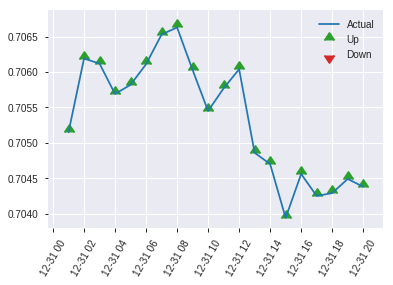


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2594015395043802
RMSE: 0.5093147744807529
LogLoss: 0.7206660296889814
Mean Per-Class Error: 0.4627024185068349
AUC: 0.5326656151419558
pr_auc: 0.5261692759673136
Gini: 0.06533123028391152
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1729382863510049: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    308  0.9716   (308.0/317.0)
1      1    299  0.0033   (1.0/300.0)
Total  10   607  0.5008   (309.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.172938     0.659316   263
max f2                       0.124772     0.827358   269
max f0point5                 0.20975      0.548601   260
max accuracy                 0.556158     0.544571   144
max precision                0.998429     1          0
max recall                   0.124772     1          269
max specificity              0.998429     1          0
max absolute_mcc             0.172938     0.0991835  263
max min_per_class_accuracy   0.556158     0.273333   144
max mean_per_class_accuracy  0.556158     0.537298   144

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 55.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.956192           1.17524   1.17524            0.571429         0.977294  0.571429                    0.977294            0.0133333       0.0133333                  17.5238    17.5238
    2        0.0210697                   0.876899           1.71389   1.42385            0.833333         0.911037  0.692308                    0.946713            0.0166667       0.03                       71.3889    42.3846
    3        0.0307942                   0.830975           1.02833   1.29895            0.5              0.858001  0.631579                    0.918699            0.01            0.04                       2.83333    29.8947
    4        0.0405186                   0.774447           0         0.9872             0                0.800318  0.48                        0.890288            0               0.04                       -100       -1.28
    5        0.0502431                   0.724775           1.02833   0.995161           0.5              0.754266  0.483871                    0.863961            0.01            0.05                       2.83333    -0.483871
    6        0.100486                    0.61673            1.32688   1.16102            0.645161         0.664385  0.564516                    0.764173            0.0666667       0.116667                   32.6882    16.1022
    7        0.150729                    0.575979           0.995161  1.10573            0.483871         0.593674  0.537634                    0.70734             0.05            0.166667                   -0.483871  10.5735
    8        0.200972                    0.562306           1.32688   1.16102            0.645161         0.568499  0.564516                    0.67263             0.0666667       0.233333                   32.6882    16.1022
    9        0.797407                    0.555633           0.955679  1.00743            0.464674         0.555793  0.489837                    0.58524             0.57            0.803333                   -4.43207   0.743225
    10       0.799028                    0.555443           2.05667   1.00956            1                0.555526  0.490872                    0.585179            0.00333333      0.806667                   105.667    0.956051
    11       0.899514                    0.5033             0.995161  1.00795            0.483871         0.541813  0.49009                     0.580335            0.1             0.906667                   -0.483871  0.795195
    12       1                           0.0349031          0.928817  1                  0.451613         0.339197  0.486224                    0.556104            0.0933333       1                          -7.11828   0

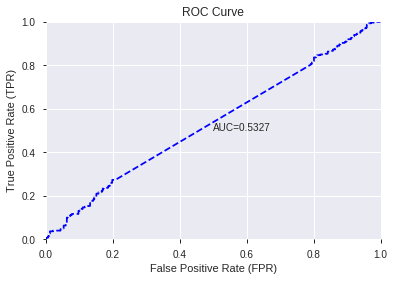

This function is available for GLM models only


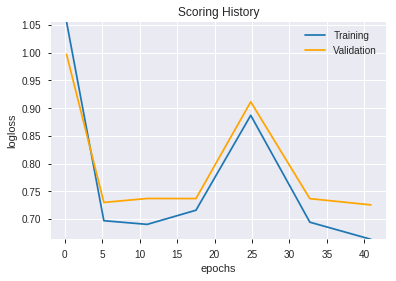

--2019-08-24 15:33:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_151647_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_151647_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['days_in_month',
 'STDDEV_24',
 'VAR_8',
 'is_month_end',
 'CORREL_20',
 'VAR_12',
 'SUB',
 'TRANGE',
 'CDLRICKSHAWMAN',
 'DIV',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLHANGINGMAN',
 'CDLDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLHAMMER',
 'CDLONNECK',
 'CDLSHOOTINGSTAR',
 'CDLSEPARATINGLINES',
 'CORREL_8',
 'CORREL_12',
 'CDLPIERCING',
 'is_quarter_start',
 'CDLDOJISTAR',
 'CDLRISEFALL3METHODS',
 'CDLEVENINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDLXSIDEGAP3METHODS',
 'CDLTHRUSTING',
 'CDLHIKKAKEMOD',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'CDLINVERTEDHAMMER',
 'CORREL_14',
 'CDLTASUKIGAP',
 'CDLMATCHINGLOW',
 'CDLIDENTICAL3CROWS',
 'CDLSTICKSANDWICH',
 'CDL3BLACKCROWS',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLMORNINGSTAR',
 'CDLTAKURI',
 'CDLHARAMICROSS',
 'CDL3LINESTRIKE',
 'CDLINNECK']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_153417_model_1  0.504453  0.692236              0.492292  0.499546  0.249546

variable  relative_importance  scaled_importance  percentage
0    CDLSEPARATINGLINES             0.008680           1.000000    0.057964
1   CDLRISEFALL3METHODS             0.006709           0.772961    0.044804
2             CORREL_14             0.006662           0.767562    0.044491
3    CDLIDENTICAL3CROWS             0.006417           0.739321    0.042854
4         CDLHANGINGMAN             0.006387           0.735835    0.042652
5     CDLINVERTEDHAMMER             0.006037           0.695487    0.040313
6     CDL3WHITESOLDIERS             0.005572           0.641995    0.037212
7             CDLONNECK             0.005381           0.619907    0.035932
8        is_month_start             0.005222           0.601580    0.034870
9             CDLHAMMER             0.005055           0.582421    0.033759
10       CDLMORNINGSTAR             0.004599           0.529879    0.030714
11        CDLHIKKAKEMOD             0.004592           0.528998    0.030663
12       CDLRICKSHAWMAN             0.004337           0.499697    0.028964
13      CDLHOMINGPIGEON             0.004141           0.477090    0.027654
14   CDLEVENINGDOJISTAR             0.004042           0.465624    0.026989
15     CDLSTICKSANDWICH             0.003874           0.446310    0.025870
16       CDLMATCHINGLOW             0.003835           0.441864    0.025612
17         CDLTASUKIGAP             0.003745           0.431468    0.025009
18            CDLINNECK             0.003540           0.407876    0.023642
19   CDLMORNINGDOJISTAR             0.003539           0.407726    0.023633
20  CDLXSIDEGAP3METHODS             0.003318           0.382263    0.022157
21            CORREL_12             0.003266           0.376284    0.021811
22        days_in_month             0.003188           0.367227    0.021286
23       CDLHARAMICROSS             0.003140           0.361724    0.020967
24    CDLDARKCLOUDCOVER             0.003140           0.361696    0.020965
25     is_quarter_start             0.003027           0.348688    0.020211
26            STDDEV_24             0.003019           0.347820    0.020161
27                VAR_8             0.002274           0.261926    0.015182
28          CDLPIERCING             0.002230           0.256938    0.014893
29             CORREL_8             0.002187           0.251969    0.014605
30       CDL3BLACKCROWS             0.001963           0.226185    0.013111
31          CDLDOJISTAR             0.001599           0.184174    0.010675
32       CDL3LINESTRIKE             0.001532           0.176510    0.010231
33  CDLGAPSIDESIDEWHITE             0.001409           0.162352    0.009411
34         CDLTHRUSTING             0.001407           0.162098    0.009396
35    CDLSTALLEDPATTERN             0.001229           0.141619    0.008209
36       CDLEVENINGSTAR             0.001203           0.138539    0.008030
37                  DIV             0.000942           0.108564    0.006293
38            CORREL_20             0.000929           0.107063    0.006206
39               TRANGE             0.000900           0.103717    0.006012
40                  SUB             0.000884           0.101898    0.005906
41            CDLTAKURI             0.000868           0.100016    0.005797
42         is_month_end             0.000776           0.089390    0.005181
43    CDLLONGLEGGEDDOJI             0.000720           0.082975    0.004810
44               VAR_12             0.000609           0.070185    0.004068
45              CDLDOJI             0.000516           0.059467    0.003447
46      CDLADVANCEBLOCK             0.000370           0.042592    0.002469
47     CDLDRAGONFLYDOJI             0.000349           0.040263    0.002334
48    CDLGRAVESTONEDOJI             0.000239           0.027482    0.001593
49      CDLSHOOTINGSTAR             0.000147           0.016965    0.000983

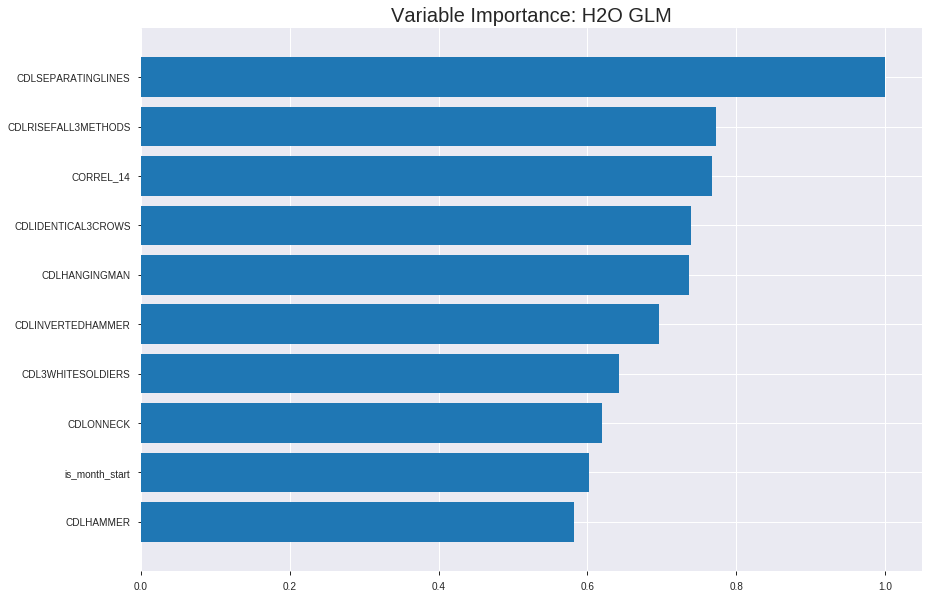

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_153417_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24937373214707442
RMSE: 0.4993733394436215
LogLoss: 0.6918908601202322
Null degrees of freedom: 4314
Residual degrees of freedom: 4264
Null deviance: 5981.431655925498
Residual deviance: 5971.018122837604
AIC: 6073.018122837604
AUC: 0.5434061169522494
pr_auc: 0.5359479103041322
Gini: 0.08681223390449877
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4624631481956489: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      21   2158  0.9904   (2158.0/2179.0)
1      4    2132  0.0019   (4.0/2136.0)
Total  25   4290  0.501    (2162.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.462463     0.663554   376
max f2                       0.447683     0.831193   389
max f0point5                 0.493565     0.555927   230
max accuracy                 0.495626     0.534878   174
max precision                0.611945     1          0
max recall                   0.447683     1          389
max specificity              0.611945     1          0
max absolute_mcc             0.493565     0.0710481  230
max min_per_class_accuracy   0.495626     0.533708   174
max mean_per_class_accuracy  0.495626     0.534867   174

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.516951           1.5151    1.5151             0.75             0.528894  0.75                        0.528894            0.0154494       0.0154494                  51.5098   51.5098
    2        0.0201622                   0.505567           1.36241   1.43963            0.674419         0.509539  0.712644                    0.519328            0.0135768       0.0290262                  36.2414   43.9634
    3        0.0301275                   0.504313           0.986576  1.28978            0.488372         0.504862  0.638462                    0.514543            0.00983146      0.0388577                  -1.34244  28.9776
    4        0.0400927                   0.502635           1.08054   1.23777            0.534884         0.503546  0.612717                    0.51181             0.0107678       0.0496255                  8.05352   23.7768
    5        0.0500579                   0.501126           1.08054   1.20647            0.534884         0.501748  0.597222                    0.509807            0.0107678       0.0603933                  8.05352   20.6467
    6        0.100116                    0.497458           1.02877   1.11762            0.509259         0.498333  0.553241                    0.50407             0.0514981       0.111891                   2.87705   11.7619
    7        0.150174                    0.497003           1.10359   1.11294            0.546296         0.497215  0.550926                    0.501785            0.0552434       0.167135                   10.359    11.2943
    8        0.2                         0.496705           1.04295   1.09551            0.516279         0.496852  0.542294                    0.500556            0.0519663       0.219101                   4.29514   9.55056
    9        0.300116                    0.496275           1.05215   1.08104            0.520833         0.496473  0.535135                    0.499194            0.105337        0.324438                   5.21516   8.10431
    10       0.4                         0.495954           1.02647   1.06742            0.508121         0.496118  0.528389                    0.498426            0.102528        0.426966                   2.64703   6.74157
    11       0.500116                    0.495596           1.07553   1.06904            0.532407         0.495782  0.529194                    0.497896            0.107678        0.534644                   7.55328   6.90406
    12       0.6                         0.495204           0.942103  1.04791            0.466357         0.495407  0.518733                    0.497482            0.0941011       0.628745                   -5.78971  4.79089
    13       0.699884                    0.49467            0.970225  1.03682            0.480278         0.494949  0.513245                    0.497121            0.0969101       0.725655                   -2.97746  3.68222
    14       0.8                         0.493815           0.982008  1.02996            0.486111         0.494282  0.509849                    0.496765            0.0983146       0.82397                    -1.79918  2.99625
    15       0.899884                    0.492267           0.909293  1.01657            0.450116         0.493237  0.503219                    0.496374            0.090824        0.914794                   -9.07067  1.65687
    16       1                           0.411492           0.851074  1                  0.421296         0.482825  0.495017                    0.495017         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2503945987085471
RMSE: 0.5003944431231696
LogLoss: 0.6939401454522846
Null degrees of freedom: 1232
Residual degrees of freedom: 1182
Null deviance: 1710.5993345457732
Residual deviance: 1711.2563986853338
AIC: 1813.2563986853338
AUC: 0.4829787290151423
pr_auc: 0.5154904814263876
Gini: -0.034042541969715345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4320898100836602: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    587   1        (587.0/587.0)
1      0    646   0        (0.0/646.0)
Total  0    1233  0.4761   (587.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.43209      0.6876     399
max f2                       0.43209      0.846214   399
max f0point5                 0.43209      0.579061   399
max accuracy                 0.483208     0.525547   360
max precision                0.531549     0.833333   5
max recall                   0.43209      1          399
max specificity              0.61295      0.998296   0
max absolute_mcc             0.497386     0.0542253  89
max min_per_class_accuracy   0.495625     0.483816   186
max mean_per_class_accuracy  0.496014     0.509819   161

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.51614            1.32139   1.32139            0.692308         0.53822   0.692308                    0.53822             0.0139319       0.0139319                  32.1386   32.1386
    2        0.0202758                   0.505226           1.11339   1.22155            0.583333         0.508339  0.64                        0.523877            0.0108359       0.0247678                  11.339    22.1548
    3        0.0300081                   0.504325           0.795279  1.0833             0.416667         0.504698  0.567568                    0.517657            0.00773994      0.0325077                  -20.4721  8.32985
    4        0.0405515                   0.503833           0.440462  0.916161           0.230769         0.504121  0.48                        0.514138            0.00464396      0.0371517                  -55.9538  -8.3839
    5        0.0502839                   0.502059           0.954334  0.923549           0.5              0.503107  0.483871                    0.512003            0.00928793      0.0464396                  -4.56656  -7.64506
    6        0.100568                    0.497342           0.831194  0.877372           0.435484         0.498552  0.459677                    0.505277            0.0417957       0.0882353                  -16.8806  -12.2628
    7        0.150041                    0.496876           1.00127   0.918224           0.52459          0.497077  0.481081                    0.502573            0.0495356       0.137771                   0.126884  -8.17756
    8        0.200324                    0.496631           1.10826   0.965925           0.580645         0.496741  0.506073                    0.501109            0.0557276       0.193498                   10.8259   -3.40745
    9        0.300081                    0.496273           1.11727   1.01624            0.585366         0.496459  0.532432                    0.499563            0.111455        0.304954                   11.727    1.62371
    10       0.399838                    0.495951           1.02416   1.01821            0.536585         0.496121  0.533469                    0.498705            0.102167        0.407121                   2.41637   1.82148
    11       0.500406                    0.495605           0.785017  0.971348           0.41129          0.495771  0.508914                    0.498115            0.0789474       0.486068                   -21.4983  -2.86516
    12       0.600162                    0.495305           0.946576  0.967231           0.495935         0.495454  0.506757                    0.497673            0.0944272       0.580495                   -5.34245  -3.27692
    13       0.699919                    0.494909           1.02416   0.975345           0.536585         0.495126  0.511008                    0.49731             0.102167        0.682663                   2.41637   -2.46548
    14       0.799676                    0.494329           1.03968   0.983371           0.544715         0.494683  0.515213                    0.496982            0.103715        0.786378                   3.96813   -1.66291
    15       0.899432                    0.49275            1.10175   0.996501           0.577236         0.493735  0.522092                    0.496622            0.109907        0.896285                   10.1752   -0.349937
    16       1                           0.43209            1.0313    1                  0.540323         0.482331  0.523925                    0.49518


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 15:34:18  0.000 sec   2            1.7       51            1.38378           1.38788
    2019-08-24 15:34:18  0.027 sec   4            1         51            1.38276           1.38826
    2019-08-24 15:34:18  0.055 sec   6            0.64      51            1.38152           1.38888
    2019-08-24 15:34:18  0.084 sec   8            0.4       51            1.38015           1.38985
    2019-08-24 15:34:18  0.116 sec   10           0.25      51            1.37881           1.39121

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5429497568881686)

('F1', 0.6563876651982378)

('auc', 0.504453207150368)

('logloss', 0.6922361863838992)

('mean_per_class_error', 0.4651735015772871)

('rmse', 0.49954577731312316)

('mse', 0.24954598363137245)

glm prediction progress: |████████████████████████████████████████████████| 100%


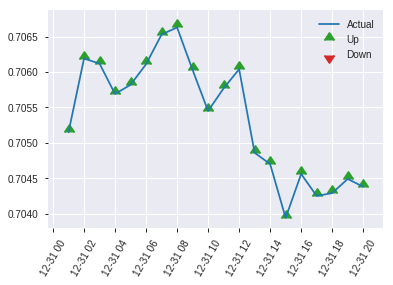


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24954598363137245
RMSE: 0.49954577731312316
LogLoss: 0.6922361863838992
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.0660663376912
Residual deviance: 854.2194539977314
AIC: 956.2194539977314
AUC: 0.504453207150368
pr_auc: 0.5046491463331947
Gini: 0.00890641430073602
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4654824036292197: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    310  0.9779   (310.0/317.0)
1      2    298  0.0067   (2.0/300.0)
Total  9    608  0.5057   (312.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.465482     0.656388   390
max f2                       0.448502     0.825537   399
max f0point5                 0.475406     0.54559    376
max accuracy                 0.496736     0.54295    93
max precision                0.575358     1          0
max recall                   0.448502     1          399
max specificity              0.575358     1          0
max absolute_mcc             0.496736     0.0876108  93
max min_per_class_accuracy   0.495922     0.486667   184
max mean_per_class_accuracy  0.496654     0.534826   98

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.517042           1.17524   1.17524            0.571429         0.531223  0.571429                    0.531223            0.0133333       0.0133333                  17.5238    17.5238
    2        0.0210697                   0.505082           1.37111   1.26564            0.666667         0.509322  0.615385                    0.521114            0.0133333       0.0266667                  37.1111    26.5641
    3        0.0307942                   0.504139           1.02833   1.1907             0.5              0.504662  0.578947                    0.515919            0.01            0.0366667                  2.83333    19.0702
    4        0.0405186                   0.501321           1.71389   1.31627            0.833333         0.502905  0.64                        0.512796            0.0166667       0.0533333                  71.3889    31.6267
    5        0.0502431                   0.498285           1.02833   1.26054            0.5              0.500026  0.612903                    0.510324            0.01            0.0633333                  2.83333    26.0538
    6        0.100486                    0.497431           1.06151   1.16102            0.516129         0.497747  0.564516                    0.504036            0.0533333       0.116667                   6.15054    16.1022
    7        0.150729                    0.496929           0.995161  1.10573            0.483871         0.497189  0.537634                    0.501753            0.05            0.166667                   -0.483871  10.5735
    8        0.200972                    0.49667            1.39323   1.17761            0.677419         0.496807  0.572581                    0.500517            0.07            0.236667                   39.3226    17.7608
    9        0.299838                    0.496404           0.674317  1.01166            0.327869         0.496536  0.491892                    0.499204            0.0666667       0.303333                   -32.5683   1.16577
    10       0.400324                    0.496144           0.829301  0.965884           0.403226         0.496284  0.469636                    0.498471            0.0833333       0.386667                   -17.0699   -3.41161
    11       0.50081                     0.495914           1.02833   0.978414           0.5              0.496041  0.475728                    0.497984            0.103333        0.49                       2.83333    -2.15858
    12       0.599676                    0.495676           1.04519   0.989423           0.508197         0.495807  0.481081                    0.497625            0.103333        0.593333                   4.51913    -1.05766
    13       0.700162                    0.495371           0.928817  0.980725           0.451613         0.495511  0.476852                    0.497321            0.0933333       0.686667                   -7.11828   -1.92747
    14       0.799028                    0.494793           1.07891   0.992874           0.52459          0.495125  0.482759                    0.49705             0.106667        0.793333                   7.89071    -0.712644
    15       0.899514                    0.492654           1.06151   1.00054            0.516129         0.493917  0.486486                    0.4967              0.106667        0.9                        6.15054    0.0540541
    16       1                           0.448502           0.995161  1                  0.483871         0.478264  0.486224            

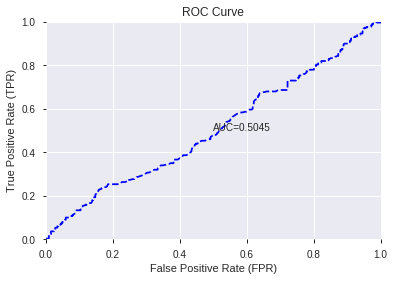

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


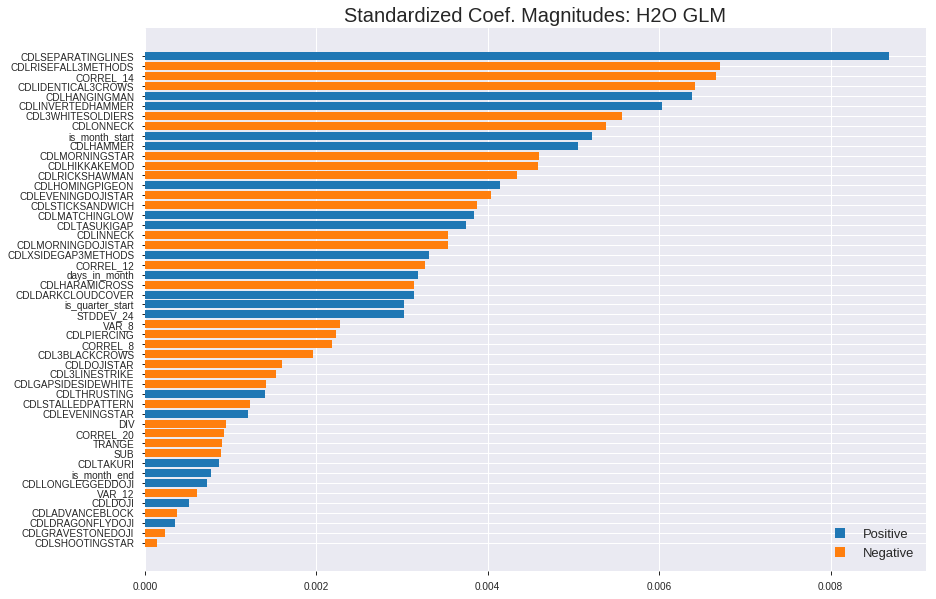

'log_likelihood'
--2019-08-24 15:34:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_153417_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_153417_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLSEPARATINGLINES',
 'CDLRISEFALL3METHODS',
 'CORREL_14',
 'CDLIDENTICAL3CROWS',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDL3WHITESOLDIERS',
 'CDLONNECK',
 'is_month_start',
 'CDLHAMMER',
 'CDLMORNINGSTAR',
 'CDLHIKKAKEMOD',
 'CDLRICKSHAWMAN',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDLMATCHINGLOW',
 'CDLTASUKIGAP',
 'CDLINNECK',
 'CDLMORNINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'CORREL_12',
 'days_in_month',
 'CDLHARAMICROSS',
 'CDLDARKCLOUDCOVER',
 'is_quarter_start',
 'STDDEV_24',
 'VAR_8',
 'CDLPIERCING',
 'CORREL_8',
 'CDL3BLACKCROWS',
 'CDLDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'DIV',
 'CORREL_20',
 'TRANGE',
 'SUB',
 'CDLTAKURI',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'VAR_12',
 'CDLDOJI',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR']

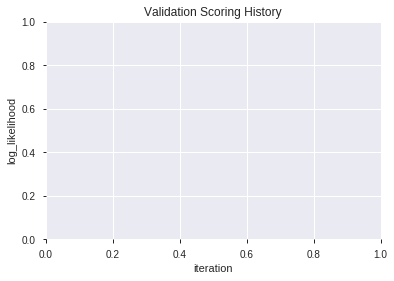

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_153525_model_7  0.536703  0.696239              0.495268  0.501419  0.251421
1               XGBoost_1_AutoML_20190824_153525  0.521588  0.697299              0.489227  0.502030  0.252034
2  XGBoost_grid_1_AutoML_20190824_153525_model_4  0.521009  0.693068              0.490536  0.499962  0.249962
3  XGBoost_grid_1_AutoML_20190824_153525_model_2  0.514059  0.693206              0.492203  0.500038  0.250038
4  XGBoost_grid_1_AutoML_20190824_153525_model_6  0.510741  0.695577              0.498423  0.501190  0.251192
5               XGBoost_3_AutoML_20190824_153525  0.509022  0.696032              0.493691  0.501431  0.251433
6  XGBoost_grid_1_AutoML_20190824_153525_model_5  0.508644  0.716625              0.493691  0.510818  0.260935
7               XGBoost_2_AutoML_20190824_153525  0.500142  0.701211              0.482918  0.503975  0.253991
8  XGBoost_grid_1_AutoML_20190824_153525_model_1  0.495873  0.698180              0.496845  0.502455  0.252461
9  XGBoost_grid_1_AutoML_20190824_153525_model_3  0.489106  0.698867              0.496845  0.502829  0.252837

variable  relative_importance  scaled_importance  percentage
0              VAR_12          1713.697510           1.000000    0.202000
1           STDDEV_24          1689.850952           0.986085    0.199189
2               VAR_8          1635.343872           0.954278    0.192764
3              TRANGE          1038.885864           0.606225    0.122457
4                 DIV          1000.080566           0.583581    0.117883
5                 SUB           571.151062           0.333286    0.067324
6           CORREL_20           307.814117           0.179620    0.036283
7       days_in_month           207.249878           0.120937    0.024429
8             CDLDOJI            69.550102           0.040585    0.008198
9           CORREL_14            68.495056           0.039969    0.008074
10     CDLRICKSHAWMAN            58.144478           0.033929    0.006854
11  CDLLONGLEGGEDDOJI            22.759907           0.013281    0.002683
12      CDLHANGINGMAN            21.880159           0.012768    0.002579
13  CDLGRAVESTONEDOJI            20.817474           0.012148    0.002454
14     is_month_start            16.594395           0.009683    0.001956
15       is_month_end            14.147827           0.008256    0.001668
16          CDLHAMMER             9.083696           0.005301    0.001071
17     CDLHARAMICROSS             8.274749           0.004829    0.000975
18          CDLTAKURI             3.799900           0.002217    0.000448
19    CDLADVANCEBLOCK             3.175496           0.001853    0.000374
20   CDLDRAGONFLYDOJI             2.867902           0.001674    0.000338

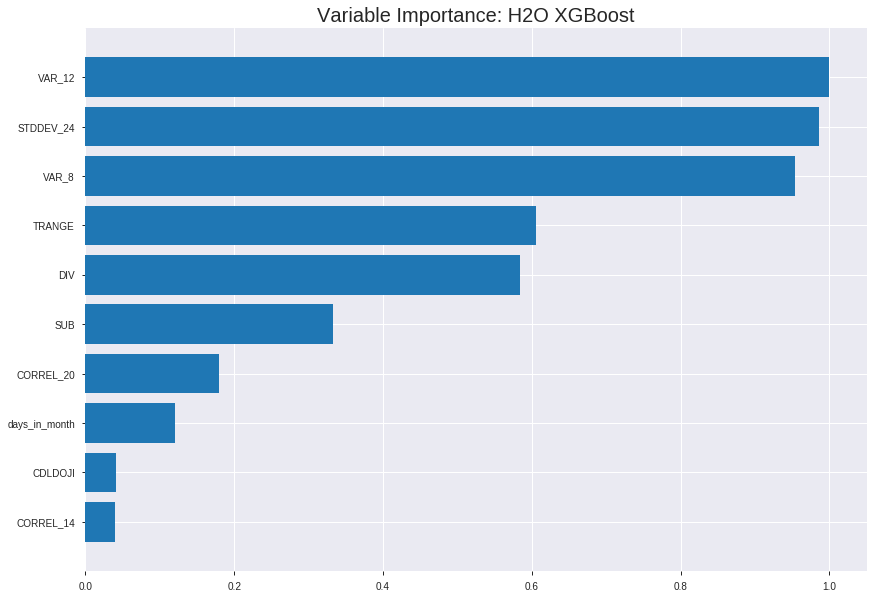

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_153525_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2103730574212903
RMSE: 0.4586644279004971
LogLoss: 0.612224899434762
Mean Per-Class Error: 0.2514989222971057
AUC: 0.8287763001617413
pr_auc: 0.826710078634297
Gini: 0.6575526003234826
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4753764679557399: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1403  776   0.3561   (776.0/2179.0)
1      343   1793  0.1606   (343.0/2136.0)
Total  1746  2569  0.2593   (1119.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475376     0.762168  231
max f2                       0.416271     0.853719  301
max f0point5                 0.52772      0.762702  163
max accuracy                 0.484653     0.747856  220
max precision                0.763812     1         0
max recall                   0.335302     1         367
max specificity              0.763812     1         0
max absolute_mcc             0.483842     0.500871  221
max min_per_class_accuracy   0.49752      0.742509  204
max mean_per_class_accuracy  0.483842     0.748501  221

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.693538           2.02013   2.02013            1                0.715552  1                           0.715552            0.0205993       0.0205993                  102.013   102.013
    2        0.0201622                   0.670816           1.97315   1.99691            0.976744         0.680907  0.988506                    0.698429            0.0196629       0.0402622                  97.3151   99.6911
    3        0.0301275                   0.654982           1.97315   1.98905            0.976744         0.663316  0.984615                    0.686814            0.0196629       0.0599251                  97.3151   98.9052
    4        0.0400927                   0.641932           1.97315   1.9851             0.976744         0.648222  0.982659                    0.677222            0.0196629       0.079588                   97.3151   98.51
    5        0.0500579                   0.632669           2.02013   1.99207            1                0.63767   0.986111                    0.669348            0.0201311       0.0997191                  102.013   99.2074
    6        0.100116                    0.603015           1.81438   1.90323            0.898148         0.616325  0.94213                     0.642837            0.090824        0.190543                   81.4377   90.3225
    7        0.150174                    0.58075            1.76761   1.85802            0.875            0.590999  0.919753                    0.625557            0.0884831       0.279026                   76.7615   85.8022
    8        0.2                         0.565267           1.60671   1.79541            0.795349         0.572355  0.88876                     0.612303            0.0800562       0.359082                   60.6709   79.5412
    9        0.300116                    0.539213           1.51977   1.70346            0.752315         0.551775  0.843243                    0.592112            0.152154        0.511236                   51.9775   70.3462
    10       0.4                         0.516788           1.29832   1.60229            0.642691         0.527963  0.793163                    0.576093            0.129682        0.640918                   29.8321   60.2294
    11       0.500116                    0.496453           1.03345   1.48842            0.511574         0.506612  0.736793                    0.562184            0.103464        0.744382                   3.34467   48.8419
    12       0.6                         0.47361            0.9796    1.40371            0.484919         0.485763  0.694863                    0.549462            0.0978464       0.842228                   -2.04005  40.3714
    13       0.699884                    0.450481           0.660878  1.2977             0.327146         0.462491  0.642384                    0.53705             0.0660112       0.90824                    -33.9122  29.77
    14       0.8                         0.425086           0.491004  1.19675            0.243056         0.438033  0.59241                     0.524658            0.0491573       0.957397                   -50.8996  19.6746
    15       0.899884                    0.384917           0.276538  1.09461            0.136891         0.406633  0.541849                    0.511558            0.0276217       0.985019                   -72.3462  9.46062
    16       1                           0.222356           0.149639  1                  0.0740741        0.348634  0.495017                    0.495247            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2581580200528591
RMSE: 0.5080925309949548
LogLoss: 0.7098765609028707
Mean Per-Class Error: 0.4905683514327456
AUC: 0.4784481621932373
pr_auc: 0.5210912513354904
Gini: -0.04310367561352535
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28588762879371643: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    586   0.9983   (586.0/587.0)
1      0    646   0        (0.0/646.0)
Total  1    1232  0.4753   (586.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.285888     0.687966   398
max f2                       0.285888     0.846436   398
max f0point5                 0.285888     0.579476   398
max accuracy                 0.285888     0.524736   398
max precision                0.717982     1          0
max recall                   0.285888     1          398
max specificity              0.717982     1          0
max absolute_mcc             0.419538     0.0650183  314
max min_per_class_accuracy   0.495293     0.48552    202
max mean_per_class_accuracy  0.616406     0.509432   41

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.667311           1.46821   1.46821            0.769231         0.688738  0.769231                    0.688738            0.0154799       0.0154799                  46.8207    46.8207
    2        0.0202758                   0.644652           1.11339   1.29789            0.583333         0.65855   0.68                        0.674248            0.0108359       0.0263158                  11.339     29.7895
    3        0.0300081                   0.634076           0.795279  1.13488            0.416667         0.639986  0.594595                    0.663136            0.00773994      0.0340557                  -20.4721   13.4884
    4        0.0405515                   0.627017           1.17457   1.1452             0.615385         0.630841  0.6                         0.654739            0.0123839       0.0464396                  17.4565    14.5201
    5        0.0502839                   0.620414           0.954334  1.10826            0.5              0.623251  0.580645                    0.648645            0.00928793      0.0557276                  -4.56656   10.8259
    6        0.100568                    0.59282            0.954334  1.0313             0.5              0.606017  0.540323                    0.627331            0.0479876       0.103715                   -4.56656   3.12968
    7        0.150041                    0.575587           0.844821  0.96981            0.442623         0.583716  0.508108                    0.612949            0.0417957       0.145511                   -15.5179   -3.01899
    8        0.200324                    0.558768           0.923549  0.958198           0.483871         0.567024  0.502024                    0.601422            0.0464396       0.19195                    -7.64506   -4.18019
    9        0.300081                    0.532641           0.962093  0.959493           0.504065         0.54528   0.502703                    0.582758            0.0959752       0.287926                   -3.79068   -4.05071
    10       0.399838                    0.515533           0.931058  0.952399           0.487805         0.523402  0.498986                    0.567949            0.0928793       0.380805                   -6.89421   -4.76014
    11       0.500406                    0.495398           1.06208   0.974442           0.556452         0.505919  0.510535                    0.555483            0.106811        0.487616                   6.20818    -2.55581
    12       0.600162                    0.476399           0.962093  0.972389           0.504065         0.486217  0.509459                    0.54397             0.0959752       0.583591                   -3.79068   -2.76107
    13       0.699919                    0.453645           0.993128  0.975345           0.520325         0.465483  0.511008                    0.532783            0.0990712       0.682663                   -0.687155  -2.46548
    14       0.799676                    0.43107            1.08623   0.989178           0.569106         0.4435    0.518256                    0.521646            0.108359        0.791022                   8.62342    -1.08218
    15       0.899432                    0.403281           0.977611  0.987895           0.512195         0.418724  0.517583                    0.510231            0.0975232       0.888545                   -2.23892   -1.21047
    16       1                           0.270084           1.10826   1                  0.580645         0.367525  0.523925           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:35:52  10.542 sec  0                  0.5              0.693147            0.5             0                  1                0.504983                         0.5                0.693147              0.5               0                    1                  0.476075
    2019-08-24 15:35:52  10.691 sec  5                  0.493501         0.680215            0.696352        0.683475           1.79057          0.389108                         0.500857           0.694865              0.484268          0.514579             1.32139            0.475264
    2019-08-24 15:35:52  10.810 sec  10                 0.488899         0.671117            0.724299        0.717416           1.74466          0.358517                         0.501517           0.696199              0.483423          0.514604             0.880924           0.476075
    2019-08-24 15:35:52  10.937 sec  15                 0.483165         0.659845            0.752604        0.74462            1.92831          0.32445                          0.502513           0.698213              0.479202          0.514913             1.02774            0.476075
    2019-08-24 15:35:52  11.056 sec  20                 0.478237         0.650202            0.772764        0.766318           1.97422          0.325145                         0.503482           0.700202              0.481921          0.518258             1.46821            0.475264
    2019-08-24 15:35:52  11.187 sec  25                 0.474362         0.642618            0.782796        0.777484           2.02013          0.316338                         0.505037           0.703412              0.474892          0.515304             1.32139            0.476075
    2019-08-24 15:35:52  11.328 sec  30                 0.471201         0.636446            0.791868        0.7887             1.97422          0.291078                         0.50562            0.704632              0.475558          0.517569             1.32139            0.476075
    2019-08-24 15:35:53  11.523 sec  35                 0.467732         0.629741            0.804532        0.798396           1.97422          0.274392                         0.505859           0.705118              0.476582          0.521523             1.46821            0.475264
    2019-08-24 15:35:53  11.710 sec  40                 0.463859         0.622228            0.813099        0.809692           1.97422          0.282735                         0.507323           0.708187              0.47427           0.518701             1.32139            0.475264
    2019-08-24 15:35:53  11.870 sec  45                 0.461585         0.617854            0.821022        0.819009           1.97422          0.270684                         0.507938           0.709485              0.473054          0.517792             1.46821            0.475264
    2019-08-24 15:35:53  12.032 sec  50                 0.458664         0.612225            0.828776        0.82671            2.02013          0.259328                         0.508093           0.709877              0.478448          0.521091             1.46821            0.475264

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ----------------------
VAR_12            1713.697509765625      1.0                    0.20199966842697847
STDDEV_24         1689.8509521484375     0.9860847334600791     0.1991887891998414
VAR_8             1635.3438720703125     0.9542780232515897     0.19276384428397356
TRANGE            1038.8858642578125     0.6062247615682749     0.12245720082901561
DIV               1000.08056640625       0.5835805681616627     0.11788308126908358
---               ---                    ---                    ---
CDLHAMMER         9.083696365356445      0.005300641632255615   0.0010707278521658722
CDLHARAMICROSS    8.274748802185059      0.004828593584941814   0.0009753743031268817
CDLTAKURI         3.7998995780944824     0.002217368909297288   0.00044790778445834306
CDLADVANCEBLOCK   3.1754963397979736     0.001853008667925457   0.00037430713651325935
CDLDRAGONFLYDOJI  2.8679022789001465     0.0016735172120850995  0.0003380499219480315


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5510534846029174)

('F1', 0.6564551422319475)

('auc', 0.5367034700315457)

('logloss', 0.6962393968101498)

('mean_per_class_error', 0.44522082018927445)

('rmse', 0.5014190620957428)

('mse', 0.25142107583297435)

xgboost prediction progress: |████████████████████████████████████████████| 100%


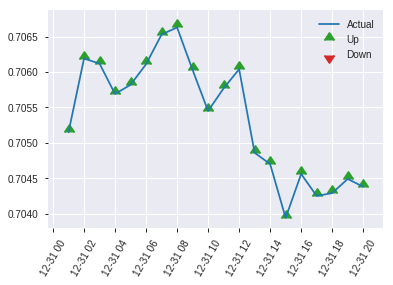


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25142107583297435
RMSE: 0.5014190620957428
LogLoss: 0.6962393968101498
Mean Per-Class Error: 0.44522082018927445
AUC: 0.5367034700315457
pr_auc: 0.5023234416315644
Gini: 0.07340694006309145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2973654568195343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    314  0.9905   (314.0/317.0)
1      0    300  0        (0.0/300.0)
Total  3    614  0.5089   (314.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297365     0.656455  396
max f2                       0.297365     0.826902  396
max f0point5                 0.472862     0.555258  247
max accuracy                 0.472862     0.551053  247
max precision                0.633662     0.607143  24
max recall                   0.297365     1         396
max specificity              0.723462     0.996845  0
max absolute_mcc             0.472862     0.113656  247
max min_per_class_accuracy   0.500257     0.523333  198
max mean_per_class_accuracy  0.472862     0.554779  247

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.678676           0.881429  0.881429           0.428571         0.696847  0.428571                    0.696847            0.01            0.01                       -11.8571   -11.8571
    2        0.0210697                   0.65813            0.685556  0.791026           0.333333         0.668894  0.384615                    0.683946            0.00666667      0.0166667                  -31.4444   -20.8974
    3        0.0307942                   0.645783           1.02833   0.865965           0.5              0.653143  0.421053                    0.674219            0.01            0.0266667                  2.83333    -13.4035
    4        0.0405186                   0.637341           2.05667   1.15173            1                0.642878  0.56                        0.666697            0.02            0.0466667                  105.667    15.1733
    5        0.0502431                   0.624295           1.37111   1.19419            0.666667         0.632816  0.580645                    0.660139            0.0133333       0.06                       37.1111    19.4194
    6        0.100486                    0.600841           0.796129  0.995161           0.387097         0.611918  0.483871                    0.636028            0.04            0.1                        -20.3871   -0.483871
    7        0.150729                    0.582581           1.06151   1.01728            0.516129         0.592535  0.494624                    0.621531            0.0533333       0.153333                   6.15054    1.7276
    8        0.200972                    0.562712           1.12785   1.04492            0.548387         0.570978  0.508065                    0.608892            0.0566667       0.21                       12.7849    4.49194
    9        0.299838                    0.539935           1.07891   1.05613            0.52459          0.549867  0.513514                    0.58943             0.106667        0.316667                   7.89071    5.61261
    10       0.400324                    0.521462           0.961989  1.0325             0.467742         0.531454  0.502024                    0.574877            0.0966667       0.413333                   -3.80108   3.24966
    11       0.50081                     0.498672           1.09468   1.04497            0.532258         0.50846   0.508091                    0.561551            0.11            0.523333                   9.46774    4.4973
    12       0.599676                    0.47834            1.24749   1.07836            0.606557         0.488261  0.524324                    0.549468            0.123333        0.646667                   24.7486    7.83604
    13       0.700162                    0.461245           0.995161  1.06642            0.483871         0.469429  0.518519                    0.537981            0.1             0.746667                   -0.483871  6.64198
    14       0.799028                    0.440313           0.80918   1.03459            0.393443         0.450932  0.503043                    0.52721             0.08            0.826667                   -19.082    3.45909
    15       0.899514                    0.404295           0.729785  1.00054            0.354839         0.424364  0.486486                    0.515721            0.0733333       0.9                        -27.0215   0.0540541
    16       1                           0.225772           0.995161  1                  0.483871         0.370523  0.486224               

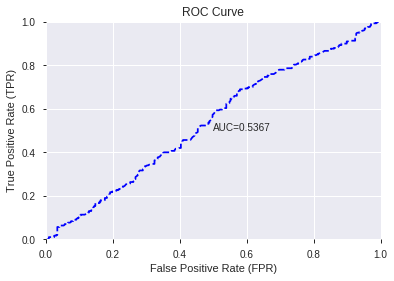

This function is available for GLM models only


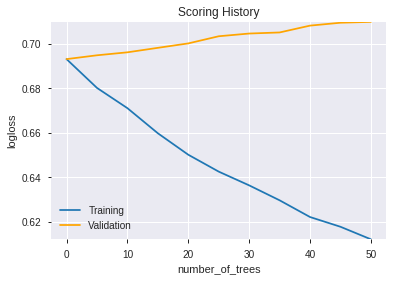

--2019-08-24 15:36:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Sha

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_153525_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_153525_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['VAR_12',
 'STDDEV_24',
 'VAR_8',
 'TRANGE',
 'DIV',
 'SUB',
 'CORREL_20',
 'days_in_month',
 'CDLDOJI',
 'CORREL_14',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLHANGINGMAN',
 'CDLGRAVESTONEDOJI',
 'is_month_start',
 'is_month_end',
 'CDLHAMMER',
 'CDLHARAMICROSS',
 'CDLTAKURI',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse     mse
0  GLM_grid_1_AutoML_20190824_153700_model_1  0.527708  0.691342              0.490626  0.499099  0.2491

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.006981           1.000000    0.018706
1                  CDLLONGLINE             0.006469           0.926634    0.017333
2                       ULTOSC             0.005108           0.731709    0.013687
3           CDLSEPARATINGLINES             0.004845           0.693937    0.012981
4                  CDLBELTHOLD             0.004809           0.688791    0.012884
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_30_1_5             0.000000           0.000000    0.000000
1036                   MA_30_2             0.000000           0.000000    0.000000
1037  BBANDS_middleband_30_2_3             0.000000           0.000000    0.000000
1038  BBANDS_middleband_30_2_4             0.000000           0.000000    0.000000
1039  BBANDS_middleband_30_2_5             0.000000           0.000000    0.000000

[1040 rows x 4 columns]

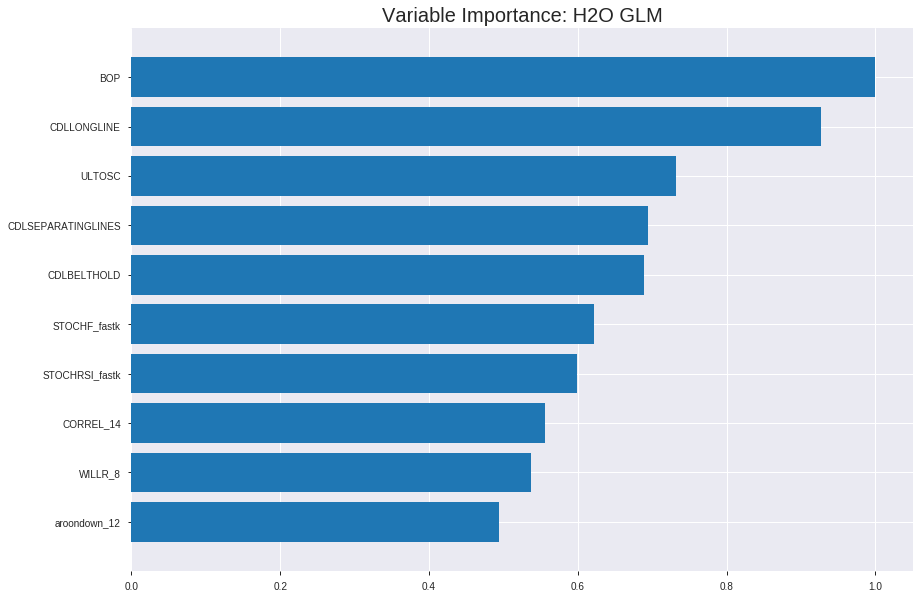

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_153700_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2484967458475263
RMSE: 0.4984944792548121
LogLoss: 0.6901366480264923
Null degrees of freedom: 4314
Residual degrees of freedom: 3359
Null deviance: 5981.431655925498
Residual deviance: 5955.879272468629
AIC: 7867.879272468629
AUC: 0.5585905339184212
pr_auc: 0.5465062687254092
Gini: 0.11718106783684235
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.447105410404278: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      15   2164  0.9931   (2164.0/2179.0)
1      2    2134  0.0009   (2.0/2136.0)
Total  17   4298  0.502    (2166.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.447105     0.663351   388
max f2                       0.447105     0.830867   388
max f0point5                 0.478902     0.558297   289
max accuracy                 0.498854     0.54832    170
max precision                0.576274     1          0
max recall                   0.438916     1          396
max specificity              0.576274     1          0
max absolute_mcc             0.498854     0.0961814  170
max min_per_class_accuracy   0.495789     0.539326   189
max mean_per_class_accuracy  0.498854     0.547649   170

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010197                    0.530239           1.28554   1.28554            0.636364         0.535795  0.636364                    0.535795            0.0131086       0.0131086                  28.5538    28.5538
    2        0.0201622                   0.526796           1.22147   1.25387            0.604651         0.528529  0.62069                     0.532204            0.0121723       0.0252809                  22.1475    25.3874
    3        0.0301275                   0.524132           1.22147   1.24316            0.604651         0.525379  0.615385                    0.529946            0.0121723       0.0374532                  22.1475    24.3158
    4        0.0400927                   0.522618           1.26845   1.24945            0.627907         0.523378  0.618497                    0.528314            0.0126404       0.0500936                  26.8454    24.9445
    5        0.0500579                   0.52099            1.36241   1.27193            0.674419         0.521703  0.62963                     0.526998            0.0135768       0.0636704                  36.2414    27.1934
    6        0.100116                    0.516211           1.10359   1.18776            0.546296         0.518341  0.587963                    0.522669            0.0552434       0.118914                   10.359     18.7762
    7        0.150174                    0.51269            1.05683   1.14412            0.523148         0.514339  0.566358                    0.519892            0.0529026       0.171816                   5.68278    14.4117
    8        0.2                         0.509605           1.07114   1.12594            0.530233         0.511114  0.557358                    0.517705            0.0533708       0.225187                   7.11393    12.5936
    9        0.300116                    0.504756           1.09891   1.11692            0.543981         0.507038  0.552896                    0.514147            0.110019        0.335206                   9.89139    11.6922
    10       0.4                         0.500304           1.04991   1.10019            0.519722         0.502499  0.544612                    0.511238            0.104869        0.440075                   4.99057    10.0187
    11       0.500116                    0.495653           0.996037  1.07934            0.493056         0.497928  0.534291                    0.508574            0.0997191       0.539794                   -0.396315  7.93379
    12       0.6                         0.49118            1.01241   1.0682             0.50116          0.493378  0.528776                    0.506044            0.101124        0.640918                   1.24091    6.8196
    13       0.699884                    0.486189           0.970225  1.05421            0.480278         0.488585  0.521854                    0.503552            0.0969101       0.737828                   -2.97746   5.42141
    14       0.8                         0.480805           0.925893  1.03816            0.458333         0.483672  0.513905                    0.501065            0.0926966       0.830524                   -7.41066   3.81554
    15       0.899884                    0.472759           0.857735  1.01813            0.424594         0.477067  0.503992                    0.498401            0.0856742       0.916199                   -14.2265   1.81294
    16       1                           0.408609           0.837045  1                  0.414352         0.464606  0.495017                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2504347601736034
RMSE: 0.50043457132137
LogLoss: 0.6940176130747245
Null degrees of freedom: 1232
Residual degrees of freedom: 277
Null deviance: 1710.5993345457732
Residual deviance: 1711.4474338422706
AIC: 3623.4474338422706
AUC: 0.5092839700212551
pr_auc: 0.5495469594071929
Gini: 0.018567940042510278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4467410172445307: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    579   0.9864   (579.0/587.0)
1      2    644   0.0031   (2.0/646.0)
Total  10   1223  0.4712   (581.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.446741     0.689139   389
max f2                       0.439521     0.84688    396
max f0point5                 0.446741     0.581437   389
max accuracy                 0.466445     0.531225   328
max precision                0.520229     0.814815   22
max recall                   0.439521     1          396
max specificity              0.568374     0.998296   0
max absolute_mcc             0.51945      0.0911026  25
max min_per_class_accuracy   0.490666     0.48452    189
max mean_per_class_accuracy  0.509442     0.523585   70

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 48.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.525307           1.17457   1.17457            0.615385         0.532539  0.615385                    0.532539            0.0123839       0.0123839                  17.4565   17.4565
    2        0.0202758                   0.520648           1.90867   1.52693            1                0.522611  0.8                         0.527774            0.0185759       0.0309598                  90.8669   52.6935
    3        0.0300081                   0.518906           1.27245   1.4444             0.666667         0.519597  0.756757                    0.525122            0.0123839       0.0433437                  27.2446   44.4398
    4        0.0405515                   0.516664           1.17457   1.37424            0.615385         0.517656  0.72                        0.523181            0.0123839       0.0557276                  17.4565   37.4241
    5        0.0502839                   0.514189           0.795279  1.26218            0.416667         0.515394  0.66129                     0.521674            0.00773994      0.0634675                  -20.4721  26.2184
    6        0.100568                    0.51023            1.07747   1.16983            0.564516         0.511805  0.612903                    0.516739            0.0541796       0.117647                   7.74743   16.9829
    7        0.150041                    0.507824           0.969979  1.10393            0.508197         0.509045  0.578378                    0.514202            0.0479876       0.165635                   -3.00208  10.3933
    8        0.200324                    0.505274           0.954334  1.06638            0.5              0.506482  0.558704                    0.512264            0.0479876       0.213622                   -4.56656  6.63817
    9        0.300081                    0.50003            0.977611  1.03687            0.512195         0.502563  0.543243                    0.509039            0.0975232       0.311146                   -2.23892  3.68714
    10       0.399838                    0.495697           0.85347   0.991114           0.447154         0.497904  0.51927                     0.506261            0.0851393       0.396285                   -14.653   -0.888601
    11       0.500406                    0.49058            0.877372  0.968255           0.459677         0.493323  0.507293                    0.503661            0.0882353       0.48452                    -12.2628  -3.1745
    12       0.600162                    0.485861           1.10175   0.990444           0.577236         0.488364  0.518919                    0.501118            0.109907        0.594427                   10.1752   -0.955569
    13       0.699919                    0.481421           1.08623   1.0041             0.569106         0.483589  0.526072                    0.49862             0.108359        0.702786                   8.62342   0.409688
    14       0.799676                    0.47536            1.0552    1.01047            0.552846         0.478722  0.529412                    0.496138            0.105263        0.80805                    5.5199    1.04717
    15       0.899432                    0.46581            1.00865   1.01027            0.528455         0.470737  0.529306                    0.493321            0.100619        0.908669                   0.864608  1.02692
    16       1                           0.428479           0.908157  1                  0.475806         0.4581    0.523925                    0.489779    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 15:37:09  0.000 sec   2            3.3       956           1.38027           1.38804
    2019-08-24 15:37:15  5.385 sec   4            2.4       971           1.37896           1.38807
    2019-08-24 15:37:20  10.617 sec  6            1.8       981           1.37744           1.38828
    2019-08-24 15:37:25  15.919 sec  8            1.3       993           1.3757            1.38871
    2019-08-24 15:37:30  21.018 sec  10           0.94      1012          1.37373           1.38943

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5348460291734197)

('F1', 0.6578657865786579)

('auc', 0.527707676130389)

('logloss', 0.6913415535908146)

('mean_per_class_error', 0.46334384858044164)

('rmse', 0.49909936383896936)

('mse', 0.24910017498446393)

glm prediction progress: |████████████████████████████████████████████████| 100%


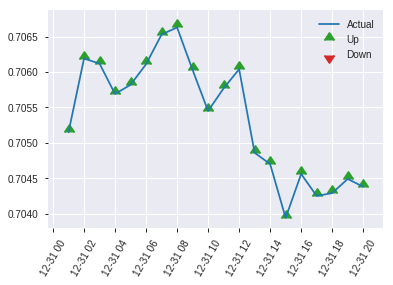


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24910017498446393
RMSE: 0.49909936383896936
LogLoss: 0.6913415535908146
Null degrees of freedom: 616
Residual degrees of freedom: -339
Null deviance: 855.0660663376912
Residual deviance: 853.1154771310655
AIC: 2765.1154771310657
AUC: 0.527707676130389
pr_auc: 0.510697113589114
Gini: 0.055415352260778095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4463189937814166: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    310  0.9779   (310.0/317.0)
1      1    299  0.0033   (1.0/300.0)
Total  8    609  0.5041   (311.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.446319     0.657866   391
max f2                       0.433374     0.826446   397
max f0point5                 0.478209     0.548041   286
max accuracy                 0.500414     0.534846   121
max precision                0.524077     0.833333   5
max recall                   0.433374     1          397
max specificity              0.540641     0.996845   0
max absolute_mcc             0.446319     0.0828338  391
max min_per_class_accuracy   0.490678     0.501577   201
max mean_per_class_accuracy  0.481806     0.536656   266

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 48.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.523216           1.46905   1.46905            0.714286         0.528665  0.714286                    0.528665            0.0166667       0.0166667                  46.9048   46.9048
    2        0.0210697                   0.520761           1.02833   1.26564            0.5              0.521413  0.615385                    0.525318            0.01            0.0266667                  2.83333   26.5641
    3        0.0307942                   0.519285           0.342778  0.974211           0.166667         0.520003  0.473684                    0.523639            0.00333333      0.03                       -65.7222  -2.57895
    4        0.0405186                   0.517952           1.37111   1.06947            0.666667         0.518729  0.52                        0.522461            0.0133333       0.0433333                  37.1111   6.94667
    5        0.0502431                   0.516357           1.71389   1.19419            0.833333         0.517432  0.580645                    0.521488            0.0166667       0.06                       71.3889   19.4194
    6        0.100486                    0.511175           0.928817  1.06151            0.451613         0.513243  0.516129                    0.517365            0.0466667       0.106667                   -7.11828  6.15054
    7        0.150729                    0.507363           1.06151   1.06151            0.516129         0.509551  0.516129                    0.514761            0.0533333       0.16                       6.15054   6.15054
    8        0.200972                    0.504706           1.06151   1.06151            0.516129         0.506164  0.516129                    0.512611            0.0533333       0.213333                   6.15054   6.15054
    9        0.299838                    0.499436           1.14634   1.08948            0.557377         0.502209  0.52973                     0.509181            0.113333        0.326667                   14.6339   8.94775
    10       0.400324                    0.494934           0.829301  1.02417            0.403226         0.49723   0.497976                    0.506181            0.0833333       0.41                       -17.0699  2.417
    11       0.50081                     0.49066            0.928817  1.00504            0.451613         0.492844  0.488673                    0.503505            0.0933333       0.503333                   -7.11828  0.503776
    12       0.599676                    0.486212           1.14634   1.02833            0.557377         0.488492  0.5                         0.50103             0.113333        0.616667                   14.6339   2.83333
    13       0.700162                    0.480738           1.16102   1.04738            0.564516         0.483525  0.509259                    0.498518            0.116667        0.733333                   16.1022   4.73765
    14       0.799028                    0.475789           0.842896  1.02208            0.409836         0.477888  0.496957                    0.495965            0.0833333       0.816667                   -15.7104  2.20757
    15       0.899514                    0.468588           0.895645  1.00795            0.435484         0.47254   0.49009                     0.493348            0.09            0.906667                   -10.4355  0.795195
    16       1                           0.42403            0.928817  1                  0.451613         0.45774   0.486224                    0.48977         

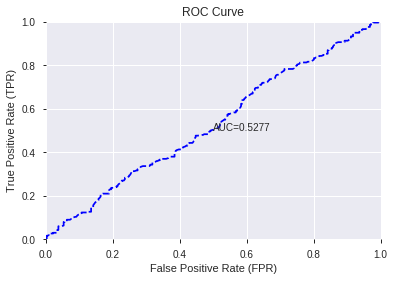

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


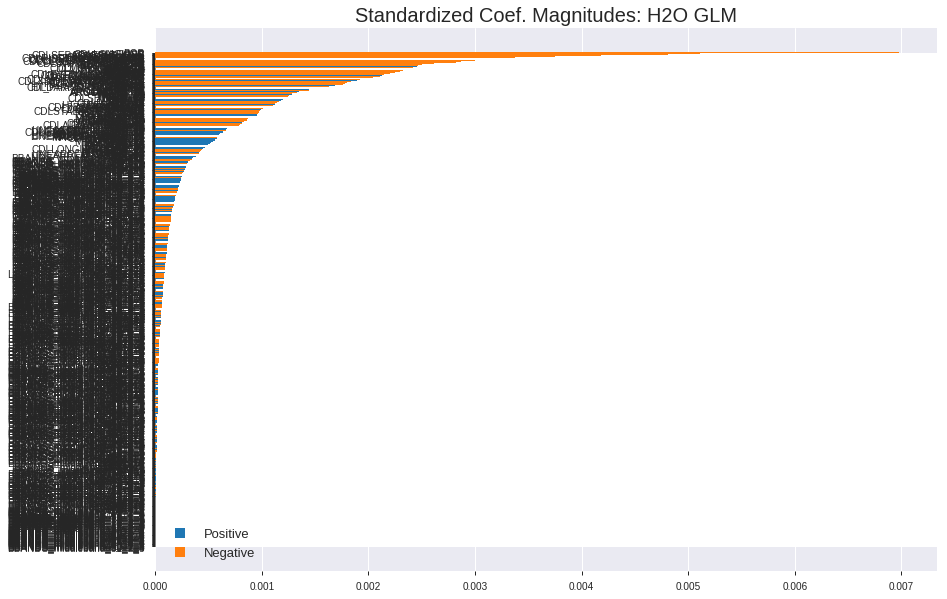

'log_likelihood'
--2019-08-24 15:37:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_153700_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_153700_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

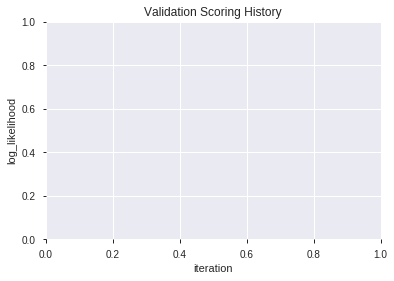

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190824_153854  0.546583  0.697989              0.496845  0.502185  0.252190
1  XGBoost_grid_1_AutoML_20190824_153854_model_2  0.539795  0.693824              0.498423  0.500306  0.250306
2               XGBoost_2_AutoML_20190824_153854  0.519522  0.704105              0.486073  0.505129  0.255155
3  XGBoost_grid_1_AutoML_20190824_153854_model_6  0.518764  0.697971              0.493780  0.502323  0.252328
4  XGBoost_grid_1_AutoML_20190824_153854_model_7  0.517072  0.713230              0.500000  0.509146  0.259230
5  XGBoost_grid_1_AutoML_20190824_153854_model_1  0.514979  0.699452              0.500000  0.502970  0.252979
6  XGBoost_grid_1_AutoML_20190824_153854_model_4  0.513260  0.696177              0.492203  0.501482  0.251484
7               XGBoost_3_AutoML_20190824_153854  0.508796  0.704189              0.495268  0.505325  0.255353
8  XGBoost_grid_1_AutoML_20190824_153854_model_3  0.506877  0.699135              0.496845  0.502951  0.252959
9  XGBoost_grid_1_AutoML_20190824_153854_model_5  0.489364  0.742551              0.500000  0.521884  0.272362

variable  relative_importance  scaled_importance  percentage
0                        BOP           308.872955           1.000000    0.017564
1                     BETA_8           238.700653           0.772812    0.013574
2                   STDDEV_8           223.684708           0.724196    0.012720
3          HT_PHASOR_inphase           218.462540           0.707289    0.012423
4                STOCH_slowk           217.983414           0.705738    0.012396
..                       ...                  ...                ...         ...
404                  MA_12_3             1.481302           0.004796    0.000084
405                   MA_8_5             0.685883           0.002221    0.000039
406                     ASIN             0.651556           0.002109    0.000037
407  BBANDS_upperband_20_0_4             0.204679           0.000663    0.000012
408                 SAR_0.08             0.056339           0.000182    0.000003

[409 rows x 4 columns]

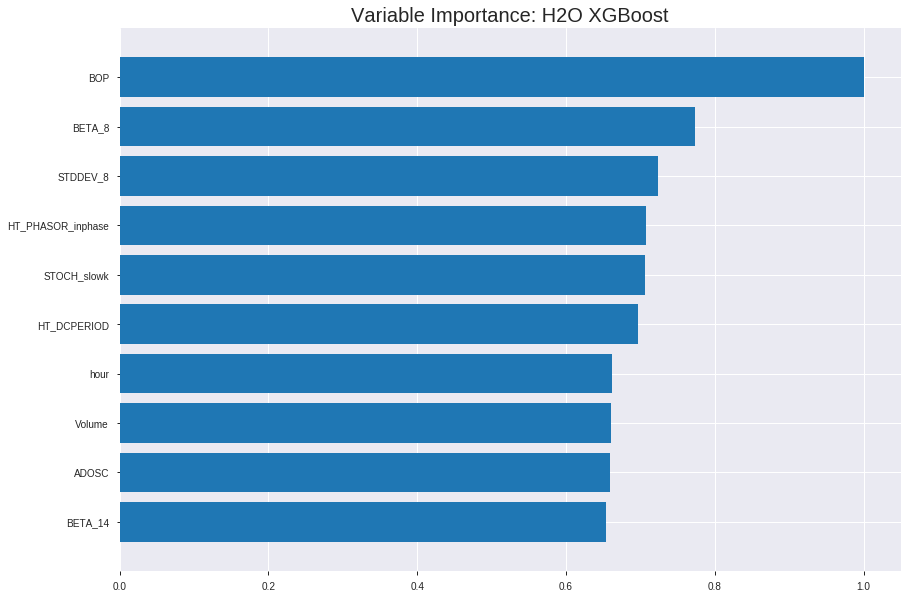

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190824_153854


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15782303506420572
RMSE: 0.3972694741157515
LogLoss: 0.5026020887144975
Mean Per-Class Error: 0.07121658820233312
AUC: 0.9805347434568651
pr_auc: 0.9796667143288489
Gini: 0.9610694869137302
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49747157593568164: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      2039  140   0.0642   (140.0/2179.0)
1      167   1969  0.0782   (167.0/2136.0)
Total  2206  2109  0.0711   (307.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497472     0.92768   199
max f2                       0.464399     0.945946  224
max f0point5                 0.525413     0.940184  177
max accuracy                 0.497472     0.928853  199
max precision                0.804686     1         0
max recall                   0.361698     1         312
max specificity              0.804686     1         0
max absolute_mcc             0.497472     0.857741  199
max min_per_class_accuracy   0.493354     0.926572  202
max mean_per_class_accuracy  0.497472     0.928783  199

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.56 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.754668           2.02013     2.02013            1                0.771167  1                           0.771167            0.0205993       0.0205993                  102.013   102.013
    2        0.0201622                   0.731349           2.02013     2.02013            1                0.741731  1                           0.756619            0.0201311       0.0407303                  102.013   102.013
    3        0.0301275                   0.720357           2.02013     2.02013            1                0.72625   1                           0.746573            0.0201311       0.0608614                  102.013   102.013
    4        0.0400927                   0.708245           2.02013     2.02013            1                0.713414  1                           0.738331            0.0201311       0.0809925                  102.013   102.013
    5        0.0500579                   0.698379           2.02013     2.02013            1                0.703373  1                           0.731372            0.0201311       0.101124                   102.013   102.013
    6        0.100116                    0.669565           2.02013     2.02013            1                0.682555  1                           0.706964            0.101124        0.202247                   102.013   102.013
    7        0.150174                    0.646094           2.02013     2.02013            1                0.657343  1                           0.690423            0.101124        0.303371                   102.013   102.013
    8        0.2                         0.625907           2.02013     2.02013            1                0.635695  1                           0.676789            0.100655        0.404026                   102.013   102.013
    9        0.300116                    0.588959           1.99675     2.01233            0.988426         0.607627  0.996139                    0.653717            0.199906        0.603933                   99.675    101.233
    10       0.4                         0.546648           1.87952     1.97917            0.930394         0.568699  0.979722                    0.632487            0.187734        0.791667                   87.9519   97.9167
    11       0.500116                    0.491176           1.37949     1.85912            0.68287          0.519631  0.920297                    0.609895            0.138109        0.929775                   37.9488   85.912
    12       0.6                         0.441549           0.524953    1.63702            0.259861         0.465262  0.810351                    0.585817            0.0524345       0.98221                    -47.5047  63.7016
    13       0.699884                    0.401483           0.135925    1.42279            0.0672854        0.420376  0.704305                    0.562206            0.0135768       0.995787                   -86.4075  42.2788
    14       0.8                         0.365399           0.0374098   1.24941            0.0185185        0.383669  0.618482                    0.539863            0.00374532      0.999532                   -96.259   24.9415
    15       0.899884                    0.32418            0.00468708  1.11125            0.00232019       0.345936  0.55009                     0.518338            0.000468165     1                          -99.5313  11.1254
    16       1                           0.192351           0           1                  0                0.29075   0.495017  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25863521703570647
RMSE: 0.5085619107205203
LogLoss: 0.7114793769016876
Mean Per-Class Error: 0.4799394517961403
AUC: 0.5020081645139002
pr_auc: 0.5316285908937607
Gini: 0.004016329027800358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19019579887390137: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    587   1        (587.0/587.0)
1      0    646   0        (0.0/646.0)
Total  0    1233  0.4761   (587.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.190196     0.6876     399
max f2                       0.190196     0.846214   399
max f0point5                 0.190196     0.579061   399
max accuracy                 0.24692      0.523925   395
max precision                0.642794     0.597222   47
max recall                   0.190196     1          399
max specificity              0.750161     0.998296   0
max absolute_mcc             0.286894     0.0613446  385
max min_per_class_accuracy   0.504351     0.5        194
max mean_per_class_accuracy  0.552943     0.520061   135

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.699956           0.880924  0.880924           0.461538         0.715313  0.461538                    0.715313            0.00928793      0.00928793                 -11.9076  -11.9076
    2        0.0202758                   0.677465           1.11339   0.992508           0.583333         0.687326  0.52                        0.701879            0.0108359       0.0201238                  11.339    -0.749226
    3        0.0300081                   0.666087           1.27245   1.0833             0.666667         0.671313  0.567568                    0.691966            0.0123839       0.0325077                  27.2446   8.32985
    4        0.0405515                   0.655184           1.02774   1.06885            0.538462         0.661031  0.56                        0.683923            0.0108359       0.0433437                  2.77447   6.88545
    5        0.0502839                   0.648517           1.27245   1.10826            0.666667         0.651745  0.580645                    0.677695            0.0123839       0.0557276                  27.2446   10.8259
    6        0.100568                    0.622511           1.10826   1.10826            0.580645         0.63429   0.580645                    0.655992            0.0557276       0.111455                   10.8259   10.8259
    7        0.150041                    0.60014            0.93869   1.05235            0.491803         0.609998  0.551351                    0.640826            0.0464396       0.157895                   -6.13105  5.23471
    8        0.200324                    0.579933           0.985119  1.03547            0.516129         0.589874  0.54251                     0.628037            0.0495356       0.20743                    -1.48807  3.54721
    9        0.300081                    0.551971           1.08623   1.05235            0.569106         0.565595  0.551351                    0.607279            0.108359        0.315789                   8.62342   5.23471
    10       0.399838                    0.526719           0.868987  1.0066             0.455285         0.537948  0.527383                    0.589981            0.0866873       0.402477                   -13.1013  0.660014
    11       0.500406                    0.503609           0.985119  1.00228            0.516129         0.515126  0.525122                    0.574938            0.0990712       0.501548                   -1.48807  0.228309
    12       0.600162                    0.478012           0.822434  0.972389           0.430894         0.490855  0.509459                    0.560962            0.0820433       0.583591                   -17.7566  -2.76107
    13       0.699919                    0.448453           1.10175   0.990827           0.577236         0.462997  0.519119                    0.546999            0.109907        0.693498                   10.1752   -0.917313
    14       0.799676                    0.419607           1.11727   1.0066             0.585366         0.43369   0.527383                    0.532864            0.111455        0.804954                   11.727    0.660014
    15       0.899432                    0.37996            0.900023  0.99478            0.471545         0.400135  0.52119                     0.518143            0.0897833       0.894737                   -9.99773  -0.522045
    16       1                           0.190196           1.04669   1                  0.548387         0.33364   0.523925                    0.4995


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:38:55  0.007 sec   0                  0.5              0.693147            0.5             0                  1                0.504983                         0.5                0.693147              0.5               0                    1                  0.476075
    2019-08-24 15:38:56  1.489 sec   5                  0.483579         0.660762            0.83494         0.832746           2.02013          0.272538                         0.50145            0.696058              0.481001          0.513816             1.02774            0.476075
    2019-08-24 15:38:57  1.923 sec   10                 0.472528         0.639429            0.880515        0.877968           2.02013          0.20927                          0.502425           0.698047              0.485678          0.519287             0.880924           0.475264
    2019-08-24 15:38:57  2.319 sec   15                 0.463348         0.621946            0.901794        0.902835           2.02013          0.178679                         0.503555           0.700383              0.48557           0.515683             1.32139            0.475264
    2019-08-24 15:38:57  2.745 sec   20                 0.453269         0.603038            0.923857        0.925779           2.02013          0.161066                         0.50358            0.700499              0.498866          0.519217             0.734103           0.476075
    2019-08-24 15:38:58  3.204 sec   25                 0.442002         0.582189            0.941866        0.941636           2.02013          0.138818                         0.503959           0.701371              0.504304          0.527553             0.880924           0.476075
    2019-08-24 15:38:58  3.686 sec   30                 0.430178         0.560665            0.955776        0.956012           2.02013          0.119583                         0.505894           0.705478              0.498999          0.525877             1.17457            0.476075
    2019-08-24 15:38:59  4.142 sec   35                 0.420331         0.543042            0.964757        0.965061           2.02013          0.104751                         0.50722            0.708299              0.494267          0.522276             0.880924           0.476075
    2019-08-24 15:38:59  4.637 sec   40                 0.412195         0.528639            0.97189         0.971617           2.02013          0.0894554                        0.50788            0.709832              0.498175          0.524853             0.880924           0.476075
    2019-08-24 15:39:00  5.076 sec   45                 0.405023         0.51606             0.976435        0.976577           2.02013          0.0801854                        0.508953           0.712214              0.495516          0.524914             0.734103           0.476075
    2019-08-24 15:39:00  5.531 sec   50                 0.397269         0.502602            0.980535        0.979667           2.02013          0.0711472                        0.508562           0.711479              0.502008          0.531629             0.880924           0.476075

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      308.8729553222656      1.0                     0.017564184299138762
BETA_8                   238.70065307617188     0.7728117627751553      0.01357380822992513
STDDEV_8                 223.68470764160156     0.7241964820397367      0.01271992047933387
HT_PHASOR_inphase        218.46253967285156     0.7072893107294439      0.012422959806462774
STOCH_slowk              217.98341369628906     0.7057381034505075      0.012395714115929369
---                      ---                    ---                     ---
MA_12_3                  1.481302261352539      0.004795830246150906    8.423484631077853e-05
MA_8_5                   0.685882568359375      0.0022205976811526043   3.900298692600451e-05
ASIN                     0.6515560150146484     0.0021094628188953646   3.705099372325895e-05
BBANDS_upperband_20_0_4  0.2046794891357422     0.0006626656222529676   1.163918111795459e-05
SAR_0.08                 0.056339263916015625   0.00018240270941569973  3.2037548048396033e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.546191247974068)

('F1', 0.6557377049180327)

('auc', 0.5465825446898003)

('logloss', 0.6979891670214431)

('mean_per_class_error', 0.4476288117770768)

('rmse', 0.5021853250511643)

('mse', 0.2521901006967436)

xgboost prediction progress: |████████████████████████████████████████████| 100%


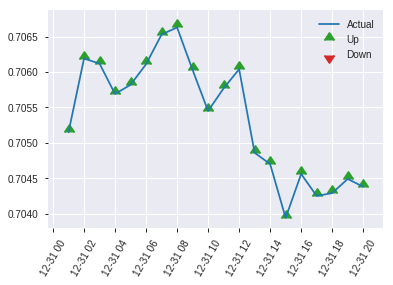


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2521901006967436
RMSE: 0.5021853250511643
LogLoss: 0.6979891670214431
Mean Per-Class Error: 0.4476288117770768
AUC: 0.5465825446898003
pr_auc: 0.5308573098853799
Gini: 0.09316508937960055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27576857805252075: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    315  0.9937   (315.0/317.0)
1      0    300  0        (0.0/300.0)
Total  2    615  0.5105   (315.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275769     0.655738  397
max f2                       0.275769     0.826446  397
max f0point5                 0.462334     0.559021  271
max accuracy                 0.572447     0.546191  118
max precision                0.784909     1         0
max recall                   0.275769     1         397
max specificity              0.784909     1         0
max absolute_mcc             0.462334     0.116963  271
max min_per_class_accuracy   0.515387     0.523333  197
max mean_per_class_accuracy  0.462334     0.552371  271

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 51.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.712365           1.17524   1.17524            0.571429         0.730369  0.571429                    0.730369            0.0133333       0.0133333                  17.5238    17.5238
    2        0.0210697                   0.688625           1.37111   1.26564            0.666667         0.697777  0.615385                    0.715326            0.0133333       0.0266667                  37.1111    26.5641
    3        0.0307942                   0.679216           1.02833   1.1907             0.5              0.683833  0.578947                    0.705381            0.01            0.0366667                  2.83333    19.0702
    4        0.0405186                   0.674054           1.02833   1.15173            0.5              0.676286  0.56                        0.698398            0.01            0.0466667                  2.83333    15.1733
    5        0.0502431                   0.669362           1.37111   1.19419            0.666667         0.672166  0.580645                    0.693321            0.0133333       0.06                       37.1111    19.4194
    6        0.100486                    0.643016           1.39323   1.29371            0.677419         0.656603  0.629032                    0.674962            0.07            0.13                       39.3226    29.371
    7        0.150729                    0.611691           0.796129  1.12785            0.387097         0.628723  0.548387                    0.659549            0.04            0.17                       -20.3871   12.7849
    8        0.200972                    0.596408           1.12785   1.12785            0.548387         0.605167  0.548387                    0.645954            0.0566667       0.226667                   12.7849    12.7849
    9        0.299838                    0.56454            1.07891   1.11171            0.52459          0.57881   0.540541                    0.623814            0.106667        0.333333                   7.89071    11.1712
    10       0.400324                    0.540032           0.862473  1.04915            0.419355         0.55349   0.510121                    0.606162            0.0866667       0.42                       -13.7527   4.91498
    11       0.50081                     0.514903           1.06151   1.05163            0.516129         0.527672  0.511327                    0.590413            0.106667        0.526667                   6.15054    5.16289
    12       0.599676                    0.493089           1.04519   1.05057            0.508197         0.504689  0.510811                    0.57628             0.103333        0.63                       4.51913    5.05676
    13       0.700162                    0.469279           1.16102   1.06642            0.564516         0.482154  0.518519                    0.562771            0.116667        0.746667                   16.1022    6.64198
    14       0.799028                    0.438086           0.708033  1.02208            0.344262         0.45394   0.496957                    0.549305            0.07            0.816667                   -29.1967   2.20757
    15       0.899514                    0.386932           0.829301  1.00054            0.403226         0.415712  0.486486                    0.534381            0.0833333       0.9                        -17.0699   0.0540541
    16       1                           0.228607           0.995161  1                  0.483871         0.341433  0.486224                   

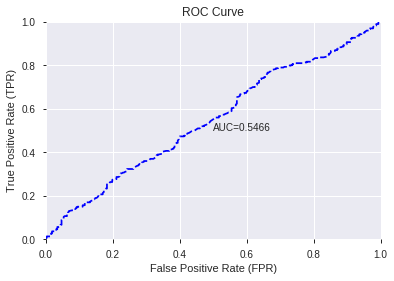

This function is available for GLM models only


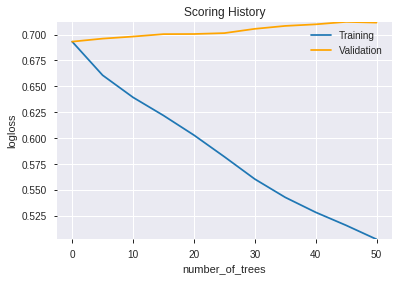

--2019-08-24 15:40:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.ja

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190824_153854',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190824_153854',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_aebd',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_154135_model_7  0.507508  0.707713              0.492292  0.505589  0.255620
1  DeepLearning_grid_1_AutoML_20190824_154135_model_3  0.501719  0.746770              0.500000  0.516134  0.266395
2  DeepLearning_grid_1_AutoML_20190824_154135_model_1  0.500641  0.936766              0.492203  0.536840  0.288198
3  DeepLearning_grid_1_AutoML_20190824_154135_model_9  0.500000  0.697536              0.500000  0.502185  0.252190
4  DeepLearning_grid_1_AutoML_20190824_154135_model_8  0.500000  0.698627              0.500000  0.502725  0.252732
5  DeepLearning_grid_1_AutoML_20190824_154135_model_6  0.498339  0.693161              0.486341  0.499980  0.249980
6               DeepLearning_1_AutoML_20190824_154135  0.482066  0.744907              0.485983  0.521084  0.271528
7  DeepLearning_grid_1_AutoML_20190824_154135_model_2  0.480447  0.771198              0.500000  0.522807  0.273327
8  DeepLearning_grid_1_AutoML_20190824_154135_model_5  0.477066  0.690797              0.485804  0.498943  0.248944
9  DeepLearning_grid_1_AutoML_20190824_154135_model_4  0.448538  0.742571              0.495268  0.517761  0.268076

variable  relative_importance  scaled_importance  percentage
0         days_in_month             1.000000           1.000000    0.024694
1             STDDEV_24             0.950145           0.950145    0.023463
2                 VAR_8             0.912083           0.912083    0.022523
3          is_month_end             0.897450           0.897450    0.022162
4             CORREL_20             0.871787           0.871787    0.021528
5       CDLADVANCEBLOCK             0.866279           0.866279    0.021392
6     CDLDARKCLOUDCOVER             0.837406           0.837406    0.020679
7    CDLEVENINGDOJISTAR             0.834295           0.834295    0.020602
8             CDLHAMMER             0.830535           0.830535    0.020509
9                TRANGE             0.827681           0.827681    0.020439
10    CDLSTALLEDPATTERN             0.824271           0.824271    0.020355
11            CDLONNECK             0.819160           0.819160    0.020229
12    CDLGRAVESTONEDOJI             0.818305           0.818305    0.020207
13      CDLSHOOTINGSTAR             0.817741           0.817741    0.020194
14          CDLPIERCING             0.816811           0.816811    0.020171
15              CDLDOJI             0.815997           0.815997    0.020150
16               VAR_12             0.811195           0.811195    0.020032
17             CORREL_8             0.811148           0.811148    0.020031
18                  DIV             0.806832           0.806832    0.019924
19          CDLDOJISTAR             0.805211           0.805211    0.019884
20    CDLLONGLEGGEDDOJI             0.803792           0.803792    0.019849
21     is_quarter_start             0.802613           0.802613    0.019820
22         CDLTASUKIGAP             0.801822           0.801822    0.019800
23        CDLHIKKAKEMOD             0.801282           0.801282    0.019787
24       CDLRICKSHAWMAN             0.800426           0.800426    0.019766
25                  SUB             0.800425           0.800425    0.019766
26   CDLSEPARATINGLINES             0.797275           0.797275    0.019688
27        CDLHANGINGMAN             0.796161           0.796161    0.019661
28  CDLGAPSIDESIDEWHITE             0.795256           0.795256    0.019638
29       is_month_start             0.794839           0.794839    0.019628
30       CDLMATCHINGLOW             0.794187           0.794187    0.019612
31       CDL3BLACKCROWS             0.793934           0.793934    0.019606
32      CDLHOMINGPIGEON             0.790445           0.790445    0.019519
33     CDLSTICKSANDWICH             0.789882           0.789882    0.019506
34         CDLTHRUSTING             0.786184           0.786184    0.019414
35            CDLTAKURI             0.780704           0.780704    0.019279
36       CDLEVENINGSTAR             0.779130           0.779130    0.019240
37  CDLXSIDEGAP3METHODS             0.778672           0.778672    0.019229
38    CDLINVERTEDHAMMER             0.778588           0.778588    0.019227
39            CORREL_14             0.776897           0.776897    0.019185
40       CDLHARAMICROSS             0.775561           0.775561    0.019152
41     CDLDRAGONFLYDOJI             0.775499           0.775499    0.019150
42  CDLRISEFALL3METHODS             0.775491           0.775491    0.019150
43            CORREL_12             0.773554           0.773554    0.019102
44   CDLMORNINGDOJISTAR             0.769388           0.769388    0.018999
45   CDLIDENTICAL3CROWS             0.769157           0.769157    0.018994
46            CDLINNECK             0.768811           0.768811    0.018985
47    CDL3WHITESOLDIERS             0.764415           0.764415    0.018877
48       CDLMORNINGSTAR             0.761585           0.761585    0.018807
49       CDL3LINESTRIKE             0.744913           0.744913    0.018395

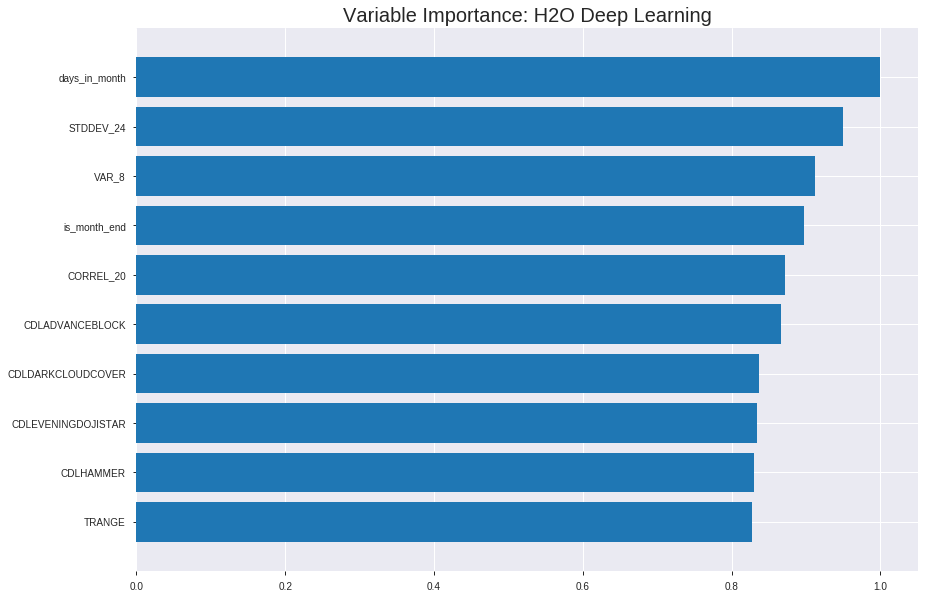

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_154135_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2393328445798954
RMSE: 0.48921656204578295
LogLoss: 0.6688224804713936
Mean Per-Class Error: 0.4532602231377827
AUC: 0.5746084732886095
pr_auc: 0.5903035470465477
Gini: 0.14921694657721907
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39417847523067684: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      198  1981  0.9091   (1981.0/2179.0)
1      39   2097  0.0183   (39.0/2136.0)
Total  237  4078  0.4681   (2020.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394178     0.674928  279
max f2                       0.25354      0.835359  335
max f0point5                 0.489532     0.57074   219
max accuracy                 0.502354     0.543221  205
max precision                0.999003     1         0
max recall                   0.0895773    1         384
max specificity              0.999003     1         0
max absolute_mcc             0.394178     0.159339  279
max min_per_class_accuracy   0.516017     0.240169  188
max mean_per_class_accuracy  0.502354     0.54674   205

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010197                    0.911452           1.92831   1.92831            0.954545         0.953129  0.954545                    0.953129            0.0196629       0.0196629                  92.8307    92.8307
    2        0.0201622                   0.830793           1.55033   1.74149            0.767442         0.877747  0.862069                    0.915871            0.0154494       0.0351124                  55.0333    74.1492
    3        0.0301275                   0.756622           1.69127   1.72488            0.837209         0.7978    0.853846                    0.876817            0.0168539       0.0519663                  69.1273    72.4881
    4        0.0400927                   0.672026           1.36241   1.63479            0.674419         0.715053  0.809249                    0.83661             0.0135768       0.0655431                  36.2414    63.4788
    5        0.0500579                   0.627384           1.26845   1.56186            0.627907         0.647399  0.773148                    0.798943            0.0126404       0.0781835                  26.8454    56.1861
    6        0.100116                    0.539221           1.13165   1.34675            0.560185         0.566669  0.666667                    0.682806            0.0566479       0.134831                   13.1648    34.6754
    7        0.150174                    0.52268            1.01942   1.23764            0.50463          0.530303  0.612654                    0.631972            0.05103         0.185861                   1.9418     23.7642
    8        0.2                         0.516016           1.07114   1.19616            0.530233         0.519036  0.592121                    0.603836            0.0533708       0.239232                   7.11393    19.6161
    9        0.80927                     0.515634           1.00507   1.0523             0.497528         0.515635  0.520905                    0.537433            0.61236         0.851592                   0.507092   5.22962
    10       0.899884                    0.48514            0.991983  1.04622            0.491049         0.501004  0.517899                    0.533764            0.0898876       0.941479                   -0.801747  4.62229
    11       1                           0.00272872         0.584529  1                  0.289352         0.339178  0.495017                    0.514283            0.0585206       1                          -41.5471   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2542772232493369
RMSE: 0.5042590834574394
LogLoss: 0.7096922780691484
Mean Per-Class Error: 0.48907046903761053
AUC: 0.4987341838914352
pr_auc: 0.5195227570219155
Gini: -0.002531632217129598
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11145755859231933: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    585   0.9966   (585.0/587.0)
1      1    645   0.0015   (1.0/646.0)
Total  3    1230  0.4753   (586.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.111458     0.687633   396
max f2                       0.00499213   0.846214   399
max f0point5                 0.412618     0.581351   329
max accuracy                 0.412978     0.532036   327
max precision                0.999445     1          0
max recall                   0.00499213   1          399
max specificity              0.999445     1          0
max absolute_mcc             0.412618     0.0468409  329
max min_per_class_accuracy   0.516521     0.174923   204
max mean_per_class_accuracy  0.412978     0.51093    327

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 51.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain          cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------------  -----------------
    1        0.0105434                   0.856738           0.880924  0.880924           0.461538         0.901191  0.461538                    0.901191            0.00928793      0.00928793                 -11.9076      -11.9076
    2        0.0202758                   0.792819           1.27245   1.06885            0.666667         0.819774  0.56                        0.862111            0.0123839       0.0216718                  27.2446       6.88545
    3        0.0300081                   0.746902           1.4315    1.18647            0.75             0.769472  0.621622                    0.832066            0.0139319       0.0356037                  43.1502       18.647
    4        0.0405515                   0.664004           0.734103  1.06885            0.384615         0.712729  0.56                        0.801038            0.00773994      0.0433437                  -26.5897      6.88545
    5        0.0502839                   0.596282           0.795279  1.0159             0.416667         0.626262  0.532258                    0.767211            0.00773994      0.0510836                  -20.4721      1.59043
    6        0.100568                    0.538025           0.954334  0.985119           0.5              0.556158  0.516129                    0.661684            0.0479876       0.0990712                  -4.56656      -1.48807
    7        0.150041                    0.520523           1.12643   1.03171            0.590164         0.527579  0.540541                    0.617466            0.0557276       0.154799                   12.6427       3.17128
    8        0.845093                    0.515634           0.999991  1.00562            0.523921         0.515745  0.526871                    0.533805            0.695046        0.849845                   -0.000903143  0.562297
    9        0.899432                    0.496993           0.968578  1.00338            0.507463         0.508255  0.525699                    0.532262            0.0526316       0.902477                   -3.14218      0.338491
    10       1                           0.00499213         0.969727  1                  0.508065         0.376805  0.523925                    0.516628            0.0975232       1                          -3.02731      0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:52:16  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 15:52:20  8.175 sec         247 obs/sec       0.272074  1             1174       0.601059         1.00561             -0.445232      0.514295        0.510834           1.33145          0.504751                         0.584758           0.958428              -0.370906        0.518353          0.536897             1.02774            0.468775
    2019-08-24 15:52:55  42.645 sec        638 obs/sec       5.27671   20            22769      0.555572         0.834042            -0.234763      0.541415        0.549953           1.69875          0.4927                           0.553516           0.840979              -0.228332        0.508176          0.529355             0.734103           0.476075
    2019-08-24 15:53:30  1 min 17.982 sec  724 obs/sec       11.3555   43            48999      0.50057          0.695456            -0.00238067    0.56287         0.585539           1.74466          0.482966                         0.509496           0.727642              -0.0407296       0.491166          0.508498             0.880924           0.47283
    2019-08-24 15:54:05  1 min 52.347 sec  797 obs/sec       18.2482   69            78741      0.501671         0.695294            -0.00679575    0.575678        0.595082           1.74466          0.476477                         0.523136           0.749018              -0.0971955       0.50259           0.526963             1.32139            0.470397
    2019-08-24 15:54:39  2 min 26.408 sec  858 obs/sec       25.7425   97            111079     0.489217         0.668822            0.0425735      0.574608        0.590304           1.92831          0.468134                         0.504259           0.709692              -0.0194431       0.498734          0.519523             0.880924           0.475264
    2019-08-24 15:55:14  3 min  1.629 sec  902 obs/sec       33.7098   127           145458     0.488007         0.665634            0.0473003      0.581633        0.614081           1.88239          0.472074                         0.505992           0.713073              -0.02646         0.490243          0.508659             1.46821            0.476075
    2019-08-24 15:55:48  3 min 36.267 sec  945 obs/sec       42.1731   159           181977     0.495712         0.681079            0.0169826      0.594402        0.607027           2.02013          0.462341                         0.518273           0.749608              -0.0768921       0.474523          0.500243             1.02774            0.476075
    2019-08-24 15:56:23  4 min 10.807 sec  973 obs/sec       50.4447   190           217669     0.483594         0.654808            0.0644538      0.613673        0.629048           1.97422          0.450521                         0.514357           0.745456              -0.0606826       0.484616          0.501955             0.880924           0.476075
    2019-08-24 15:56:26 

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
days_in_month       1.0                    1.0                  0.024694273209479048
STDDEV_24           0.95014488697052       0.95014488697052     0.023463137427439613
VAR_8               0.9120829105377197     0.9120829105377197   0.022523224582515287
is_month_end        0.8974499106407166     0.8974499106407166   0.022161873285184413
CORREL_20           0.8717873096466064     0.8717873096466064   0.02152815400497001
---                 ---                    ---                  ---
CDLIDENTICAL3CROWS  0.7691567540168762     0.7691567540168762   0.018993767024608813
CDLINNECK           0.7688108086585999     0.7688108086585999   0.018985224155415988
CDL3WHITESOLDIERS   0.7644150853157043     0.7644150853157043   0.01887667496223324
CDLMORNINGSTAR      0.7615848183631897     0.7615848183631897   0.018806783576852084
CDL3LINESTRIKE      0.7449131011962891     0.7449131011962891   0.018395087638261476


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5348460291734197)

('F1', 0.6563876651982378)

('auc', 0.5075078864353312)

('logloss', 0.707712604611897)

('mean_per_class_error', 0.4753522607781283)

('rmse', 0.5055892178194934)

('mse', 0.2556204571753271)

deeplearning prediction progress: |███████████████████████████████████████| 100%


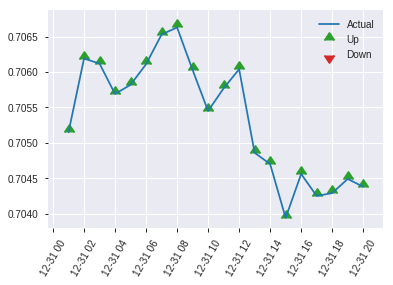


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2556204571753271
RMSE: 0.5055892178194934
LogLoss: 0.707712604611897
Mean Per-Class Error: 0.4753522607781283
AUC: 0.5075078864353312
pr_auc: 0.5160540710774901
Gini: 0.015015772870662358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21319235317809143: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    310  0.9779   (310.0/317.0)
1      2    298  0.0067   (2.0/300.0)
Total  9    608  0.5057   (312.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.213192     0.656388   240
max f2                       0.163607     0.826446   247
max f0point5                 0.274304     0.545723   235
max accuracy                 0.537189     0.534846   64
max precision                0.999168     1          0
max recall                   0.163607     1          247
max specificity              0.999168     1          0
max absolute_mcc             0.927833     0.0929134  4
max min_per_class_accuracy   0.515685     0.236667   139
max mean_per_class_accuracy  0.519545     0.524648   115

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 52.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.917071           1.46905   1.46905            0.714286         0.953179  0.714286                    0.953179            0.0166667       0.0166667                  46.9048    46.9048
    2        0.0210697                   0.872706           1.02833   1.26564            0.5              0.893432  0.615385                    0.925603            0.01            0.0266667                  2.83333    26.5641
    3        0.0307942                   0.803541           1.37111   1.29895            0.666667         0.831093  0.631579                    0.895758            0.0133333       0.04                       37.1111    29.8947
    4        0.0405186                   0.753127           0.685556  1.15173            0.333333         0.776675  0.56                        0.867178            0.00666667      0.0466667                  -31.4444   15.1733
    5        0.0502431                   0.703445           1.37111   1.19419            0.666667         0.736338  0.580645                    0.841854            0.0133333       0.06                       37.1111    19.4194
    6        0.100486                    0.539698           1.19419   1.19419            0.580645         0.589198  0.580645                    0.715526            0.06            0.12                       19.4194    19.4194
    7        0.150729                    0.52643            1.06151   1.14996            0.516129         0.531476  0.55914                     0.654176            0.0533333       0.173333                   6.15054    14.9964
    8        0.200972                    0.518014           0.995161  1.11126            0.483871         0.521433  0.540323                    0.62099             0.05            0.223333                   -0.483871  11.1263
    9        0.823339                    0.515634           0.953351  0.991896           0.463542         0.51568   0.482283                    0.541386            0.593333        0.816667                   -4.66493   -0.810367
    10       0.899514                    0.496549           1.05021   0.996835           0.510638         0.507556  0.484685                    0.538521            0.08            0.896667                   5.02128    -0.316517
    11       1                           0.159905           1.02833   1                  0.5              0.365022  0.486224                    0.521086            0.103333        1                          2.83333    0

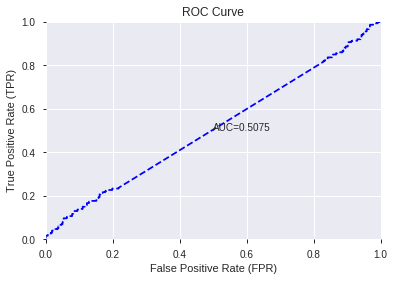

This function is available for GLM models only


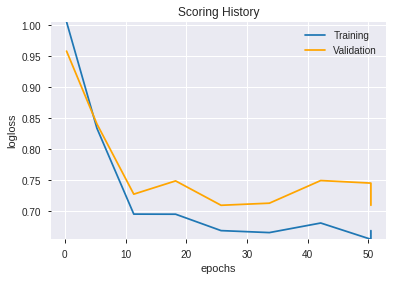

--2019-08-24 16:05:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.135.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.135.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_154135_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_154135_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['days_in_month',
 'STDDEV_24',
 'VAR_8',
 'is_month_end',
 'CORREL_20',
 'CDLADVANCEBLOCK',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'CDLHAMMER',
 'TRANGE',
 'CDLSTALLEDPATTERN',
 'CDLONNECK',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'CDLPIERCING',
 'CDLDOJI',
 'VAR_12',
 'CORREL_8',
 'DIV',
 'CDLDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'is_quarter_start',
 'CDLTASUKIGAP',
 'CDLHIKKAKEMOD',
 'CDLRICKSHAWMAN',
 'SUB',
 'CDLSEPARATINGLINES',
 'CDLHANGINGMAN',
 'CDLGAPSIDESIDEWHITE',
 'is_month_start',
 'CDLMATCHINGLOW',
 'CDL3BLACKCROWS',
 'CDLHOMINGPIGEON',
 'CDLSTICKSANDWICH',
 'CDLTHRUSTING',
 'CDLTAKURI',
 'CDLEVENINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLINVERTEDHAMMER',
 'CORREL_14',
 'CDLHARAMICROSS',
 'CDLDRAGONFLYDOJI',
 'CDLRISEFALL3METHODS',
 'CORREL_12',
 'CDLMORNINGDOJISTAR',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGSTAR',
 'CDL3LINESTRIKE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_160601_model_1  0.504453  0.692236              0.492292  0.499546  0.249546

variable  relative_importance  scaled_importance  percentage
0    CDLSEPARATINGLINES             0.008680           1.000000    0.057964
1   CDLRISEFALL3METHODS             0.006709           0.772961    0.044804
2             CORREL_14             0.006662           0.767562    0.044491
3    CDLIDENTICAL3CROWS             0.006417           0.739321    0.042854
4         CDLHANGINGMAN             0.006387           0.735835    0.042652
5     CDLINVERTEDHAMMER             0.006037           0.695487    0.040313
6     CDL3WHITESOLDIERS             0.005572           0.641995    0.037212
7             CDLONNECK             0.005381           0.619907    0.035932
8        is_month_start             0.005222           0.601580    0.034870
9             CDLHAMMER             0.005055           0.582421    0.033759
10       CDLMORNINGSTAR             0.004599           0.529879    0.030714
11        CDLHIKKAKEMOD             0.004592           0.528998    0.030663
12       CDLRICKSHAWMAN             0.004337           0.499697    0.028964
13      CDLHOMINGPIGEON             0.004141           0.477090    0.027654
14   CDLEVENINGDOJISTAR             0.004042           0.465624    0.026989
15     CDLSTICKSANDWICH             0.003874           0.446310    0.025870
16       CDLMATCHINGLOW             0.003835           0.441864    0.025612
17         CDLTASUKIGAP             0.003745           0.431468    0.025009
18            CDLINNECK             0.003540           0.407876    0.023642
19   CDLMORNINGDOJISTAR             0.003539           0.407726    0.023633
20  CDLXSIDEGAP3METHODS             0.003318           0.382263    0.022157
21            CORREL_12             0.003266           0.376284    0.021811
22        days_in_month             0.003188           0.367227    0.021286
23       CDLHARAMICROSS             0.003140           0.361724    0.020967
24    CDLDARKCLOUDCOVER             0.003140           0.361696    0.020965
25     is_quarter_start             0.003027           0.348688    0.020211
26            STDDEV_24             0.003019           0.347820    0.020161
27                VAR_8             0.002274           0.261926    0.015182
28          CDLPIERCING             0.002230           0.256938    0.014893
29             CORREL_8             0.002187           0.251969    0.014605
30       CDL3BLACKCROWS             0.001963           0.226185    0.013111
31          CDLDOJISTAR             0.001599           0.184174    0.010675
32       CDL3LINESTRIKE             0.001532           0.176510    0.010231
33  CDLGAPSIDESIDEWHITE             0.001409           0.162352    0.009411
34         CDLTHRUSTING             0.001407           0.162098    0.009396
35    CDLSTALLEDPATTERN             0.001229           0.141619    0.008209
36       CDLEVENINGSTAR             0.001203           0.138539    0.008030
37                  DIV             0.000942           0.108564    0.006293
38            CORREL_20             0.000929           0.107063    0.006206
39               TRANGE             0.000900           0.103717    0.006012
40                  SUB             0.000884           0.101898    0.005906
41            CDLTAKURI             0.000868           0.100016    0.005797
42         is_month_end             0.000776           0.089390    0.005181
43    CDLLONGLEGGEDDOJI             0.000720           0.082975    0.004810
44               VAR_12             0.000609           0.070185    0.004068
45              CDLDOJI             0.000516           0.059467    0.003447
46      CDLADVANCEBLOCK             0.000370           0.042592    0.002469
47     CDLDRAGONFLYDOJI             0.000349           0.040263    0.002334
48    CDLGRAVESTONEDOJI             0.000239           0.027482    0.001593
49      CDLSHOOTINGSTAR             0.000147           0.016965    0.000983

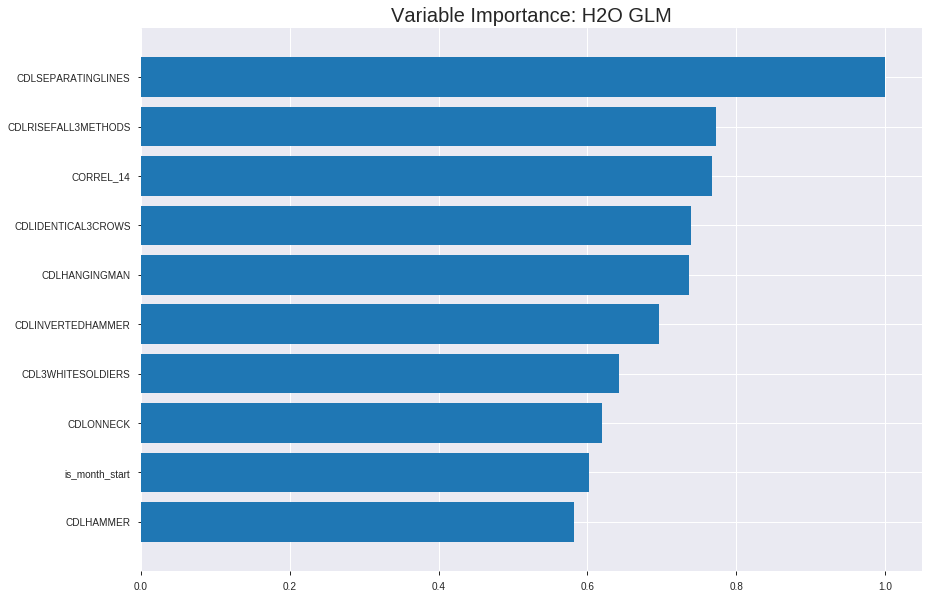

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_160601_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24937373214707442
RMSE: 0.4993733394436215
LogLoss: 0.6918908601202322
Null degrees of freedom: 4314
Residual degrees of freedom: 4264
Null deviance: 5981.431655925498
Residual deviance: 5971.018122837604
AIC: 6073.018122837604
AUC: 0.5434061169522494
pr_auc: 0.5359479103041322
Gini: 0.08681223390449877
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4624631481956489: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      21   2158  0.9904   (2158.0/2179.0)
1      4    2132  0.0019   (4.0/2136.0)
Total  25   4290  0.501    (2162.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.462463     0.663554   376
max f2                       0.447683     0.831193   389
max f0point5                 0.493565     0.555927   230
max accuracy                 0.495626     0.534878   174
max precision                0.611945     1          0
max recall                   0.447683     1          389
max specificity              0.611945     1          0
max absolute_mcc             0.493565     0.0710481  230
max min_per_class_accuracy   0.495626     0.533708   174
max mean_per_class_accuracy  0.495626     0.534867   174

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.516951           1.5151    1.5151             0.75             0.528894  0.75                        0.528894            0.0154494       0.0154494                  51.5098   51.5098
    2        0.0201622                   0.505567           1.36241   1.43963            0.674419         0.509539  0.712644                    0.519328            0.0135768       0.0290262                  36.2414   43.9634
    3        0.0301275                   0.504313           0.986576  1.28978            0.488372         0.504862  0.638462                    0.514543            0.00983146      0.0388577                  -1.34244  28.9776
    4        0.0400927                   0.502635           1.08054   1.23777            0.534884         0.503546  0.612717                    0.51181             0.0107678       0.0496255                  8.05352   23.7768
    5        0.0500579                   0.501126           1.08054   1.20647            0.534884         0.501748  0.597222                    0.509807            0.0107678       0.0603933                  8.05352   20.6467
    6        0.100116                    0.497458           1.02877   1.11762            0.509259         0.498333  0.553241                    0.50407             0.0514981       0.111891                   2.87705   11.7619
    7        0.150174                    0.497003           1.10359   1.11294            0.546296         0.497215  0.550926                    0.501785            0.0552434       0.167135                   10.359    11.2943
    8        0.2                         0.496705           1.04295   1.09551            0.516279         0.496852  0.542294                    0.500556            0.0519663       0.219101                   4.29514   9.55056
    9        0.300116                    0.496275           1.05215   1.08104            0.520833         0.496473  0.535135                    0.499194            0.105337        0.324438                   5.21516   8.10431
    10       0.4                         0.495954           1.02647   1.06742            0.508121         0.496118  0.528389                    0.498426            0.102528        0.426966                   2.64703   6.74157
    11       0.500116                    0.495596           1.07553   1.06904            0.532407         0.495782  0.529194                    0.497896            0.107678        0.534644                   7.55328   6.90406
    12       0.6                         0.495204           0.942103  1.04791            0.466357         0.495407  0.518733                    0.497482            0.0941011       0.628745                   -5.78971  4.79089
    13       0.699884                    0.49467            0.970225  1.03682            0.480278         0.494949  0.513245                    0.497121            0.0969101       0.725655                   -2.97746  3.68222
    14       0.8                         0.493815           0.982008  1.02996            0.486111         0.494282  0.509849                    0.496765            0.0983146       0.82397                    -1.79918  2.99625
    15       0.899884                    0.492267           0.909293  1.01657            0.450116         0.493237  0.503219                    0.496374            0.090824        0.914794                   -9.07067  1.65687
    16       1                           0.411492           0.851074  1                  0.421296         0.482825  0.495017                    0.495017         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2503945987085471
RMSE: 0.5003944431231696
LogLoss: 0.6939401454522846
Null degrees of freedom: 1232
Residual degrees of freedom: 1182
Null deviance: 1710.5993345457732
Residual deviance: 1711.2563986853338
AIC: 1813.2563986853338
AUC: 0.4829787290151423
pr_auc: 0.5154904814263876
Gini: -0.034042541969715345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4320898100836602: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    587   1        (587.0/587.0)
1      0    646   0        (0.0/646.0)
Total  0    1233  0.4761   (587.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.43209      0.6876     399
max f2                       0.43209      0.846214   399
max f0point5                 0.43209      0.579061   399
max accuracy                 0.483208     0.525547   360
max precision                0.531549     0.833333   5
max recall                   0.43209      1          399
max specificity              0.61295      0.998296   0
max absolute_mcc             0.497386     0.0542253  89
max min_per_class_accuracy   0.495625     0.483816   186
max mean_per_class_accuracy  0.496014     0.509819   161

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.51614            1.32139   1.32139            0.692308         0.53822   0.692308                    0.53822             0.0139319       0.0139319                  32.1386   32.1386
    2        0.0202758                   0.505226           1.11339   1.22155            0.583333         0.508339  0.64                        0.523877            0.0108359       0.0247678                  11.339    22.1548
    3        0.0300081                   0.504325           0.795279  1.0833             0.416667         0.504698  0.567568                    0.517657            0.00773994      0.0325077                  -20.4721  8.32985
    4        0.0405515                   0.503833           0.440462  0.916161           0.230769         0.504121  0.48                        0.514138            0.00464396      0.0371517                  -55.9538  -8.3839
    5        0.0502839                   0.502059           0.954334  0.923549           0.5              0.503107  0.483871                    0.512003            0.00928793      0.0464396                  -4.56656  -7.64506
    6        0.100568                    0.497342           0.831194  0.877372           0.435484         0.498552  0.459677                    0.505277            0.0417957       0.0882353                  -16.8806  -12.2628
    7        0.150041                    0.496876           1.00127   0.918224           0.52459          0.497077  0.481081                    0.502573            0.0495356       0.137771                   0.126884  -8.17756
    8        0.200324                    0.496631           1.10826   0.965925           0.580645         0.496741  0.506073                    0.501109            0.0557276       0.193498                   10.8259   -3.40745
    9        0.300081                    0.496273           1.11727   1.01624            0.585366         0.496459  0.532432                    0.499563            0.111455        0.304954                   11.727    1.62371
    10       0.399838                    0.495951           1.02416   1.01821            0.536585         0.496121  0.533469                    0.498705            0.102167        0.407121                   2.41637   1.82148
    11       0.500406                    0.495605           0.785017  0.971348           0.41129          0.495771  0.508914                    0.498115            0.0789474       0.486068                   -21.4983  -2.86516
    12       0.600162                    0.495305           0.946576  0.967231           0.495935         0.495454  0.506757                    0.497673            0.0944272       0.580495                   -5.34245  -3.27692
    13       0.699919                    0.494909           1.02416   0.975345           0.536585         0.495126  0.511008                    0.49731             0.102167        0.682663                   2.41637   -2.46548
    14       0.799676                    0.494329           1.03968   0.983371           0.544715         0.494683  0.515213                    0.496982            0.103715        0.786378                   3.96813   -1.66291
    15       0.899432                    0.49275            1.10175   0.996501           0.577236         0.493735  0.522092                    0.496622            0.109907        0.896285                   10.1752   -0.349937
    16       1                           0.43209            1.0313    1                  0.540323         0.482331  0.523925                    0.49518


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 16:06:02  0.000 sec   2            1.7       51            1.38378           1.38788
    2019-08-24 16:06:02  0.013 sec   4            1         51            1.38276           1.38826
    2019-08-24 16:06:02  0.027 sec   6            0.64      51            1.38152           1.38888
    2019-08-24 16:06:02  0.041 sec   8            0.4       51            1.38015           1.38985
    2019-08-24 16:06:02  0.056 sec   10           0.25      51            1.37881           1.39121

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5429497568881686)

('F1', 0.6563876651982378)

('auc', 0.504453207150368)

('logloss', 0.6922361863838992)

('mean_per_class_error', 0.4651735015772871)

('rmse', 0.49954577731312316)

('mse', 0.24954598363137245)

glm prediction progress: |████████████████████████████████████████████████| 100%


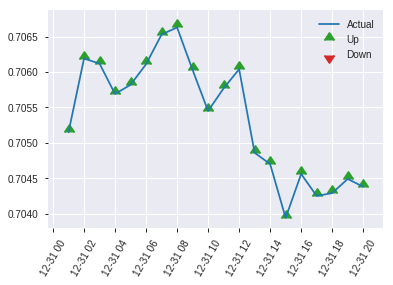


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24954598363137245
RMSE: 0.49954577731312316
LogLoss: 0.6922361863838992
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.0660663376912
Residual deviance: 854.2194539977314
AIC: 956.2194539977314
AUC: 0.504453207150368
pr_auc: 0.5046491463331947
Gini: 0.00890641430073602
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4654824036292197: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    310  0.9779   (310.0/317.0)
1      2    298  0.0067   (2.0/300.0)
Total  9    608  0.5057   (312.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.465482     0.656388   390
max f2                       0.448502     0.825537   399
max f0point5                 0.475406     0.54559    376
max accuracy                 0.496736     0.54295    93
max precision                0.575358     1          0
max recall                   0.448502     1          399
max specificity              0.575358     1          0
max absolute_mcc             0.496736     0.0876108  93
max min_per_class_accuracy   0.495922     0.486667   184
max mean_per_class_accuracy  0.496654     0.534826   98

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.517042           1.17524   1.17524            0.571429         0.531223  0.571429                    0.531223            0.0133333       0.0133333                  17.5238    17.5238
    2        0.0210697                   0.505082           1.37111   1.26564            0.666667         0.509322  0.615385                    0.521114            0.0133333       0.0266667                  37.1111    26.5641
    3        0.0307942                   0.504139           1.02833   1.1907             0.5              0.504662  0.578947                    0.515919            0.01            0.0366667                  2.83333    19.0702
    4        0.0405186                   0.501321           1.71389   1.31627            0.833333         0.502905  0.64                        0.512796            0.0166667       0.0533333                  71.3889    31.6267
    5        0.0502431                   0.498285           1.02833   1.26054            0.5              0.500026  0.612903                    0.510324            0.01            0.0633333                  2.83333    26.0538
    6        0.100486                    0.497431           1.06151   1.16102            0.516129         0.497747  0.564516                    0.504036            0.0533333       0.116667                   6.15054    16.1022
    7        0.150729                    0.496929           0.995161  1.10573            0.483871         0.497189  0.537634                    0.501753            0.05            0.166667                   -0.483871  10.5735
    8        0.200972                    0.49667            1.39323   1.17761            0.677419         0.496807  0.572581                    0.500517            0.07            0.236667                   39.3226    17.7608
    9        0.299838                    0.496404           0.674317  1.01166            0.327869         0.496536  0.491892                    0.499204            0.0666667       0.303333                   -32.5683   1.16577
    10       0.400324                    0.496144           0.829301  0.965884           0.403226         0.496284  0.469636                    0.498471            0.0833333       0.386667                   -17.0699   -3.41161
    11       0.50081                     0.495914           1.02833   0.978414           0.5              0.496041  0.475728                    0.497984            0.103333        0.49                       2.83333    -2.15858
    12       0.599676                    0.495676           1.04519   0.989423           0.508197         0.495807  0.481081                    0.497625            0.103333        0.593333                   4.51913    -1.05766
    13       0.700162                    0.495371           0.928817  0.980725           0.451613         0.495511  0.476852                    0.497321            0.0933333       0.686667                   -7.11828   -1.92747
    14       0.799028                    0.494793           1.07891   0.992874           0.52459          0.495125  0.482759                    0.49705             0.106667        0.793333                   7.89071    -0.712644
    15       0.899514                    0.492654           1.06151   1.00054            0.516129         0.493917  0.486486                    0.4967              0.106667        0.9                        6.15054    0.0540541
    16       1                           0.448502           0.995161  1                  0.483871         0.478264  0.486224            

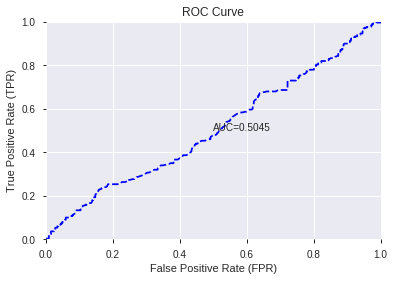

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


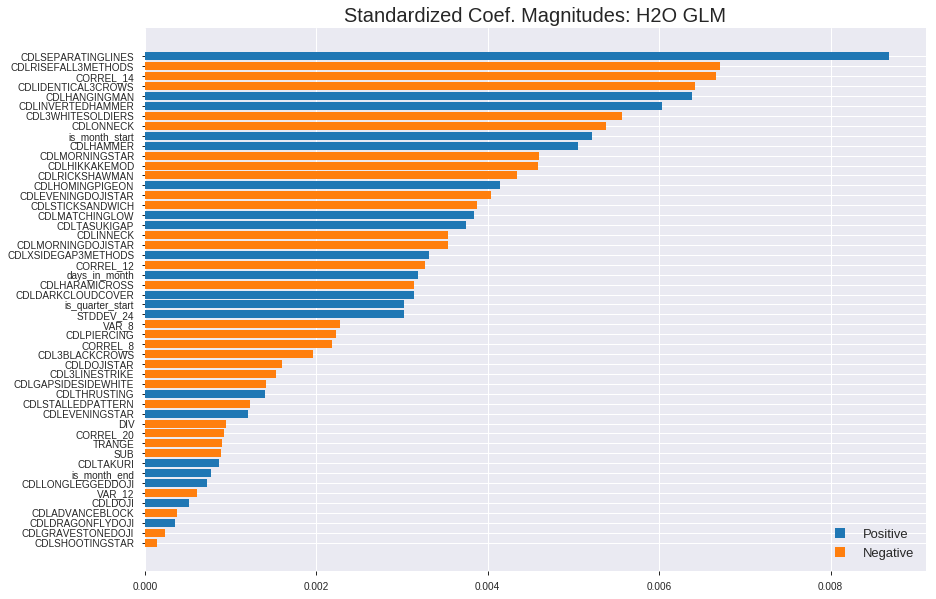

'log_likelihood'
--2019-08-24 16:06:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_160601_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_160601_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLSEPARATINGLINES',
 'CDLRISEFALL3METHODS',
 'CORREL_14',
 'CDLIDENTICAL3CROWS',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDL3WHITESOLDIERS',
 'CDLONNECK',
 'is_month_start',
 'CDLHAMMER',
 'CDLMORNINGSTAR',
 'CDLHIKKAKEMOD',
 'CDLRICKSHAWMAN',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDLMATCHINGLOW',
 'CDLTASUKIGAP',
 'CDLINNECK',
 'CDLMORNINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'CORREL_12',
 'days_in_month',
 'CDLHARAMICROSS',
 'CDLDARKCLOUDCOVER',
 'is_quarter_start',
 'STDDEV_24',
 'VAR_8',
 'CDLPIERCING',
 'CORREL_8',
 'CDL3BLACKCROWS',
 'CDLDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'DIV',
 'CORREL_20',
 'TRANGE',
 'SUB',
 'CDLTAKURI',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'VAR_12',
 'CDLDOJI',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR']

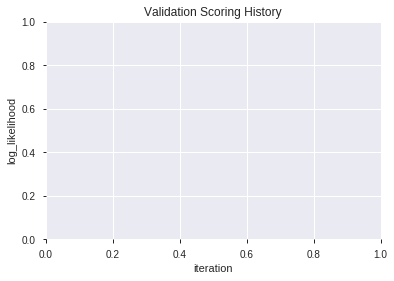

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_160709_model_7  0.536703  0.696239              0.495268  0.501419  0.251421
1               XGBoost_1_AutoML_20190824_160709  0.521588  0.697299              0.489227  0.502030  0.252034
2  XGBoost_grid_1_AutoML_20190824_160709_model_4  0.521009  0.693068              0.490536  0.499962  0.249962
3  XGBoost_grid_1_AutoML_20190824_160709_model_2  0.514059  0.693206              0.492203  0.500038  0.250038
4  XGBoost_grid_1_AutoML_20190824_160709_model_6  0.510741  0.695577              0.498423  0.501190  0.251192
5               XGBoost_3_AutoML_20190824_160709  0.509022  0.696032              0.493691  0.501431  0.251433
6  XGBoost_grid_1_AutoML_20190824_160709_model_5  0.508644  0.716625              0.493691  0.510818  0.260935
7               XGBoost_2_AutoML_20190824_160709  0.500142  0.701211              0.482918  0.503975  0.253991
8  XGBoost_grid_1_AutoML_20190824_160709_model_1  0.495873  0.698180              0.496845  0.502455  0.252461
9  XGBoost_grid_1_AutoML_20190824_160709_model_3  0.489106  0.698867              0.496845  0.502829  0.252837

variable  relative_importance  scaled_importance  percentage
0              VAR_12          1713.697510           1.000000    0.202000
1           STDDEV_24          1689.850952           0.986085    0.199189
2               VAR_8          1635.343872           0.954278    0.192764
3              TRANGE          1038.885864           0.606225    0.122457
4                 DIV          1000.080566           0.583581    0.117883
5                 SUB           571.151062           0.333286    0.067324
6           CORREL_20           307.814117           0.179620    0.036283
7       days_in_month           207.249878           0.120937    0.024429
8             CDLDOJI            69.550102           0.040585    0.008198
9           CORREL_14            68.495056           0.039969    0.008074
10     CDLRICKSHAWMAN            58.144478           0.033929    0.006854
11  CDLLONGLEGGEDDOJI            22.759907           0.013281    0.002683
12      CDLHANGINGMAN            21.880159           0.012768    0.002579
13  CDLGRAVESTONEDOJI            20.817474           0.012148    0.002454
14     is_month_start            16.594395           0.009683    0.001956
15       is_month_end            14.147827           0.008256    0.001668
16          CDLHAMMER             9.083696           0.005301    0.001071
17     CDLHARAMICROSS             8.274749           0.004829    0.000975
18          CDLTAKURI             3.799900           0.002217    0.000448
19    CDLADVANCEBLOCK             3.175496           0.001853    0.000374
20   CDLDRAGONFLYDOJI             2.867902           0.001674    0.000338

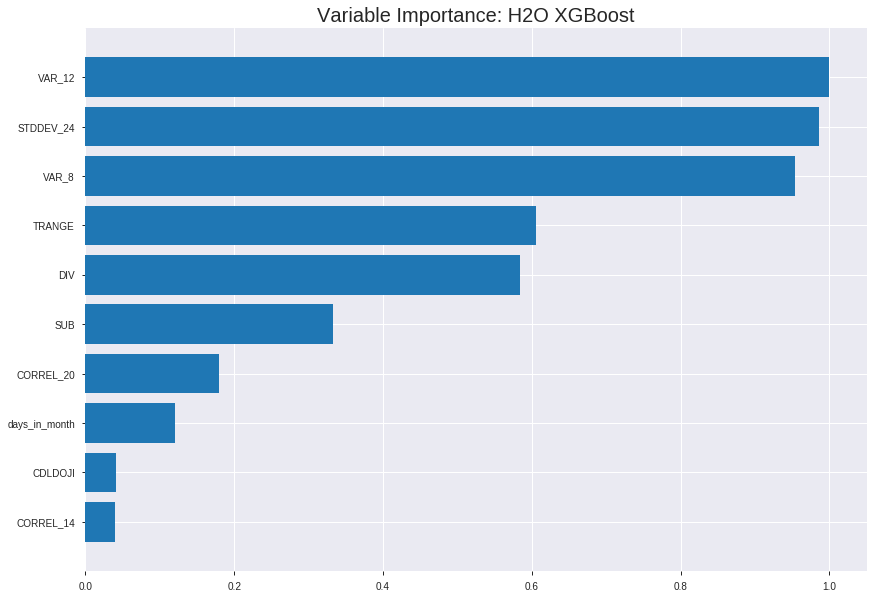

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_160709_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2103730574212903
RMSE: 0.4586644279004971
LogLoss: 0.612224899434762
Mean Per-Class Error: 0.2514989222971057
AUC: 0.8287763001617413
pr_auc: 0.826710078634297
Gini: 0.6575526003234826
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4753764679557399: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1403  776   0.3561   (776.0/2179.0)
1      343   1793  0.1606   (343.0/2136.0)
Total  1746  2569  0.2593   (1119.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475376     0.762168  231
max f2                       0.416271     0.853719  301
max f0point5                 0.52772      0.762702  163
max accuracy                 0.484653     0.747856  220
max precision                0.763812     1         0
max recall                   0.335302     1         367
max specificity              0.763812     1         0
max absolute_mcc             0.483842     0.500871  221
max min_per_class_accuracy   0.49752      0.742509  204
max mean_per_class_accuracy  0.483842     0.748501  221

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.693538           2.02013   2.02013            1                0.715552  1                           0.715552            0.0205993       0.0205993                  102.013   102.013
    2        0.0201622                   0.670816           1.97315   1.99691            0.976744         0.680907  0.988506                    0.698429            0.0196629       0.0402622                  97.3151   99.6911
    3        0.0301275                   0.654982           1.97315   1.98905            0.976744         0.663316  0.984615                    0.686814            0.0196629       0.0599251                  97.3151   98.9052
    4        0.0400927                   0.641932           1.97315   1.9851             0.976744         0.648222  0.982659                    0.677222            0.0196629       0.079588                   97.3151   98.51
    5        0.0500579                   0.632669           2.02013   1.99207            1                0.63767   0.986111                    0.669348            0.0201311       0.0997191                  102.013   99.2074
    6        0.100116                    0.603015           1.81438   1.90323            0.898148         0.616325  0.94213                     0.642837            0.090824        0.190543                   81.4377   90.3225
    7        0.150174                    0.58075            1.76761   1.85802            0.875            0.590999  0.919753                    0.625557            0.0884831       0.279026                   76.7615   85.8022
    8        0.2                         0.565267           1.60671   1.79541            0.795349         0.572355  0.88876                     0.612303            0.0800562       0.359082                   60.6709   79.5412
    9        0.300116                    0.539213           1.51977   1.70346            0.752315         0.551775  0.843243                    0.592112            0.152154        0.511236                   51.9775   70.3462
    10       0.4                         0.516788           1.29832   1.60229            0.642691         0.527963  0.793163                    0.576093            0.129682        0.640918                   29.8321   60.2294
    11       0.500116                    0.496453           1.03345   1.48842            0.511574         0.506612  0.736793                    0.562184            0.103464        0.744382                   3.34467   48.8419
    12       0.6                         0.47361            0.9796    1.40371            0.484919         0.485763  0.694863                    0.549462            0.0978464       0.842228                   -2.04005  40.3714
    13       0.699884                    0.450481           0.660878  1.2977             0.327146         0.462491  0.642384                    0.53705             0.0660112       0.90824                    -33.9122  29.77
    14       0.8                         0.425086           0.491004  1.19675            0.243056         0.438033  0.59241                     0.524658            0.0491573       0.957397                   -50.8996  19.6746
    15       0.899884                    0.384917           0.276538  1.09461            0.136891         0.406633  0.541849                    0.511558            0.0276217       0.985019                   -72.3462  9.46062
    16       1                           0.222356           0.149639  1                  0.0740741        0.348634  0.495017                    0.495247            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2581580200528591
RMSE: 0.5080925309949548
LogLoss: 0.7098765609028707
Mean Per-Class Error: 0.4905683514327456
AUC: 0.4784481621932373
pr_auc: 0.5210912513354904
Gini: -0.04310367561352535
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28588762879371643: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    586   0.9983   (586.0/587.0)
1      0    646   0        (0.0/646.0)
Total  1    1232  0.4753   (586.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.285888     0.687966   398
max f2                       0.285888     0.846436   398
max f0point5                 0.285888     0.579476   398
max accuracy                 0.285888     0.524736   398
max precision                0.717982     1          0
max recall                   0.285888     1          398
max specificity              0.717982     1          0
max absolute_mcc             0.419538     0.0650183  314
max min_per_class_accuracy   0.495293     0.48552    202
max mean_per_class_accuracy  0.616406     0.509432   41

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.667311           1.46821   1.46821            0.769231         0.688738  0.769231                    0.688738            0.0154799       0.0154799                  46.8207    46.8207
    2        0.0202758                   0.644652           1.11339   1.29789            0.583333         0.65855   0.68                        0.674248            0.0108359       0.0263158                  11.339     29.7895
    3        0.0300081                   0.634076           0.795279  1.13488            0.416667         0.639986  0.594595                    0.663136            0.00773994      0.0340557                  -20.4721   13.4884
    4        0.0405515                   0.627017           1.17457   1.1452             0.615385         0.630841  0.6                         0.654739            0.0123839       0.0464396                  17.4565    14.5201
    5        0.0502839                   0.620414           0.954334  1.10826            0.5              0.623251  0.580645                    0.648645            0.00928793      0.0557276                  -4.56656   10.8259
    6        0.100568                    0.59282            0.954334  1.0313             0.5              0.606017  0.540323                    0.627331            0.0479876       0.103715                   -4.56656   3.12968
    7        0.150041                    0.575587           0.844821  0.96981            0.442623         0.583716  0.508108                    0.612949            0.0417957       0.145511                   -15.5179   -3.01899
    8        0.200324                    0.558768           0.923549  0.958198           0.483871         0.567024  0.502024                    0.601422            0.0464396       0.19195                    -7.64506   -4.18019
    9        0.300081                    0.532641           0.962093  0.959493           0.504065         0.54528   0.502703                    0.582758            0.0959752       0.287926                   -3.79068   -4.05071
    10       0.399838                    0.515533           0.931058  0.952399           0.487805         0.523402  0.498986                    0.567949            0.0928793       0.380805                   -6.89421   -4.76014
    11       0.500406                    0.495398           1.06208   0.974442           0.556452         0.505919  0.510535                    0.555483            0.106811        0.487616                   6.20818    -2.55581
    12       0.600162                    0.476399           0.962093  0.972389           0.504065         0.486217  0.509459                    0.54397             0.0959752       0.583591                   -3.79068   -2.76107
    13       0.699919                    0.453645           0.993128  0.975345           0.520325         0.465483  0.511008                    0.532783            0.0990712       0.682663                   -0.687155  -2.46548
    14       0.799676                    0.43107            1.08623   0.989178           0.569106         0.4435    0.518256                    0.521646            0.108359        0.791022                   8.62342    -1.08218
    15       0.899432                    0.403281           0.977611  0.987895           0.512195         0.418724  0.517583                    0.510231            0.0975232       0.888545                   -2.23892   -1.21047
    16       1                           0.270084           1.10826   1                  0.580645         0.367525  0.523925           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:07:24  10.052 sec  0                  0.5              0.693147            0.5             0                  1                0.504983                         0.5                0.693147              0.5               0                    1                  0.476075
    2019-08-24 16:07:25  10.200 sec  5                  0.493501         0.680215            0.696352        0.683475           1.79057          0.389108                         0.500857           0.694865              0.484268          0.514579             1.32139            0.475264
    2019-08-24 16:07:25  10.302 sec  10                 0.488899         0.671117            0.724299        0.717416           1.74466          0.358517                         0.501517           0.696199              0.483423          0.514604             0.880924           0.476075
    2019-08-24 16:07:25  10.416 sec  15                 0.483165         0.659845            0.752604        0.74462            1.92831          0.32445                          0.502513           0.698213              0.479202          0.514913             1.02774            0.476075
    2019-08-24 16:07:25  10.527 sec  20                 0.478237         0.650202            0.772764        0.766318           1.97422          0.325145                         0.503482           0.700202              0.481921          0.518258             1.46821            0.475264
    2019-08-24 16:07:25  10.646 sec  25                 0.474362         0.642618            0.782796        0.777484           2.02013          0.316338                         0.505037           0.703412              0.474892          0.515304             1.32139            0.476075
    2019-08-24 16:07:25  10.757 sec  30                 0.471201         0.636446            0.791868        0.7887             1.97422          0.291078                         0.50562            0.704632              0.475558          0.517569             1.32139            0.476075
    2019-08-24 16:07:25  10.876 sec  35                 0.467732         0.629741            0.804532        0.798396           1.97422          0.274392                         0.505859           0.705118              0.476582          0.521523             1.46821            0.475264
    2019-08-24 16:07:25  10.998 sec  40                 0.463859         0.622228            0.813099        0.809692           1.97422          0.282735                         0.507323           0.708187              0.47427           0.518701             1.32139            0.475264
    2019-08-24 16:07:25  11.111 sec  45                 0.461585         0.617854            0.821022        0.819009           1.97422          0.270684                         0.507938           0.709485              0.473054          0.517792             1.46821            0.475264
    2019-08-24 16:07:26  11.235 sec  50                 0.458664         0.612225            0.828776        0.82671            2.02013          0.259328                         0.508093           0.709877              0.478448          0.521091             1.46821            0.475264

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ----------------------
VAR_12            1713.697509765625      1.0                    0.20199966842697847
STDDEV_24         1689.8509521484375     0.9860847334600791     0.1991887891998414
VAR_8             1635.3438720703125     0.9542780232515897     0.19276384428397356
TRANGE            1038.8858642578125     0.6062247615682749     0.12245720082901561
DIV               1000.08056640625       0.5835805681616627     0.11788308126908358
---               ---                    ---                    ---
CDLHAMMER         9.083696365356445      0.005300641632255615   0.0010707278521658722
CDLHARAMICROSS    8.274748802185059      0.004828593584941814   0.0009753743031268817
CDLTAKURI         3.7998995780944824     0.002217368909297288   0.00044790778445834306
CDLADVANCEBLOCK   3.1754963397979736     0.001853008667925457   0.00037430713651325935
CDLDRAGONFLYDOJI  2.8679022789001465     0.0016735172120850995  0.0003380499219480315


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5510534846029174)

('F1', 0.6564551422319475)

('auc', 0.5367034700315457)

('logloss', 0.6962393968101498)

('mean_per_class_error', 0.44522082018927445)

('rmse', 0.5014190620957428)

('mse', 0.25142107583297435)

xgboost prediction progress: |████████████████████████████████████████████| 100%


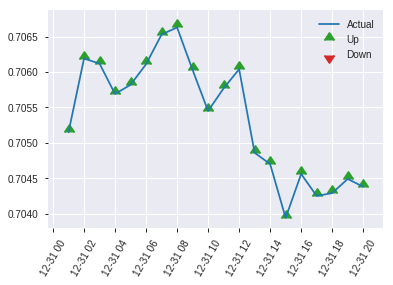


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25142107583297435
RMSE: 0.5014190620957428
LogLoss: 0.6962393968101498
Mean Per-Class Error: 0.44522082018927445
AUC: 0.5367034700315457
pr_auc: 0.5023234416315644
Gini: 0.07340694006309145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2973654568195343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    314  0.9905   (314.0/317.0)
1      0    300  0        (0.0/300.0)
Total  3    614  0.5089   (314.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297365     0.656455  396
max f2                       0.297365     0.826902  396
max f0point5                 0.472862     0.555258  247
max accuracy                 0.472862     0.551053  247
max precision                0.633662     0.607143  24
max recall                   0.297365     1         396
max specificity              0.723462     0.996845  0
max absolute_mcc             0.472862     0.113656  247
max min_per_class_accuracy   0.500257     0.523333  198
max mean_per_class_accuracy  0.472862     0.554779  247

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.678676           0.881429  0.881429           0.428571         0.696847  0.428571                    0.696847            0.01            0.01                       -11.8571   -11.8571
    2        0.0210697                   0.65813            0.685556  0.791026           0.333333         0.668894  0.384615                    0.683946            0.00666667      0.0166667                  -31.4444   -20.8974
    3        0.0307942                   0.645783           1.02833   0.865965           0.5              0.653143  0.421053                    0.674219            0.01            0.0266667                  2.83333    -13.4035
    4        0.0405186                   0.637341           2.05667   1.15173            1                0.642878  0.56                        0.666697            0.02            0.0466667                  105.667    15.1733
    5        0.0502431                   0.624295           1.37111   1.19419            0.666667         0.632816  0.580645                    0.660139            0.0133333       0.06                       37.1111    19.4194
    6        0.100486                    0.600841           0.796129  0.995161           0.387097         0.611918  0.483871                    0.636028            0.04            0.1                        -20.3871   -0.483871
    7        0.150729                    0.582581           1.06151   1.01728            0.516129         0.592535  0.494624                    0.621531            0.0533333       0.153333                   6.15054    1.7276
    8        0.200972                    0.562712           1.12785   1.04492            0.548387         0.570978  0.508065                    0.608892            0.0566667       0.21                       12.7849    4.49194
    9        0.299838                    0.539935           1.07891   1.05613            0.52459          0.549867  0.513514                    0.58943             0.106667        0.316667                   7.89071    5.61261
    10       0.400324                    0.521462           0.961989  1.0325             0.467742         0.531454  0.502024                    0.574877            0.0966667       0.413333                   -3.80108   3.24966
    11       0.50081                     0.498672           1.09468   1.04497            0.532258         0.50846   0.508091                    0.561551            0.11            0.523333                   9.46774    4.4973
    12       0.599676                    0.47834            1.24749   1.07836            0.606557         0.488261  0.524324                    0.549468            0.123333        0.646667                   24.7486    7.83604
    13       0.700162                    0.461245           0.995161  1.06642            0.483871         0.469429  0.518519                    0.537981            0.1             0.746667                   -0.483871  6.64198
    14       0.799028                    0.440313           0.80918   1.03459            0.393443         0.450932  0.503043                    0.52721             0.08            0.826667                   -19.082    3.45909
    15       0.899514                    0.404295           0.729785  1.00054            0.354839         0.424364  0.486486                    0.515721            0.0733333       0.9                        -27.0215   0.0540541
    16       1                           0.225772           0.995161  1                  0.483871         0.370523  0.486224               

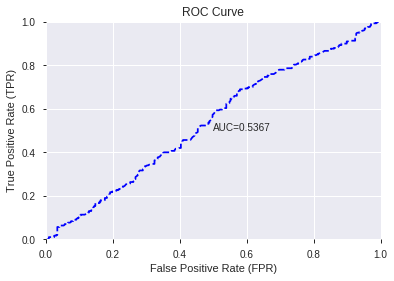

This function is available for GLM models only


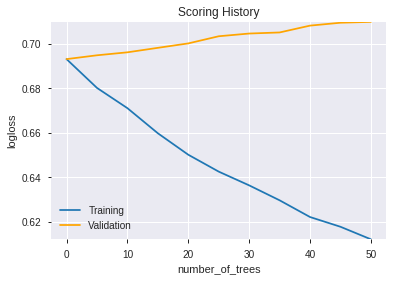

--2019-08-24 16:07:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.240
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_160709_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_160709_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['VAR_12',
 'STDDEV_24',
 'VAR_8',
 'TRANGE',
 'DIV',
 'SUB',
 'CORREL_20',
 'days_in_month',
 'CDLDOJI',
 'CORREL_14',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLHANGINGMAN',
 'CDLGRAVESTONEDOJI',
 'is_month_start',
 'is_month_end',
 'CDLHAMMER',
 'CDLHARAMICROSS',
 'CDLTAKURI',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 939] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


1

['BOP']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_160835_model_3  0.519012  0.693136              0.495268  0.499993  0.249993
1  DeepLearning_grid_1_AutoML_20190824_160835_model_5  0.518591  0.697515              0.495268  0.502174  0.252179
2  DeepLearning_grid_1_AutoML_20190824_160835_model_1  0.518486  0.698195              0.495268  0.502462  0.252468
3  DeepLearning_grid_1_AutoML_20190824_160835_model_4  0.518386  0.699646              0.495268  0.503177  0.253187
4  DeepLearning_grid_1_AutoML_20190824_160835_model_2  0.518381  0.696626              0.495358  0.501716  0.251719
5  DeepLearning_grid_1_AutoML_20190824_160835_model_6  0.513828  0.699115              0.495268  0.502964  0.252973
6               DeepLearning_1_AutoML_20190824_160835  0.512040  0.699670              0.500000  0.503135  0.253145
7  DeepLearning_grid_1_AutoML_20190824_160835_model_7  0.500000  0.705421              0.500000  0.506053  0.256089

variable  relative_importance  scaled_importance  percentage
0      BOP                  1.0                1.0         1.0

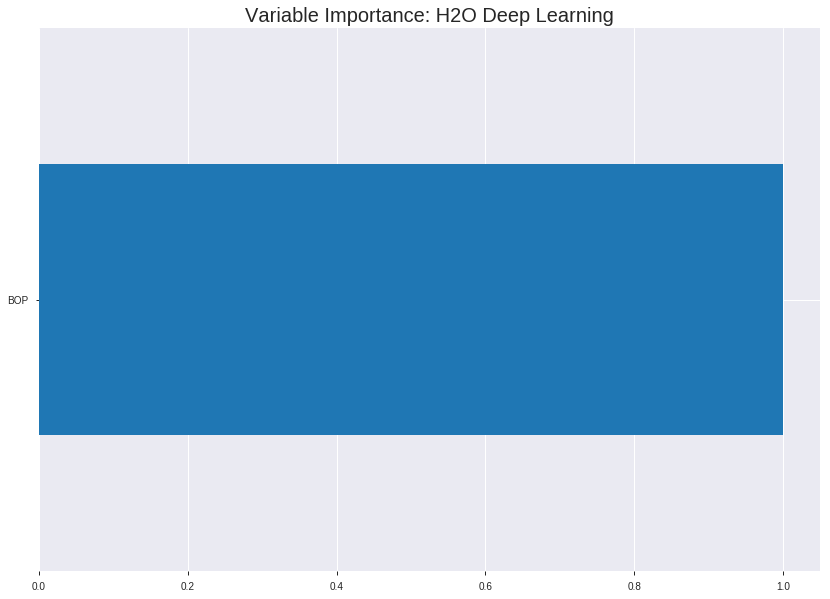

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_160835_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24883521000926298
RMSE: 0.4988338501036823
LogLoss: 0.6908143691858734
Mean Per-Class Error: 0.46746050571251285
AUC: 0.5392943667249348
pr_auc: 0.5256637262611346
Gini: 0.07858873344986961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.433463205590066: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      8    2171  0.9963   (2171.0/2179.0)
1      3    2133  0.0014   (3.0/2136.0)
Total  11   4304  0.5038   (2174.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.433463     0.662422   395
max f2                       0.431117     0.830547   399
max f0point5                 0.471667     0.553438   283
max accuracy                 0.481385     0.530475   253
max precision                0.559514     0.75       1
max recall                   0.431117     1          399
max specificity              0.560427     0.999541   0
max absolute_mcc             0.474609     0.0716162  274
max min_per_class_accuracy   0.506807     0.525281   173
max mean_per_class_accuracy  0.481016     0.532539   254

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.556524           1.19371   1.19371            0.590909         0.558177  0.590909                    0.558177            0.0121723       0.0121723                  19.3714   19.3714
    2        0.0201622                   0.554057           1.08054   1.13777            0.534884         0.555272  0.563218                    0.556741            0.0107678       0.0229401                  8.05352   13.7775
    3        0.0301275                   0.552103           1.17449   1.14992            0.581395         0.553008  0.569231                    0.555506            0.0117041       0.0346442                  17.4495   14.9921
    4        0.0400927                   0.550707           0.939596  1.09764            0.465116         0.551356  0.543353                    0.554475            0.0093633       0.0440075                  -6.04041  9.76435
    5        0.0500579                   0.54901            0.986576  1.07553            0.488372         0.549761  0.532407                    0.553536            0.00983146      0.053839                   -1.34244  7.55328
    6        0.100116                    0.54163            1.17841   1.12697            0.583333         0.5451    0.55787                     0.549318            0.0589888       0.112828                   17.841    12.6971
    7        0.150174                    0.535536           1.05683   1.10359            0.523148         0.538371  0.546296                    0.545669            0.0529026       0.16573                    5.68278   10.359
    8        0.2                         0.529658           1.13691   1.11189            0.562791         0.532606  0.550406                    0.542414            0.0566479       0.222378                   13.6911   11.1891
    9        0.356663                    0.519163           1.02202   1.07242            0.505917         0.522402  0.530864                    0.533624            0.160112        0.382491                   2.2019    7.24153
    10       0.4                         0.516547           0.907439  1.05454            0.449198         0.517824  0.522016                    0.531912            0.0393258       0.421816                   -9.25614  5.45412
    11       0.500116                    0.506481           1.03812   1.05125            0.513889         0.512106  0.520389                    0.527948            0.103933        0.525749                   3.81229   5.12545
    12       0.6                         0.494504           1.0171    1.04557            0.50348          0.500483  0.517574                    0.523375            0.101592        0.627341                   1.70962   4.5568
    13       0.699884                    0.481983           1.04522   1.04552            0.517401         0.488568  0.51755                     0.518408            0.104401        0.731742                   4.52186   4.55182
    14       0.8                         0.468115           0.921217  1.02996            0.456019         0.474803  0.509849                    0.512951            0.0922285       0.82397                    -7.87828  2.99625
    15       0.899884                    0.454403           0.857735  1.01085            0.424594         0.461401  0.500386                    0.507229            0.0856742       0.909644                   -14.2265  1.08459
    16       1                           0.430933           0.902512  1                  0.446759         0.445623  0.495017                    0.501061           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2503429297316828
RMSE: 0.5003428122114705
LogLoss: 0.6938347929827126
Mean Per-Class Error: 0.46710855955401076
AUC: 0.5137420161286069
pr_auc: 0.5462931774522647
Gini: 0.027484032257213853
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43368412041312693: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    584   0.9949   (584.0/587.0)
1      0    646   0        (0.0/646.0)
Total  3    1230  0.4736   (584.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.433684     0.688699   397
max f2                       0.433684     0.84688    397
max f0point5                 0.443038     0.581889   376
max accuracy                 0.44339      0.531225   375
max precision                0.560427     1          0
max recall                   0.433684     1          397
max specificity              0.560427     1          0
max absolute_mcc             0.552657     0.0712686  14
max min_per_class_accuracy   0.503705     0.50774    179
max mean_per_class_accuracy  0.517164     0.532891   135

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 50.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.555589           1.32139   1.32139            0.692308         0.55793   0.692308                    0.55793             0.0139319       0.0139319                  32.1386   32.1386
    2        0.0202758                   0.553652           1.4315    1.37424            0.75             0.554687  0.72                        0.556373            0.0139319       0.0278638                  43.1502   37.4241
    3        0.0300081                   0.551937           1.4315    1.39281            0.75             0.552837  0.72973                     0.555226            0.0139319       0.0417957                  43.1502   39.2812
    4        0.0405515                   0.550052           0.734103  1.22155            0.384615         0.551015  0.64                        0.554131            0.00773994      0.0495356                  -26.5897  22.1548
    5        0.0502839                   0.548409           1.11339   1.20061            0.583333         0.549354  0.629032                    0.553207            0.0108359       0.0603715                  11.339    20.0614
    6        0.100568                    0.541968           0.923549  1.06208            0.483871         0.544762  0.556452                    0.548984            0.0464396       0.106811                   -7.64506  6.20818
    7        0.150041                    0.536271           1.31417   1.1452             0.688525         0.538828  0.6                         0.545635            0.0650155       0.171827                   31.4165   14.5201
    8        0.200324                    0.529905           0.831194  1.06638            0.435484         0.533232  0.558704                    0.542522            0.0417957       0.213622                   -16.8806  6.63817
    9        0.349554                    0.519163           1.08919   1.07612            0.570652         0.522373  0.563805                    0.53392             0.162539        0.376161                   8.9186    7.61172
    10       0.399838                    0.515848           0.985119  1.06467            0.516129         0.517563  0.557809                    0.531863            0.0495356       0.425697                   -1.48807  6.46732
    11       0.500406                    0.503599           0.815802  1.01466            0.427419         0.510018  0.531605                    0.527473            0.0820433       0.50774                    -18.4198  1.4657
    12       0.600162                    0.49225            0.837952  0.985286           0.439024         0.497708  0.516216                    0.522525            0.0835913       0.591331                   -16.2048  -1.47142
    13       0.699919                    0.480932           0.931058  0.977557           0.487805         0.486776  0.512167                    0.51743             0.0928793       0.684211                   -6.89421  -2.24431
    14       0.799676                    0.46912            1.17934   1.00273            0.617886         0.475667  0.525355                    0.51222             0.117647        0.801858                   17.934    0.27286
    15       0.899432                    0.454361           1.00865   1.00338            0.528455         0.462101  0.525699                    0.506662            0.100619        0.902477                   0.864608  0.338491
    16       1                           0.431577           0.969727  1                  0.508065         0.445517  0.523925                    0.500512       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples      training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  -----------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:09:45  0.000 sec                           0         0             0            nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 16:09:47  1 min 10.430 sec  26472 obs/sec     10        1             43150        0.499484         0.692117            0.00196394     0.536964        0.524677           1.19371          0.504983                         0.502068           0.697324              -0.0106029       0.50353           0.543436             1.32139            0.476075
    2019-08-24 16:09:52  1 min 16.100 sec  47699 obs/sec     80        8             345200       0.499508         0.69218             0.00186647     0.539054        0.525435           1.19371          0.503592                         0.502685           0.69862               -0.0130893       0.514             0.546429             1.32139            0.473642
    2019-08-24 16:09:57  1 min 21.276 sec  52413 obs/sec     150       15            647250       0.498923         0.690995            0.00420611     0.539083        0.52539            1.19371          0.503592                         0.501389           0.695957              -0.00786958      0.513987          0.546446             1.32139            0.473642
    2019-08-24 16:10:03  1 min 26.650 sec  53763 obs/sec     220       22            949300       0.498858         0.690865            0.00446465     0.539074        0.525464           1.19371          0.503824                         0.500723           0.694603              -0.00519665      0.513958          0.546451             1.32139            0.473642
    2019-08-24 16:10:08  1 min 31.764 sec  55091 obs/sec     290       29            1.25135e+06  0.498834         0.690814            0.00456031     0.539294        0.525664           1.19371          0.503824                         0.500343           0.693835              -0.00366982      0.513742          0.546293             1.32139            0.473642
    2019-08-24 16:10:13  1 min 36.816 sec  56071 obs/sec     360       36            1.5534e+06   0.49948          0.692127            0.00197861     0.539084        0.525493           1.19371          0.503824                         0.503176           0.699621              -0.0150694       0.513966          0.546505             1.32139            0.473642
    2019-08-24 16:10:13  1 min 36.883 sec  56063 obs/sec     360       36            1.5534e+06   0.498834         0.690814            0.00456031     0.539294        0.525664           1.19371          0.503824                         0.500343           0.693835              -0.00366982      0.513742          0.546293             1.32139            0.473642

Variable Importances: 


variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
BOP         1                      1                    1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5251215559157212)

('F1', 0.6564551422319475)

('auc', 0.5190115667718191)

('logloss', 0.6931362521649858)

('mean_per_class_error', 0.47269190325972654)

('rmse', 0.4999934606080923)

('mse', 0.24999346065085593)

deeplearning prediction progress: |███████████████████████████████████████| 100%


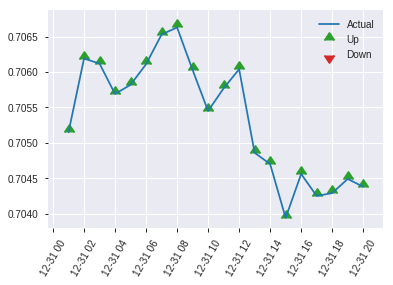


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24999346065085593
RMSE: 0.4999934606080923
LogLoss: 0.6931362521649858
Mean Per-Class Error: 0.47269190325972654
AUC: 0.5190115667718191
pr_auc: 0.4951138412531006
Gini: 0.03802313354363829
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.433216650671365: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    314  0.9905   (314.0/317.0)
1      0    300  0        (0.0/300.0)
Total  3    614  0.5089   (314.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.433217     0.656455   397
max f2                       0.433217     0.826902   397
max f0point5                 0.440591     0.544682   387
max accuracy                 0.499393     0.525122   210
max precision                0.554489     0.571429   9
max recall                   0.433217     1          397
max specificity              0.560427     0.996845   0
max absolute_mcc             0.433217     0.0679998  397
max min_per_class_accuracy   0.507795     0.51735    180
max mean_per_class_accuracy  0.499393     0.527308   210

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.556338           0.881429  0.881429           0.428571         0.558133  0.428571                    0.558133            0.01            0.01                       -11.8571  -11.8571
    2        0.0210697                   0.55449            1.37111   1.10744            0.666667         0.555461  0.538462                    0.5569              0.0133333       0.0233333                  37.1111   10.7436
    3        0.0307942                   0.553712           0.685556  0.974211           0.333333         0.554098  0.473684                    0.556015            0.00666667      0.03                       -31.4444  -2.57895
    4        0.0405186                   0.551882           0.342778  0.822667           0.166667         0.552887  0.4                         0.555264            0.00333333      0.0333333                  -65.7222  -17.7333
    5        0.0502431                   0.549538           1.02833   0.862473           0.5              0.550743  0.419355                    0.554389            0.01            0.0433333                  2.83333   -13.7527
    6        0.100486                    0.541555           1.19419   1.02833            0.580645         0.545521  0.5                         0.549955            0.06            0.103333                   19.4194   2.83333
    7        0.150729                    0.535099           1.12785   1.06151            0.548387         0.538818  0.516129                    0.546243            0.0566667       0.16                       12.7849   6.15054
    8        0.200972                    0.528674           0.862473  1.01175            0.419355         0.532591  0.491935                    0.54283             0.0433333       0.203333                   -13.7527  1.17473
    9        0.299838                    0.519213           1.04519   1.02277            0.508197         0.523824  0.497297                    0.536563            0.103333        0.306667                   4.51913   2.27748
    10       0.400324                    0.517233           1.02833   1.02417            0.5              0.518638  0.497976                    0.532063            0.103333        0.41                       2.83333   2.417
    11       0.50081                     0.507795           1.09468   1.03832            0.532258         0.513176  0.504854                    0.528274            0.11            0.52                       9.46774   3.83172
    12       0.599676                    0.496711           1.01148   1.03389            0.491803         0.502062  0.502703                    0.523952            0.1             0.62                       1.14754   3.38919
    13       0.700162                    0.484661           0.895645  1.01405            0.435484         0.491347  0.493056                    0.519273            0.09            0.71                       -10.4355  1.40509
    14       0.799028                    0.469421           1.07891   1.02208            0.52459          0.47772   0.496957                    0.514131            0.106667        0.816667                   7.89071   2.20757
    15       0.899514                    0.455971           0.928817  1.01166            0.451613         0.463393  0.491892                    0.508463            0.0933333       0.91                       -7.11828  1.16577
    16       1                           0.431919           0.895645  1                  0.435484         0.445663  0.486224                    0.502153       

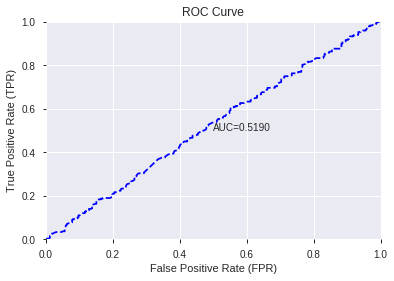

This function is available for GLM models only


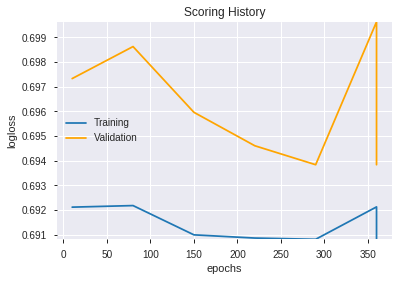

--2019-08-24 16:19:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.136
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.136|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_160835_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_160835_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190824_162024_model_1  0.518659  0.692407              0.495268  0.49963  0.24963

variable  relative_importance  scaled_importance  percentage
0      BOP             0.059835                1.0         1.0

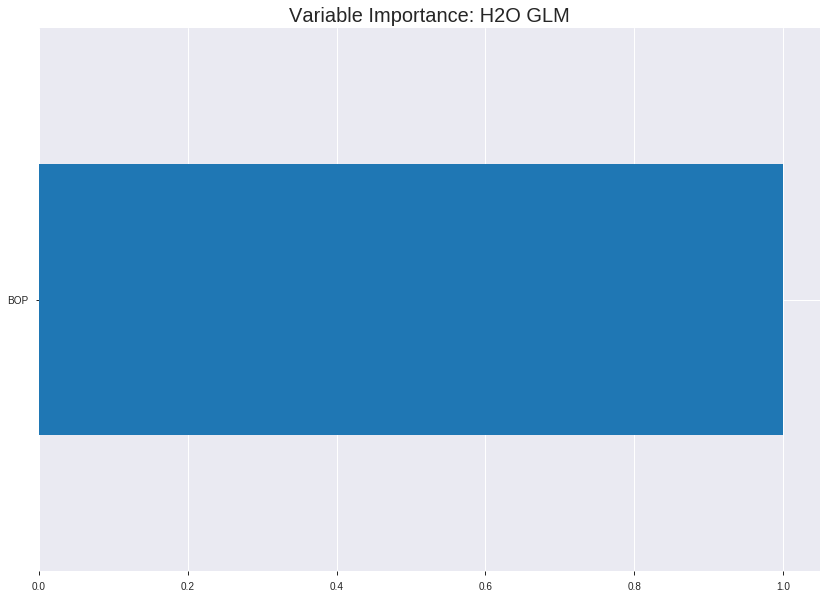

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_162024_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24919961770899615
RMSE: 0.4991989760696592
LogLoss: 0.6915454751151232
Null degrees of freedom: 4314
Residual degrees of freedom: 4313
Null deviance: 5981.431655925498
Residual deviance: 5968.037450243513
AIC: 5972.037450243513
AUC: 0.5390833810307102
pr_auc: 0.5254928529420843
Gini: 0.07816676206142037
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4677501568859877: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      10   2169  0.9954   (2169.0/2179.0)
1      4    2132  0.0019   (4.0/2136.0)
Total  14   4301  0.5036   (2173.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.46775      0.66242    395
max f2                       0.466629     0.830547   399
max f0point5                 0.48078      0.553475   304
max accuracy                 0.484164     0.530475   277
max precision                0.522525     0.75       1
max recall                   0.466629     1          399
max specificity              0.5229       0.999541   0
max absolute_mcc             0.482014     0.0715206  294
max min_per_class_accuracy   0.495272     0.525281   200
max mean_per_class_accuracy  0.484036     0.532539   278

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.521298           1.19371   1.19371            0.590909         0.521976  0.590909                    0.521976            0.0121723       0.0121723                  19.3714   19.3714
    2        0.0201622                   0.520286           1.08054   1.13777            0.534884         0.520784  0.563218                    0.521387            0.0107678       0.0229401                  8.05352   13.7775
    3        0.0301275                   0.519486           1.17449   1.14992            0.581395         0.519856  0.569231                    0.520881            0.0117041       0.0346442                  17.4495   14.9921
    4        0.0400927                   0.518914           0.939596  1.09764            0.465116         0.51918   0.543353                    0.520458            0.0093633       0.0440075                  -6.04041  9.76435
    5        0.0500579                   0.518219           0.986576  1.07553            0.488372         0.518526  0.532407                    0.520073            0.00983146      0.053839                   -1.34244  7.55328
    6        0.100116                    0.515203           1.17841   1.12697            0.583333         0.516621  0.55787                     0.518347            0.0589888       0.112828                   17.841    12.6971
    7        0.150174                    0.512718           1.05683   1.10359            0.523148         0.513873  0.546296                    0.516856            0.0529026       0.16573                    5.68278   10.359
    8        0.2                         0.510323           1.13691   1.11189            0.562791         0.511524  0.550406                    0.515527            0.0566479       0.222378                   13.6911   11.1891
    9        0.300116                    0.505707           1.00539   1.07636            0.497685         0.508105  0.532819                    0.513051            0.100655        0.323034                   0.538931  7.63633
    10       0.4                         0.500536           0.988974  1.05454            0.489559         0.503151  0.522016                    0.510579            0.0987828       0.421816                   -1.10263  5.45412
    11       0.500116                    0.495119           1.03812   1.05125            0.513889         0.497855  0.520389                    0.508032            0.103933        0.525749                   3.81229   5.12545
    12       0.6                         0.489495           1.0171    1.04557            0.50348          0.492303  0.517574                    0.505414            0.101592        0.627341                   1.70962   4.5568
    13       0.699884                    0.484371           1.04522   1.04552            0.517401         0.486892  0.51755                     0.50277             0.104401        0.731742                   4.52186   4.55182
    14       0.8                         0.479557           0.921217  1.02996            0.456019         0.48188   0.509849                    0.500156            0.0922285       0.82397                    -7.87828  2.99625
    15       0.899884                    0.474784           0.857735  1.01085            0.424594         0.477221  0.500386                    0.49761             0.0856742       0.909644                   -14.2265  1.08459
    16       1                           0.466564           0.902512  1                  0.446759         0.471715  0.495017                    0.495018           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.250083661697616
RMSE: 0.5000836546995072
LogLoss: 0.6933151061560504
Null degrees of freedom: 1232
Residual degrees of freedom: 1231
Null deviance: 1710.5993345457732
Residual deviance: 1709.7150517808204
AIC: 1713.7150517808204
AUC: 0.5139648525060523
pr_auc: 0.5464874363887536
Gini: 0.027929705012104566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46753203677765137: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    584   0.9949   (584.0/587.0)
1      0    646   0        (0.0/646.0)
Total  3    1230  0.4736   (584.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.467532     0.688699   397
max f2                       0.467532     0.84688    397
max f0point5                 0.470936     0.581825   378
max accuracy                 0.470936     0.531225   378
max precision                0.5229       1          0
max recall                   0.467532     1          397
max specificity              0.5229       1          0
max absolute_mcc             0.519508     0.0724799  14
max min_per_class_accuracy   0.493816     0.50774    200
max mean_per_class_accuracy  0.501086     0.532891   148

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.520914           1.32139   1.32139            0.692308         0.521875  0.692308                    0.521875            0.0139319       0.0139319                  32.1386   32.1386
    2        0.0202758                   0.52012            1.4315    1.37424            0.75             0.520544  0.72                        0.521236            0.0139319       0.0278638                  43.1502   37.4241
    3        0.0300081                   0.519417           1.4315    1.39281            0.75             0.519786  0.72973                     0.520766            0.0139319       0.0417957                  43.1502   39.2812
    4        0.0405515                   0.518646           0.734103  1.22155            0.384615         0.51904   0.64                        0.520317            0.00773994      0.0495356                  -26.5897  22.1548
    5        0.0502839                   0.517973           1.11339   1.20061            0.583333         0.51836   0.629032                    0.519938            0.0108359       0.0603715                  11.339    20.0614
    6        0.100568                    0.515341           0.923549  1.06208            0.483871         0.516483  0.556452                    0.51821             0.0464396       0.106811                   -7.64506  6.20818
    7        0.150041                    0.513017           1.31417   1.1452             0.688525         0.51406   0.6                         0.516842            0.0650155       0.171827                   31.4165   14.5201
    8        0.200324                    0.510424           0.831194  1.06638            0.435484         0.511779  0.558704                    0.515571            0.0417957       0.213622                   -16.8806  6.63817
    9        0.300081                    0.505291           1.1483    1.09362            0.601626         0.507957  0.572973                    0.51304             0.114551        0.328173                   14.8305   9.36156
    10       0.399838                    0.499912           0.977611  1.06467            0.512195         0.502823  0.557809                    0.510491            0.0975232       0.425697                   -2.23892  6.46732
    11       0.500406                    0.493766           0.815802  1.01466            0.427419         0.496824  0.531605                    0.507744            0.0820433       0.50774                    -18.4198  1.4657
    12       0.600162                    0.488451           0.837952  0.985286           0.439024         0.491     0.516216                    0.504961            0.0835913       0.591331                   -16.2048  -1.47142
    13       0.699919                    0.484007           0.931058  0.977557           0.487805         0.486165  0.512167                    0.502282            0.0928793       0.684211                   -6.89421  -2.24431
    14       0.799676                    0.479906           1.17934   1.00273            0.617886         0.48218   0.525355                    0.499775            0.117647        0.801858                   17.934    0.27286
    15       0.899432                    0.474769           1.00865   1.00338            0.528455         0.477465  0.525699                    0.4973              0.100619        0.902477                   0.864608  0.338491
    16       1                           0.466791           0.969727  1                  0.508065         0.471678  0.523925                    0.494723       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 16:20:25  0.000 sec   2            3.3       2             1.38559           1.38712
    2019-08-24 16:20:25  0.005 sec   3            2.1       2             1.38529           1.38701
    2019-08-24 16:20:25  0.025 sec   4            1.3       2             1.38486           1.38688
    2019-08-24 16:20:25  0.028 sec   5            0.8       2             1.38432           1.38674
    2019-08-24 16:20:25  0.032 sec   6            0.5       2             1.38371           1.38664
    2019-08-24 16:20:25  0.035 sec   7            0.31      2             1.38309           1.38663
    2019-08-24 16:20:25  0.045 sec   8            0.19      2             1.38257           1.38674
    2019-08-24 16:20:25  0.048 sec   9            0.12      2             1.38219           1.38696
    2019-08-24 16:20:25  0.050 sec   10           0.074     2             1.38196           1.38723
    2019-08-24 16:20:25  0.056 sec   11           0.046     2             1.38183           1.3875
    2019-08-24 16:20:25  0.060 sec   12           0.029     2             1.38177           1.38772

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5251215559157212)

('F1', 0.6564551422319475)

('auc', 0.5186593059936908)

('logloss', 0.6924072128608767)

('mean_per_class_error', 0.47269190325972654)

('rmse', 0.49963013149212576)

('mse', 0.24963026829483886)

glm prediction progress: |████████████████████████████████████████████████| 100%


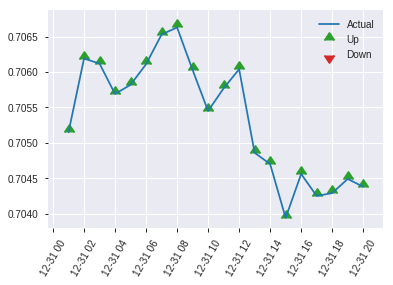


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24963026829483886
RMSE: 0.49963013149212576
LogLoss: 0.6924072128608767
Null degrees of freedom: 616
Residual degrees of freedom: 615
Null deviance: 855.0660663376912
Residual deviance: 854.4305006703219
AIC: 858.4305006703219
AUC: 0.5186593059936908
pr_auc: 0.49491454417412156
Gini: 0.03731861198738162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46736772827932094: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    314  0.9905   (314.0/317.0)
1      0    300  0        (0.0/300.0)
Total  3    614  0.5089   (314.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.467368     0.656455   397
max f2                       0.467368     0.826902   397
max f0point5                 0.469956     0.544682   387
max accuracy                 0.49179      0.525122   225
max precision                0.520463     0.571429   9
max recall                   0.467368     1          397
max specificity              0.5229       0.996845   0
max absolute_mcc             0.467368     0.0679998  397
max min_per_class_accuracy   0.495736     0.51735    196
max mean_per_class_accuracy  0.49179      0.527308   225

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 49.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.521221           0.881429  0.881429           0.428571         0.521958  0.428571                    0.521958            0.01            0.01                       -11.8571  -11.8571
    2        0.0210697                   0.520464           1.37111   1.10744            0.666667         0.520862  0.538462                    0.521452            0.0133333       0.0233333                  37.1111   10.7436
    3        0.0307942                   0.520145           0.685556  0.974211           0.333333         0.520303  0.473684                    0.521089            0.00666667      0.03                       -31.4444  -2.57895
    4        0.0405186                   0.519395           0.342778  0.822667           0.166667         0.519807  0.4                         0.520781            0.00333333      0.0333333                  -65.7222  -17.7333
    5        0.0502431                   0.518435           1.02833   0.862473           0.5              0.518929  0.419355                    0.520423            0.01            0.0433333                  2.83333   -13.7527
    6        0.100486                    0.515173           1.19419   1.02833            0.580645         0.516793  0.5                         0.518608            0.06            0.103333                   19.4194   2.83333
    7        0.150729                    0.512539           1.12785   1.06151            0.548387         0.514056  0.516129                    0.517091            0.0566667       0.16                       12.7849   6.15054
    8        0.200972                    0.509923           0.862473  1.01175            0.419355         0.511518  0.491935                    0.515697            0.0433333       0.203333                   -13.7527  1.17473
    9        0.299838                    0.50603            1.04519   1.02277            0.508197         0.50795   0.497297                    0.513143            0.103333        0.306667                   4.51913   2.27748
    10       0.400324                    0.501148           1.02833   1.02417            0.5              0.503073  0.497976                    0.510615            0.103333        0.41                       2.83333   2.417
    11       0.50081                     0.495736           1.09468   1.03832            0.532258         0.498441  0.504854                    0.508172            0.11            0.52                       9.46774   3.83172
    12       0.599676                    0.490531           1.01148   1.03389            0.491803         0.493044  0.502703                    0.505678            0.1             0.62                       1.14754   3.38919
    13       0.700162                    0.4853             0.895645  1.01405            0.435484         0.488067  0.493056                    0.503151            0.09            0.71                       -10.4355  1.40509
    14       0.799028                    0.480011           1.07891   1.02208            0.52459          0.482892  0.496957                    0.500644            0.106667        0.816667                   7.89071   2.20757
    15       0.899514                    0.47533            0.928817  1.01166            0.451613         0.477914  0.491892                    0.498105            0.0933333       0.91                       -7.11828  1.16577
    16       1                           0.466911           0.895645  1                  0.435484         0.471729  0.486224                    0.495454       

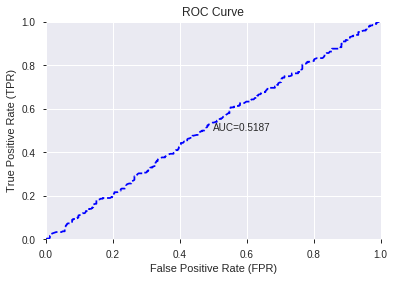

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


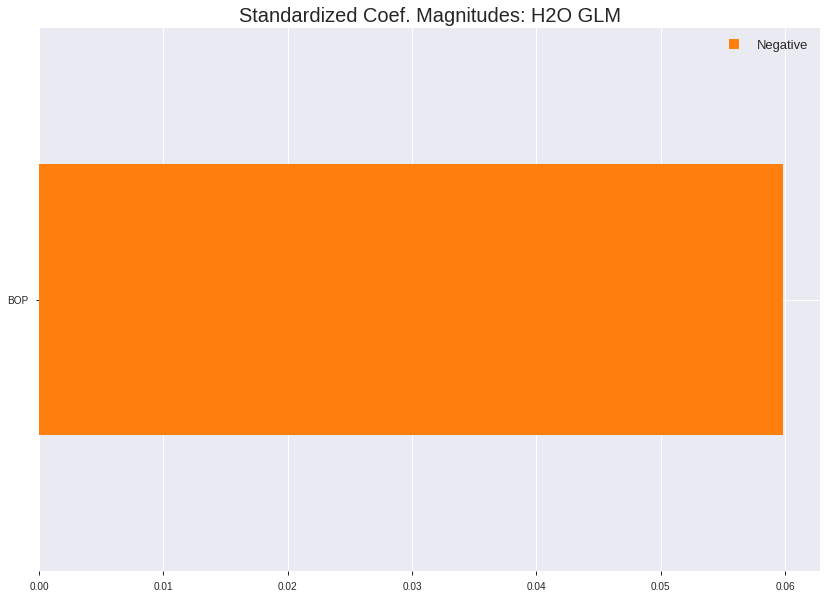

'log_likelihood'
--2019-08-24 16:20:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_162024_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_162024_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP']

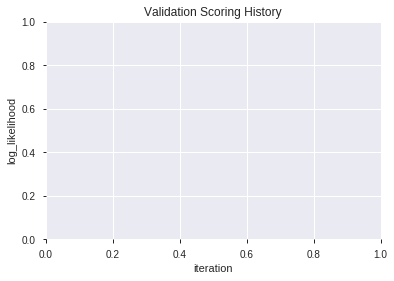

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190824_162131  0.528959  0.697773                   0.5  0.502185  0.252190
1               XGBoost_1_AutoML_20190824_162131  0.521788  0.699718                   0.5  0.503120  0.253130
2  XGBoost_grid_1_AutoML_20190824_162131_model_7  0.521283  0.700131                   0.5  0.503291  0.253302
3  XGBoost_grid_1_AutoML_20190824_162131_model_2  0.517955  0.695262                   0.5  0.501032  0.251034
4  XGBoost_grid_1_AutoML_20190824_162131_model_5  0.517645  0.707349                   0.5  0.506498  0.256540
5               XGBoost_3_AutoML_20190824_162131  0.516125  0.695219                   0.5  0.501005  0.251006
6  XGBoost_grid_1_AutoML_20190824_162131_model_6  0.514958  0.695137                   0.5  0.500960  0.250961
7  XGBoost_grid_1_AutoML_20190824_162131_model_1  0.513507  0.695995                   0.5  0.501389  0.251391
8  XGBoost_grid_1_AutoML_20190824_162131_model_3  0.508843  0.697081                   0.5  0.501904  0.251907
9  XGBoost_grid_1_AutoML_20190824_162131_model_4  0.505442  0.696757                   0.5  0.501770  0.251773

variable  relative_importance  scaled_importance  percentage
0      BOP          4080.411377                1.0         1.0

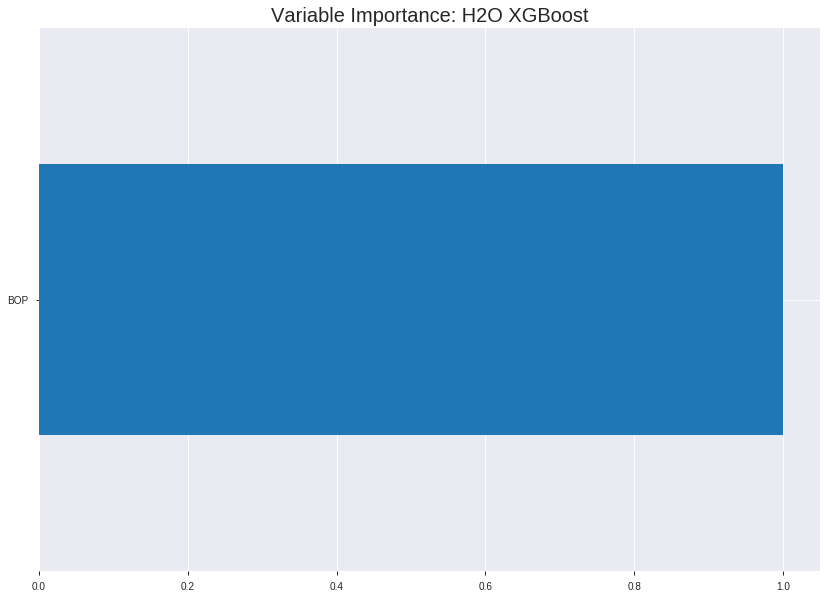

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190824_162131


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2352884322632342
RMSE: 0.485065389677757
LogLoss: 0.663251740132026
Mean Per-Class Error: 0.3796806811013539
AUC: 0.6581438759146294
pr_auc: 0.6415211695621106
Gini: 0.31628775182925883
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4335907369852066: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      587  1592  0.7306   (1592.0/2179.0)
1      228  1908  0.1067   (228.0/2136.0)
Total  815  3500  0.4218   (1820.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433591     0.677076  299
max f2                       0.323164     0.831645  396
max f0point5                 0.494507     0.616522  204
max accuracy                 0.498623     0.620394  196
max precision                0.672634     1         0
max recall                   0.321181     1         397
max specificity              0.672634     1         0
max absolute_mcc             0.494507     0.240663  204
max min_per_class_accuracy   0.493039     0.616797  206
max mean_per_class_accuracy  0.494507     0.620319  204

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0108922                   0.654497           1.76224   1.76224            0.87234          0.66052   0.87234                     0.66052             0.0191948       0.0191948                  76.2242   76.2242
    2        0.020394                    0.645668           1.77377   1.76761            0.878049         0.648657  0.875                       0.654993            0.0168539       0.0360487                  77.3774   76.7615
    3        0.0308227                   0.636257           1.21208   1.57965            0.6              0.638965  0.781955                    0.64957             0.0126404       0.0486891                  21.2079   57.9651
    4        0.0405562                   0.630605           1.39485   1.5353             0.690476         0.632847  0.76                        0.645556            0.0135768       0.0622659                  39.4852   53.53
    5        0.0505214                   0.62342            1.45637   1.51973            0.72093          0.62642   0.752294                    0.641782            0.0145131       0.076779                   45.6374   51.9732
    6        0.100579                    0.59349            1.44963   1.48484            0.717593         0.606768  0.735023                    0.624356            0.0725655       0.149345                   44.9631   48.4843
    7        0.150406                    0.576275           1.1557    1.37581            0.572093         0.584774  0.681048                    0.611243            0.0575843       0.206929                   15.5703   37.5806
    8        0.200232                    0.55371            1.41879   1.3865             0.702326         0.562269  0.686343                    0.599056            0.0706929       0.277622                   41.879    38.6502
    9        0.300579                    0.532275           1.20835   1.32703            0.598152         0.542016  0.656901                    0.580013            0.121255        0.398876                   20.8346   32.7025
    10       0.4                         0.510356           1.13014   1.27809            0.559441         0.521122  0.632677                    0.565376            0.11236         0.511236                   13.0143   27.809
    11       0.500116                    0.492665           1.06618   1.23567            0.527778         0.501789  0.611677                    0.552647            0.106742        0.617978                   6.61803   23.5669
    12       0.610892                    0.477452           0.963577  1.18633            0.476987         0.484028  0.587253                    0.540204            0.106742        0.724719                   -3.64228  18.6329
    13       0.699884                    0.457959           0.778592  1.13448            0.385417         0.468069  0.561589                    0.531032            0.0692884       0.794007                   -22.1408  13.4484
    14       0.800695                    0.435142           0.900932  1.10508            0.445977         0.447924  0.547033                    0.520568            0.090824        0.884831                   -9.9068   10.5079
    15       0.900348                    0.401863           0.634227  1.05296            0.313953         0.419434  0.521236                    0.509374            0.0632022       0.948034                   -36.5773  5.29641
    16       1                           0.316985           0.521476  1                  0.25814          0.366732  0.495017                    0.49516             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2545818118890676
RMSE: 0.5045610090851924
LogLoss: 0.7026382294515179
Mean Per-Class Error: 0.47457687459454323
AUC: 0.5087921477207399
pr_auc: 0.5269302507717516
Gini: 0.01758429544147977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3231643736362457: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    586   0.9983   (586.0/587.0)
1      0    646   0        (0.0/646.0)
Total  1    1232  0.4753   (586.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.323164     0.687966   398
max f2                       0.323164     0.846436   398
max f0point5                 0.323164     0.579476   398
max accuracy                 0.484155     0.52717    216
max precision                0.57759      0.590361   60
max recall                   0.323164     1          398
max specificity              0.668005     0.998296   0
max absolute_mcc             0.57759      0.0524691  60
max min_per_class_accuracy   0.490778     0.512777   204
max mean_per_class_accuracy  0.484155     0.525423   216

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.65379            0.880924  0.880924           0.461538         0.659409  0.461538                    0.659409            0.00928793      0.00928793                 -11.9076   -11.9076
    2        0.0202758                   0.64491            0.954334  0.916161           0.5              0.649454  0.48                        0.654631            0.00928793      0.0185759                  -4.56656   -8.3839
    3        0.0300081                   0.635582           0.795279  0.876956           0.416667         0.640845  0.459459                    0.65016             0.00773994      0.0263158                  -20.4721   -12.3044
    4        0.0429846                   0.630582           1.19292   0.972341           0.625            0.63271   0.509434                    0.644892            0.0154799       0.0417957                  19.2918    -2.76593
    5        0.0510949                   0.625633           0.763467  0.939186           0.4              0.626965  0.492063                    0.642046            0.00619195      0.0479876                  -23.6533   -6.08138
    6        0.100568                    0.593156           1.12643   1.0313             0.590164         0.606795  0.540323                    0.624705            0.0557276       0.103715                   12.6427    3.12968
    7        0.151663                    0.566755           1.12096   1.06151            0.587302         0.581635  0.55615                     0.610195            0.0572755       0.160991                   12.0964    6.15056
    8        0.200324                    0.549184           0.986146  1.0432             0.516667         0.558063  0.546559                    0.597531            0.0479876       0.208978                   -1.38545   4.31995
    9        0.301703                    0.526753           0.824545  0.969727           0.432            0.537259  0.508065                    0.577278            0.0835913       0.29257                    -17.5455   -3.02731
    10       0.399838                    0.504645           1.10419   1.00273            0.578512         0.515456  0.525355                    0.562105            0.108359        0.400929                   10.4189    0.27286
    11       0.501217                    0.490791           1.16047   1.03463            0.608            0.497042  0.542071                    0.548945            0.117647        0.518576                   16.0471    3.46343
    12       0.600973                    0.477094           0.91554   1.01487            0.479675         0.482632  0.531714                    0.537937            0.0913313       0.609907                   -8.44597   1.48657
    13       0.699919                    0.458817           0.954334  1.00631            0.5              0.467467  0.527231                    0.527975            0.0944272       0.704334                   -4.56656   0.630854
    14       0.800487                    0.438302           0.985119  1.00365            0.516129         0.449532  0.525836                    0.51812             0.0990712       0.803406                   -1.48807   0.364648
    15       0.900243                    0.405456           0.977611  1.00076            0.512195         0.4216    0.524324                    0.507425            0.0975232       0.900929                   -2.23892   0.0761443
    16       1                           0.3212             0.993128  1                  0.520325         0.370308  0.523925           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:21:34  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.504983                         0.5                0.693147              0.5               0                    1                  0.476075
    2019-08-24 16:21:34  0.042 sec   5                  0.496769         0.686699            0.608494        0.57482            1.28306          0.487833                         0.500396           0.69394               0.49681           0.514947             1.09067            0.476075
    2019-08-24 16:21:34  0.080 sec   10                 0.494419         0.682013            0.61657         0.592074           1.54733          0.473928                         0.500788           0.694733              0.500418          0.523092             0.734103           0.476075
    2019-08-24 16:21:34  0.122 sec   15                 0.492609         0.678392            0.623288        0.600288           1.5151           0.469061                         0.501114           0.69541               0.508121          0.530034             0.835043           0.475264
    2019-08-24 16:21:34  0.172 sec   20                 0.491193         0.675551            0.627176        0.611842           1.52396          0.45956                          0.502136           0.697507              0.504793          0.524913             0.763467           0.475264
    2019-08-24 16:21:34  0.227 sec   25                 0.489845         0.67284             0.632226        0.613977           1.45449          0.462804                         0.502898           0.699087              0.503449          0.521812             0.763467           0.475264
    2019-08-24 16:21:34  0.287 sec   30                 0.488773         0.670693            0.638766        0.620166           1.62489          0.458401                         0.502849           0.699018              0.510645          0.525808             0.681667           0.475264
    2019-08-24 16:21:34  0.363 sec   35                 0.487764         0.668656            0.643544        0.62423            1.71926          0.428273                         0.503367           0.700115              0.510349          0.526068             0.734103           0.475264
    2019-08-24 16:21:34  0.450 sec   40                 0.486839         0.666814            0.648694        0.632657           1.71272          0.421089                         0.503822           0.701069              0.510025          0.52723              0.880924           0.475264
    2019-08-24 16:21:34  0.529 sec   45                 0.4859           0.664921            0.652536        0.63563            1.69875          0.420162                         0.504037           0.701527              0.509763          0.528136             0.880924           0.475264
    2019-08-24 16:21:34  0.614 sec   50                 0.485065         0.663252            0.658144        0.641521           1.76224          0.421784                         0.504561           0.702638              0.508792          0.52693              0.880924           0.475264

Variable Importances: 


variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
BOP         4080.41                1                    1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5413290113452188)

('F1', 0.6543075245365322)

('auc', 0.5289589905362776)

('logloss', 0.6977732666294769)

('mean_per_class_error', 0.45956887486855935)

('rmse', 0.5021854632229809)

('mse', 0.25219023947247987)

xgboost prediction progress: |████████████████████████████████████████████| 100%


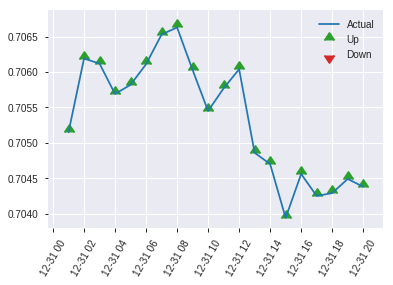


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25219023947247987
RMSE: 0.5021854632229809
LogLoss: 0.6977732666294769
Mean Per-Class Error: 0.45956887486855935
AUC: 0.5289589905362776
pr_auc: 0.5138016917481482
Gini: 0.05791798107255519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3211996257305145: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    317  1        (317.0/317.0)
1      0    300  0        (0.0/300.0)
Total  0    617  0.5138   (317.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.3212       0.654308   399
max f2                       0.3212       0.825537   399
max f0point5                 0.368797     0.543893   375
max accuracy                 0.539067     0.541329   94
max precision                0.669754     1          0
max recall                   0.3212       1          399
max specificity              0.669754     1          0
max absolute_mcc             0.493906     0.0809338  205
max min_per_class_accuracy   0.496381     0.533123   197
max mean_per_class_accuracy  0.493906     0.540431   205

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 49.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.65985            1.46905   1.46905            0.714286         0.663531  0.714286                    0.663531            0.0166667       0.0166667                  46.9048   46.9048
    2        0.0226904                   0.64872            1.17524   1.32214            0.571429         0.650889  0.642857                    0.65721             0.0133333       0.03                       17.5238   32.2143
    3        0.0340357                   0.638056           1.17524   1.27317            0.571429         0.640479  0.619048                    0.651633            0.0133333       0.0433333                  17.5238   27.3175
    4        0.0421394                   0.631346           0.822667  1.18654            0.4              0.634497  0.576923                    0.648338            0.00666667      0.05                       -17.7333  18.6538
    5        0.0502431                   0.619742           1.234     1.19419            0.6              0.626008  0.580645                    0.644736            0.01            0.06                       23.4      19.4194
    6        0.100486                    0.58966            0.796129  0.995161           0.387097         0.604222  0.483871                    0.624479            0.04            0.1                        -20.3871  -0.483871
    7        0.150729                    0.575202           1.26054   1.08362            0.612903         0.583055  0.526882                    0.610671            0.0633333       0.163333                   26.0538   8.36201
    8        0.204214                    0.553362           1.12182   1.09362            0.545455         0.561914  0.531746                    0.597901            0.06            0.223333                   12.1818   9.36243
    9        0.303079                    0.532844           0.97776   1.05583            0.47541          0.540888  0.513369                    0.579304            0.0966667       0.32                       -2.22404  5.58289
    10       0.400324                    0.514848           1.06261   1.05748            0.516667         0.523554  0.51417                     0.565761            0.103333        0.423333                   6.26111   5.74764
    11       0.50081                     0.496381           1.12785   1.0716             0.548387         0.504374  0.521036                    0.553444            0.113333        0.536667                   12.7849   7.15965
    12       0.599676                    0.478726           0.944044  1.05057            0.459016         0.488602  0.510811                    0.542754            0.0933333       0.63                       -5.59563  5.05676
    13       0.700162                    0.4619             0.762957  1.00929            0.370968         0.471683  0.490741                    0.532554            0.0766667       0.706667                   -23.7043  0.929012
    14       0.799028                    0.43813            1.01148   1.00956            0.491803         0.451822  0.490872                    0.522565            0.1             0.806667                   1.14754   0.956051
    15       0.901135                    0.395422           0.848783  0.991343           0.412698         0.418498  0.482014                    0.510773            0.0866667       0.893333                   -15.1217  -0.865707
    16       1                           0.3212             1.07891   1                  0.52459          0.364727  0.486224                    0.496334   

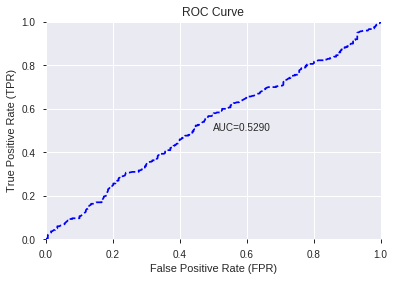

This function is available for GLM models only


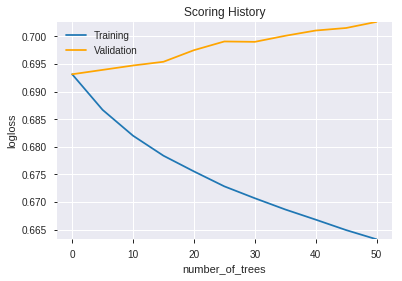

--2019-08-24 16:21:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


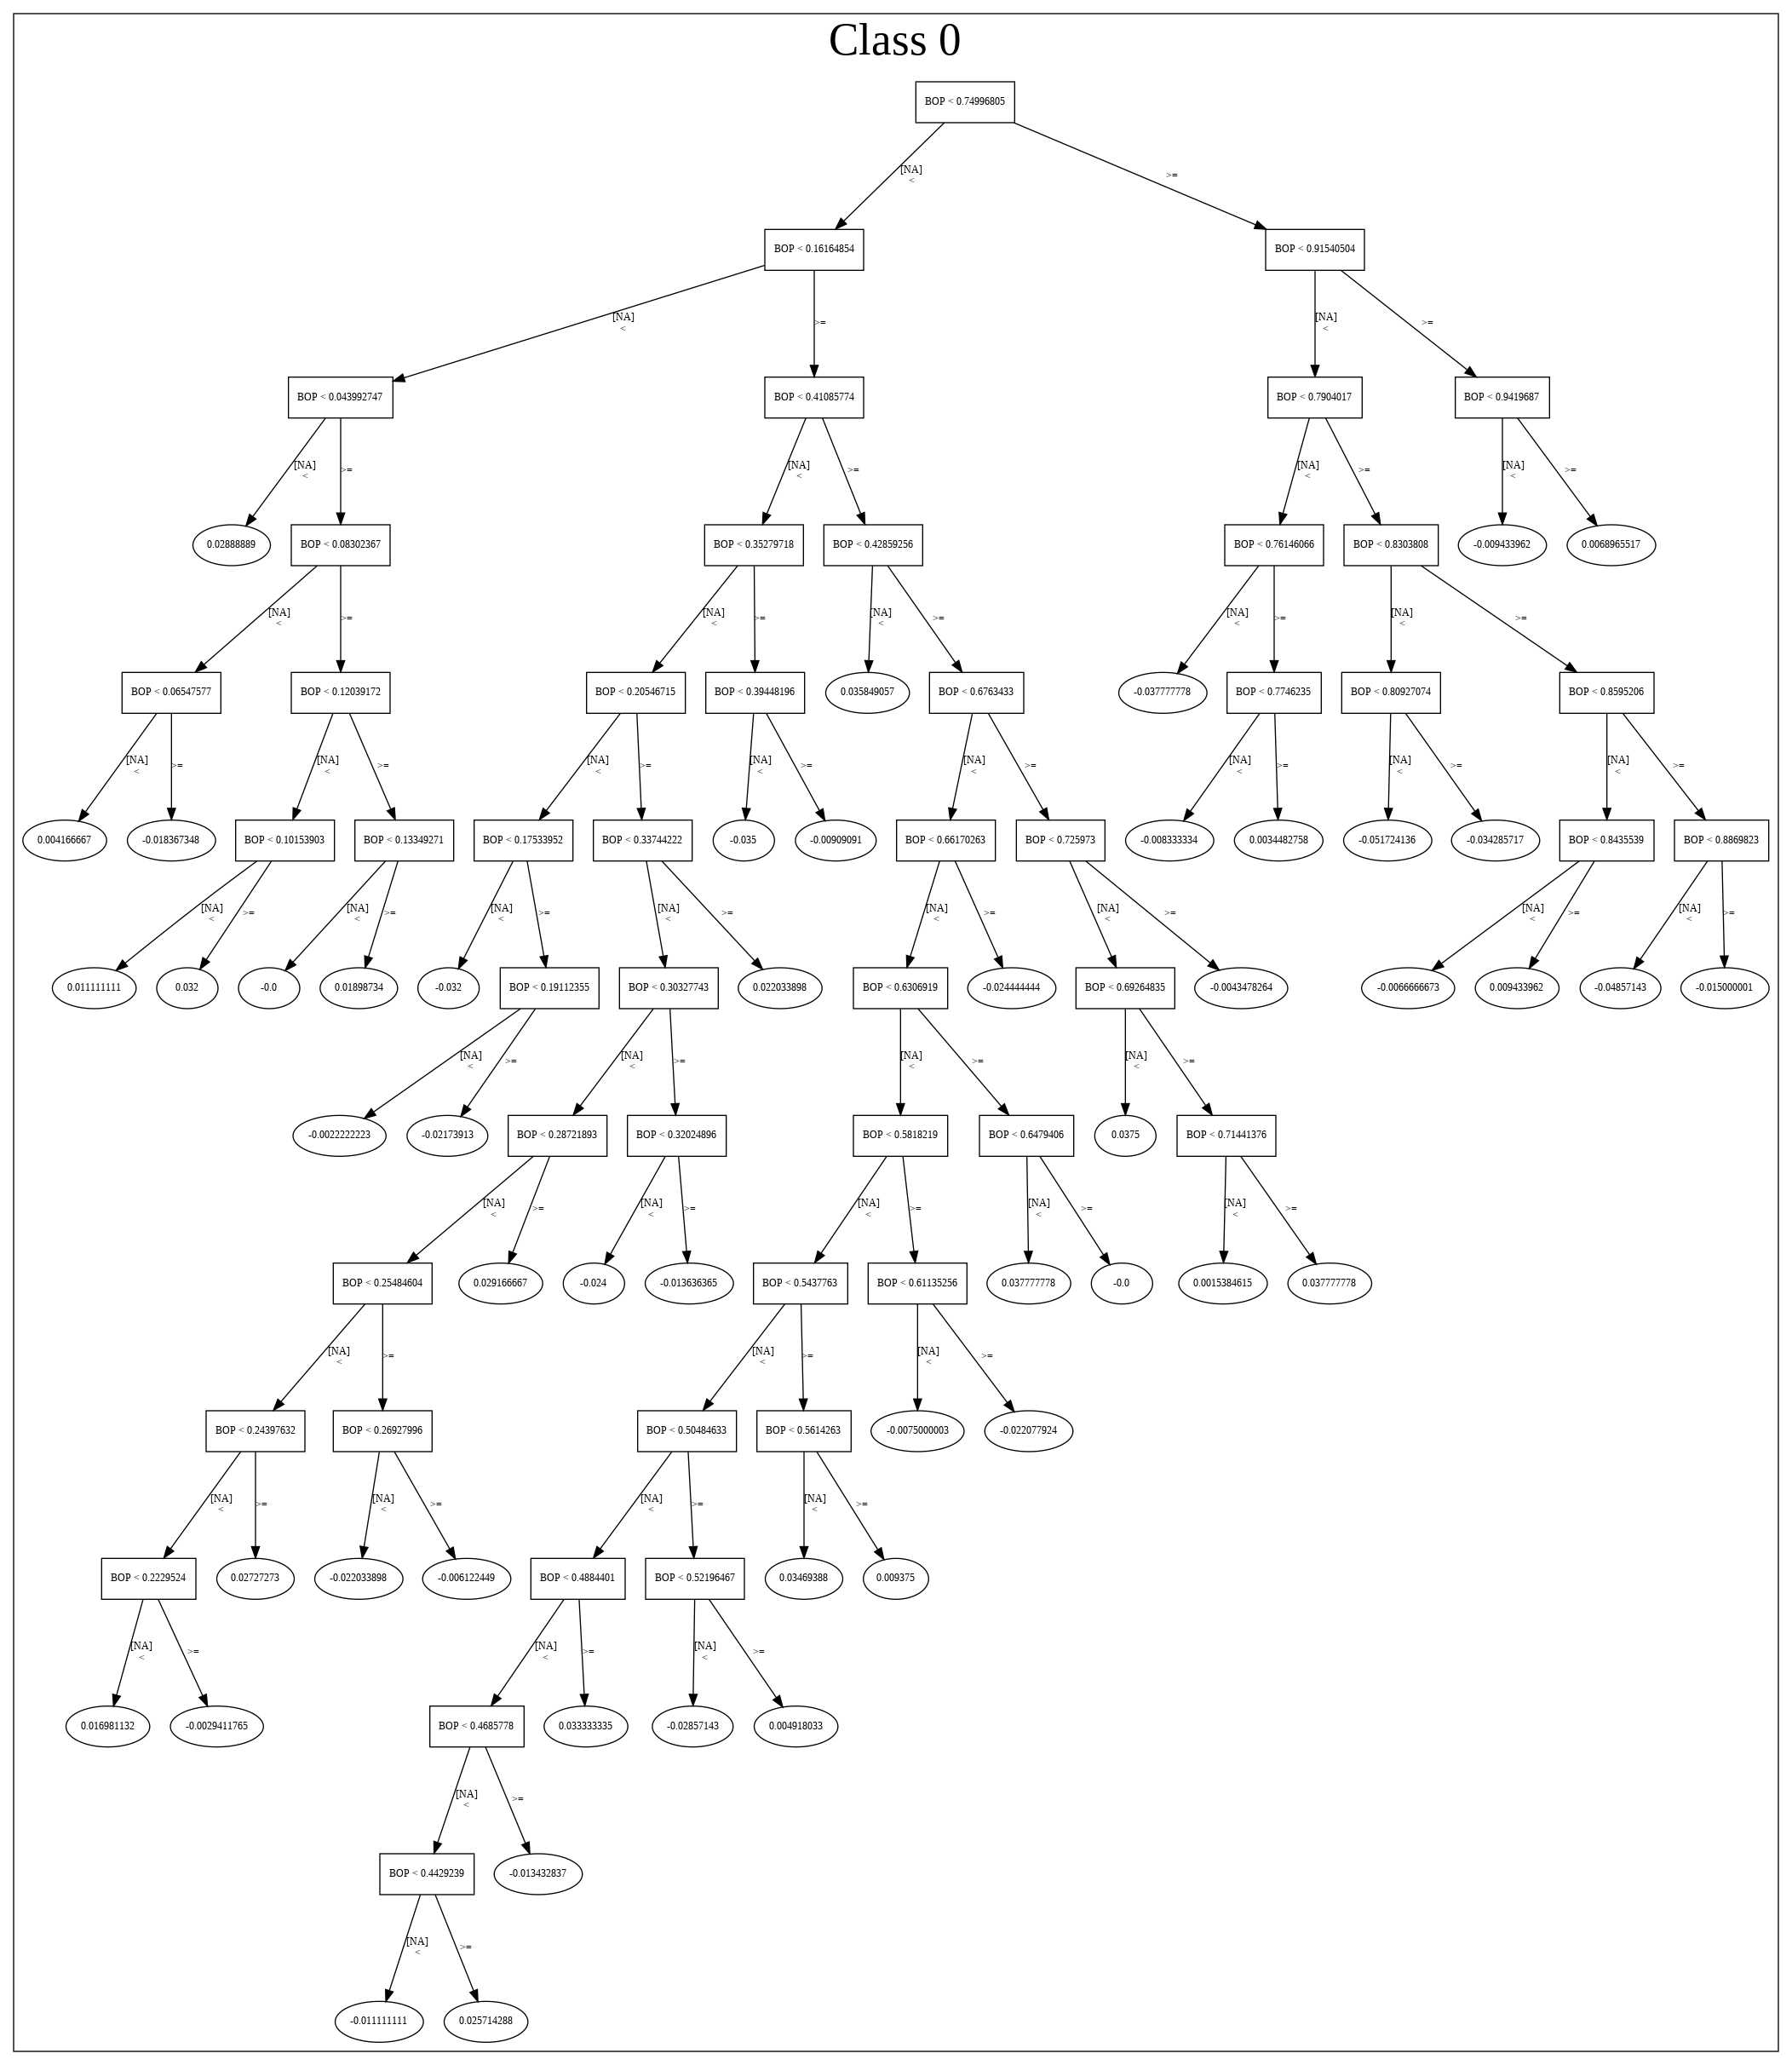

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190824_162131',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190824_162131',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_aebd',
   'type

['BOP']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

58

['BOP',
 'ADXR_8',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'DX_8',
 'MFI_8',
 'MINUS_DI_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROCR_8',
 'ROCR100_8',
 'WILLR_8',
 'aroonup_12',
 'CMO_12',
 'MINUS_DI_12',
 'PLUS_DM_12',
 'ROCP_12',
 'ROCR100_12',
 'aroonup_14',
 'AROONOSC_14',
 'MFI_14',
 'ROC_14',
 'ROCP_14',
 'CCI_20',
 'DX_20',
 'MFI_20',
 'MOM_20',
 'PLUS_DI_20',
 'aroondown_24',
 'MFI_24',
 'ROCR_24',
 'RSI_24',
 'MFI_30',
 'ROC_30',
 'RSI_30',
 'MACD',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastd',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'ATR_12',
 'NATR_24',
 'ATR_30',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'VAR_8',
 'LINEARREG_ANGLE_12',
 'STDDEV_12',
 'BETA_14',
 'STDDEV_20',
 'LINEARREG_SLOPE_30']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_162734_model_5  0.526877  0.697431              0.490626  0.502013  0.252017
1  DeepLearning_grid_1_AutoML_20190824_162734_model_3  0.512886  0.848142              0.484763  0.547732  0.300010
2               DeepLearning_1_AutoML_20190824_162734  0.512277  0.732247              0.487382  0.517103  0.267395
3  DeepLearning_grid_1_AutoML_20190824_162734_model_2  0.512192  0.931228              0.495447  0.564501  0.318661
4  DeepLearning_grid_1_AutoML_20190824_162734_model_4  0.512019  0.771732              0.500000  0.529657  0.280537
5  DeepLearning_grid_1_AutoML_20190824_162734_model_9  0.510063  0.696903              0.490626  0.501802  0.251806
6  DeepLearning_grid_1_AutoML_20190824_162734_model_7  0.507860  0.763625              0.500000  0.523842  0.274410
7  DeepLearning_grid_1_AutoML_20190824_162734_model_8  0.505857  0.747574              0.500000  0.513376  0.263555
8  DeepLearning_grid_1_AutoML_20190824_162734_model_6  0.505389  0.717548              0.495358  0.511170  0.261295
9  DeepLearning_grid_1_AutoML_20190824_162734_model_1  0.497455  1.334050              0.480389  0.613927  0.376907

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.026488
1                 ULTOSC             0.820218           0.820218    0.021726
2           aroondown_24             0.812488           0.812488    0.021521
3         STOCHRSI_fastd             0.721825           0.721825    0.019119
4                BETA_14             0.718313           0.718313    0.019026
5              aroonup_8             0.710469           0.710469    0.018819
6            AROONOSC_14             0.704536           0.704536    0.018662
7                 BETA_8             0.700446           0.700446    0.018553
8                   DX_8             0.697492           0.697492    0.018475
9                  DX_20             0.697378           0.697378    0.018472
10             STDDEV_12             0.691303           0.691303    0.018311
11           HT_DCPERIOD             0.683546           0.683546    0.018106
12     HT_PHASOR_inphase             0.680382           0.680382    0.018022
13               NATR_24             0.679869           0.679869    0.018008
14                MFI_14             0.679716           0.679716    0.018004
15                ATR_30             0.679310           0.679310    0.017993
16                TRANGE             0.664377           0.664377    0.017598
17                ADXR_8             0.662771           0.662771    0.017555
18                MFI_20             0.660459           0.660459    0.017494
19               ROCR_24             0.659847           0.659847    0.017478
20             STDDEV_20             0.654105           0.654105    0.017326
21            MINUS_DI_8             0.653206           0.653206    0.017302
22           STOCH_slowd             0.650590           0.650590    0.017233
23            aroonup_12             0.649272           0.649272    0.017198
24             ROCR100_8             0.648891           0.648891    0.017188
25                ATR_12             0.648481           0.648481    0.017177
26    LINEARREG_SLOPE_30             0.646666           0.646666    0.017129
27          STOCHF_fastd             0.645600           0.645600    0.017100
28             PLUS_DI_8             0.645089           0.645089    0.017087
29                 ADOSC             0.639550           0.639550    0.016940
30                 MFI_8             0.639251           0.639251    0.016932
31            aroonup_14             0.636832           0.636832    0.016868
32           MINUS_DI_12             0.636147           0.636147    0.016850
33            PLUS_DM_12             0.635716           0.635716    0.016839
34                MFI_24             0.634096           0.634096    0.016796
35                 CCI_8             0.633090           0.633090    0.016769
36                RSI_30             0.627210           0.627210    0.016613
37                ROC_30             0.626847           0.626847    0.016604
38            AROONOSC_8             0.625820           0.625820    0.016577
39            ROCR100_12             0.625030           0.625030    0.016556
40               WILLR_8             0.620800           0.620800    0.016444
41                 VAR_8             0.620694           0.620694    0.016441
42            PLUS_DI_20             0.620643           0.620643    0.016439
43           STOCH_slowk             0.619709           0.619709    0.016415
44                ROCR_8             0.608919           0.608919    0.016129
45    LINEARREG_ANGLE_12             0.602706           0.602706    0.015964
46                ROC_14             0.597077           0.597077    0.015815
47                  MACD             0.595906           0.595906    0.015784
48  HT_PHASOR_quadrature             0.594309           0.594309    0.015742
49               ROCP_14             0.593864           0.593864    0.015730
50                MFI_30             0.587627           0.587627    0.015565
51          

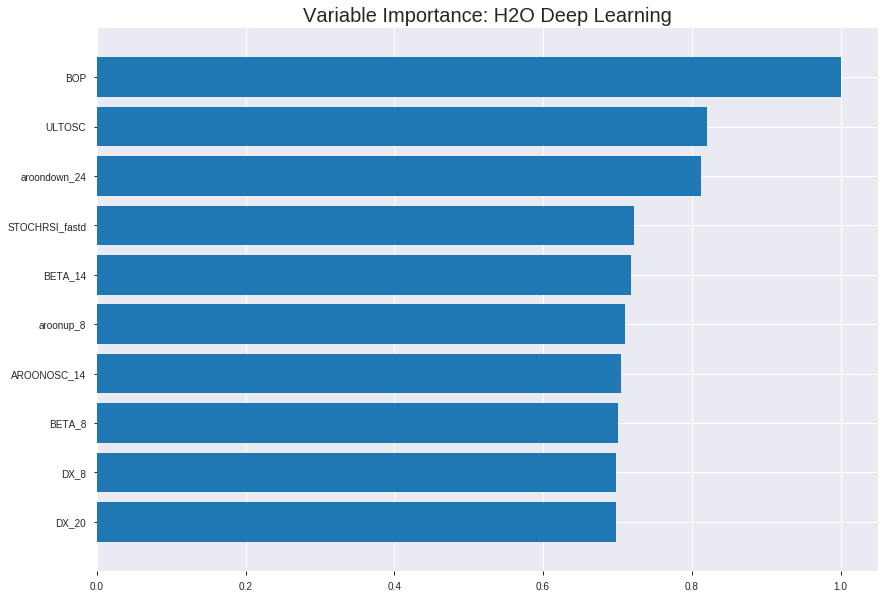

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_162734_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24651985563973994
RMSE: 0.49650765919544476
LogLoss: 0.6860029290684478
Mean Per-Class Error: 0.4540113493974661
AUC: 0.5664347113148491
pr_auc: 0.5679358492093405
Gini: 0.13286942262969825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45219018252556553: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      82   2097  0.9624   (2097.0/2179.0)
1      33   2103  0.0154   (33.0/2136.0)
Total  115  4200  0.4936   (2130.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45219      0.663826  361
max f2                       0.422407     0.830997  386
max f0point5                 0.487665     0.557884  299
max accuracy                 0.5161       0.545075  230
max precision                0.79601      1         0
max recall                   0.393722     1         395
max specificity              0.79601      1         0
max absolute_mcc             0.548354     0.108544  172
max min_per_class_accuracy   0.5161       0.454337  230
max mean_per_class_accuracy  0.5161       0.545989  230

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 52.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.696341           1.56101   1.56101            0.772727         0.725308  0.772727                    0.725308            0.0159176       0.0159176                  56.101    56.101
    2        0.0201622                   0.670615           1.59731   1.57895            0.790698         0.682081  0.781609                    0.703943            0.0159176       0.0318352                  59.7313   57.8953
    3        0.0301275                   0.649887           1.36241   1.50733            0.674419         0.660126  0.746154                    0.68945             0.0135768       0.045412                   36.2414   50.7329
    4        0.0400927                   0.634411           1.17449   1.4246             0.581395         0.641946  0.705202                    0.677642            0.0117041       0.0571161                  17.4495   42.4601
    5        0.0500579                   0.619385           1.17449   1.37481            0.581395         0.62659   0.680556                    0.667479            0.0117041       0.0688202                  17.4495   37.4811
    6        0.100116                    0.576595           1.20647   1.29064            0.597222         0.595248  0.638889                    0.631364            0.0603933       0.129213                   20.6467   29.0639
    7        0.150174                    0.549544           1.19711   1.25946            0.592593         0.562363  0.623457                    0.608364            0.0599251       0.189139                   19.7115   25.9464
    8        0.2                         0.532972           1.02416   1.20084            0.506977         0.540178  0.594438                    0.591376            0.05103         0.240169                   2.41595   20.0843
    9        0.575203                    0.516099           1.01318   1.07843            0.501544         0.517821  0.533844                    0.543397            0.38015         0.620318                   1.3185    7.84342
    10       0.6                         0.516017           1.07614   1.07834            0.53271          0.516064  0.533797                    0.542267            0.0266854       0.647004                   7.61446   7.83396
    11       0.699884                    0.506223           0.885858  1.05087            0.438515         0.511942  0.520199                    0.537939            0.0884831       0.735487                   -11.4142  5.08695
    12       0.8                         0.4928             0.935246  1.0364             0.462963         0.499692  0.513036                    0.533153            0.093633        0.82912                    -6.47541  3.63998
    13       0.899884                    0.475291           0.876484  1.01865            0.433875         0.484261  0.504249                    0.527726            0.0875468       0.916667                   -12.3516  1.86497
    14       1                           0.278892           0.832369  1                  0.412037         0.456975  0.495017                    0.520643            0.0833333       1                          -16.7631  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2508544016164327
RMSE: 0.5008536728590823
LogLoss: 0.6948995014717266
Mean Per-Class Error: 0.48108396052763436
AUC: 0.5106447223379623
pr_auc: 0.5378485306564476
Gini: 0.02128944467592464
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4090886975663869: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    585   0.9966   (585.0/587.0)
1      0    646   0        (0.0/646.0)
Total  2    1231  0.4745   (585.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.409089     0.688332   397
max f2                       0.409089     0.846658   397
max f0point5                 0.409089     0.579892   397
max accuracy                 0.417246     0.525547   393
max precision                0.784972     1          0
max recall                   0.409089     1          397
max specificity              0.784972     1          0
max absolute_mcc             0.696292     0.0614175  10
max min_per_class_accuracy   0.516098     0.465077   204
max mean_per_class_accuracy  0.516098     0.518916   204

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 51.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.695398           1.46821   1.46821            0.769231         0.719366  0.769231                    0.719366            0.0154799       0.0154799                  46.8207   46.8207
    2        0.0202758                   0.670488           0.636223  1.06885            0.333333         0.682546  0.56                        0.701692            0.00619195      0.0216718                  -36.3777  6.88545
    3        0.0300081                   0.653319           1.27245   1.13488            0.666667         0.66284   0.594595                    0.689092            0.0123839       0.0340557                  27.2446   13.4884
    4        0.0405515                   0.637041           1.17457   1.1452             0.615385         0.644183  0.6                         0.677415            0.0123839       0.0464396                  17.4565   14.5201
    5        0.0502839                   0.618956           0.954334  1.10826            0.5              0.62891   0.580645                    0.668027            0.00928793      0.0557276                  -4.56656  10.8259
    6        0.100568                    0.57779            0.923549  1.0159             0.483871         0.596116  0.532258                    0.632071            0.0464396       0.102167                   -7.64506  1.59043
    7        0.150041                    0.548954           0.93869   0.990444           0.491803         0.56095   0.518919                    0.60862             0.0464396       0.148607                   -6.13105  -0.955569
    8        0.200324                    0.529851           1.10826   1.02002            0.580645         0.53895   0.534413                    0.591132            0.0557276       0.204334                   10.8259   2.00173
    9        0.532847                    0.516099           1.03813   1.03132            0.543902         0.517601  0.540335                    0.545245            0.345201        0.549536                   3.81296   3.13202
    10       0.600162                    0.514559           0.91984   1.01882            0.481928         0.515827  0.533784                    0.541946            0.0619195       0.611455                   -8.01596  1.88164
    11       0.699919                    0.502933           0.884505  0.999674           0.463415         0.508948  0.523754                    0.537243            0.0882353       0.69969                    -11.5495  -0.0326459
    12       0.799676                    0.490975           1.00865   1.00079            0.528455         0.497036  0.524341                    0.532227            0.100619        0.80031                    0.864608  0.0792833
    13       0.899432                    0.473395           1.00865   1.00166            0.528455         0.482711  0.524797                    0.526735            0.100619        0.900929                   0.864608  0.166384
    14       1                           0.395036           0.985119  1                  0.516129         0.453139  0.523925                    0.519334            0.0990712       1                          -1.48807  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:33:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 16:33:17  2 min 40.979 sec  1033 obs/sec      0.506373  1             2185       0.506638         0.707463            -0.0268302     0.543115        0.524706           1.10189          0.504287                         0.502674           0.698901              -0.0130426       0.513416          0.540998             1.17457            0.474453
    2019-08-24 16:33:37  3 min  1.528 sec  2291 obs/sec      10.9775   22            47368      0.496508         0.686003            0.0138226      0.566435        0.567936           1.56101          0.493627                         0.500854           0.6949                -0.0057204       0.510645          0.537849             1.46821            0.474453
    2019-08-24 16:33:58  3 min 22.295 sec  2570 obs/sec      23.4285   47            101094     0.499475         0.691778            0.00199864     0.606543        0.609057           1.83648          0.47555                          0.507688           0.710619              -0.0333525       0.514985          0.545546             1.46821            0.476075
    2019-08-24 16:34:20  3 min 43.646 sec  2701 obs/sec      36.845    74            158986     0.478897         0.647166            0.0825377      0.63816         0.664561           1.97422          0.44774                          0.506795           0.710047              -0.0297211       0.501872          0.536436             1.02774            0.475264
    2019-08-24 16:34:38  4 min  2.118 sec  2788 obs/sec      48.7972   98            210560     0.470655         0.627201            0.113847       0.695593        0.720175           2.02013          0.407648                         0.513182           0.729023              -0.0558397       0.496851          0.535648             1.46821            0.475264
    2019-08-24 16:34:56  4 min 20.213 sec  2875 obs/sec      61.2222   123           264174     0.457937         0.597721            0.16109        0.736371        0.769273           2.02013          0.382851                         0.521107           0.757869              -0.0887021       0.499771          0.533122             1.17457            0.476075
    2019-08-24 16:34:58  4 min 22.045 sec  2875 obs/sec      61.2222   123           264174     0.496508         0.686003            0.0138226      0.566435        0.567936           1.56101          0.493627                         0.500854           0.6949                -0.0057204       0.510645          0.537849             1.46821            0.474453

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.026487657183796996
ULTOSC             0.8202179074287415     0.8202179074287415   0.02172565074798384
aroondown_24       0.8124875426292419     0.8124875426292419   0.021520891495269007
STOCHRSI_fastd     0.7218251824378967     0.7218251824378967   0.019119457979046732
BETA_14            0.7183130979537964     0.7183130979537964   0.019026431089231348
---                ---                    ---                  ---
RSI_24             0.5790932774543762     0.5790932774543762   0.015338824210652954
CCI_20             0.5701805949211121     0.5701805949211121   0.015102748131123838
ROCP_12            0.5667219758033752     0.5667219758033752   0.015011137413603898
MOM_20             0.5579586625099182     0.5579586625099182   0.014779017775292598
LINEARREG_ANGLE_8  0.5239830017089844     0.5239830017089844   0.013879082119404492


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5348460291734197)

('F1', 0.6578657865786579)

('auc', 0.5268769716088328)

('logloss', 0.6974312451485726)

('mean_per_class_error', 0.4616193480546793)

('rmse', 0.502013349621367)

('mse', 0.25201740319806487)

deeplearning prediction progress: |███████████████████████████████████████| 100%


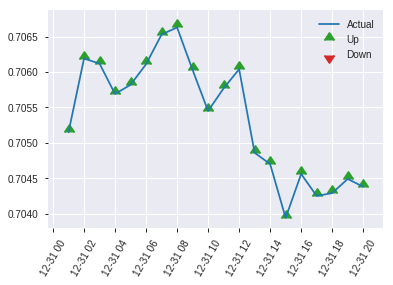


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25201740319806487
RMSE: 0.502013349621367
LogLoss: 0.6974312451485726
Mean Per-Class Error: 0.4616193480546793
AUC: 0.5268769716088328
pr_auc: 0.49858147404222464
Gini: 0.05375394321766569
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4435413850712407: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    310  0.9779   (310.0/317.0)
1      1    299  0.0033   (1.0/300.0)
Total  8    609  0.5041   (311.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.443541     0.657866   391
max f2                       0.443541     0.826423   391
max f0point5                 0.471663     0.547816   371
max accuracy                 0.516078     0.534846   202
max precision                0.688019     0.6        4
max recall                   0.355353     1          399
max specificity              0.737092     0.996845   0
max absolute_mcc             0.443541     0.0828338  391
max min_per_class_accuracy   0.516099     0.413249   201
max mean_per_class_accuracy  0.516078     0.538381   202

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 52.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.684852           1.17524   1.17524            0.571429         0.700195  0.571429                    0.700195            0.0133333       0.0133333                  17.5238   17.5238
    2        0.0210697                   0.65784            0.685556  0.949231           0.333333         0.664568  0.461538                    0.683752            0.00666667      0.02                       -31.4444  -5.07692
    3        0.0307942                   0.649524           1.02833   0.974211           0.5              0.653502  0.473684                    0.674199            0.01            0.03                       2.83333   -2.57895
    4        0.0405186                   0.628149           1.02833   0.9872             0.5              0.640277  0.48                        0.666058            0.01            0.04                       2.83333   -1.28
    5        0.0502431                   0.621661           0.685556  0.928817           0.333333         0.624221  0.451613                    0.65796             0.00666667      0.0466667                  -31.4444  -7.11828
    6        0.100486                    0.585686           1.06151   0.995161           0.516129         0.603174  0.483871                    0.630567            0.0533333       0.1                        6.15054   -0.483871
    7        0.150729                    0.560815           1.12785   1.03939            0.548387         0.570673  0.505376                    0.610602            0.0566667       0.156667                   12.7849   3.93907
    8        0.200972                    0.539613           1.06151   1.04492            0.516129         0.551413  0.508065                    0.595805            0.0533333       0.21                       6.15054   4.49194
    9        0.299838                    0.520528           1.07891   1.05613            0.52459          0.529383  0.513514                    0.573904            0.106667        0.316667                   7.89071   5.61261
    10       0.615883                    0.516099           1.04415   1.04998            0.507692         0.516424  0.510526                    0.544408            0.33            0.646667                   4.41538   4.99825
    11       0.700162                    0.512505           0.988782  1.04262            0.480769         0.51553   0.506944                    0.540932            0.0833333       0.73                       -1.12179  4.26157
    12       0.799028                    0.500444           0.910328  1.02625            0.442623         0.507123  0.498986                    0.536749            0.09            0.82                       -8.96721  2.62475
    13       0.899514                    0.484467           0.829301  1.00425            0.403226         0.492829  0.488288                    0.531842            0.0833333       0.903333                   -17.0699  0.424625
    14       1                           0.355353           0.961989  1                  0.467742         0.464033  0.486224                    0.525028            0.0966667       1                          -3.80108  0

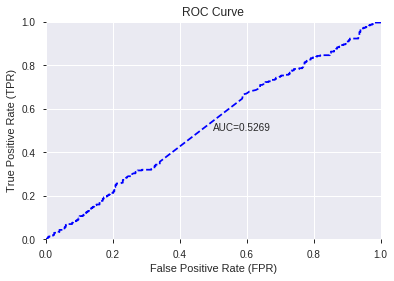

This function is available for GLM models only


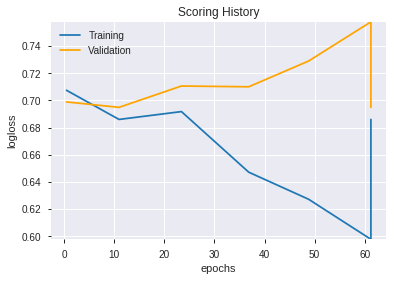

--2019-08-24 16:51:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


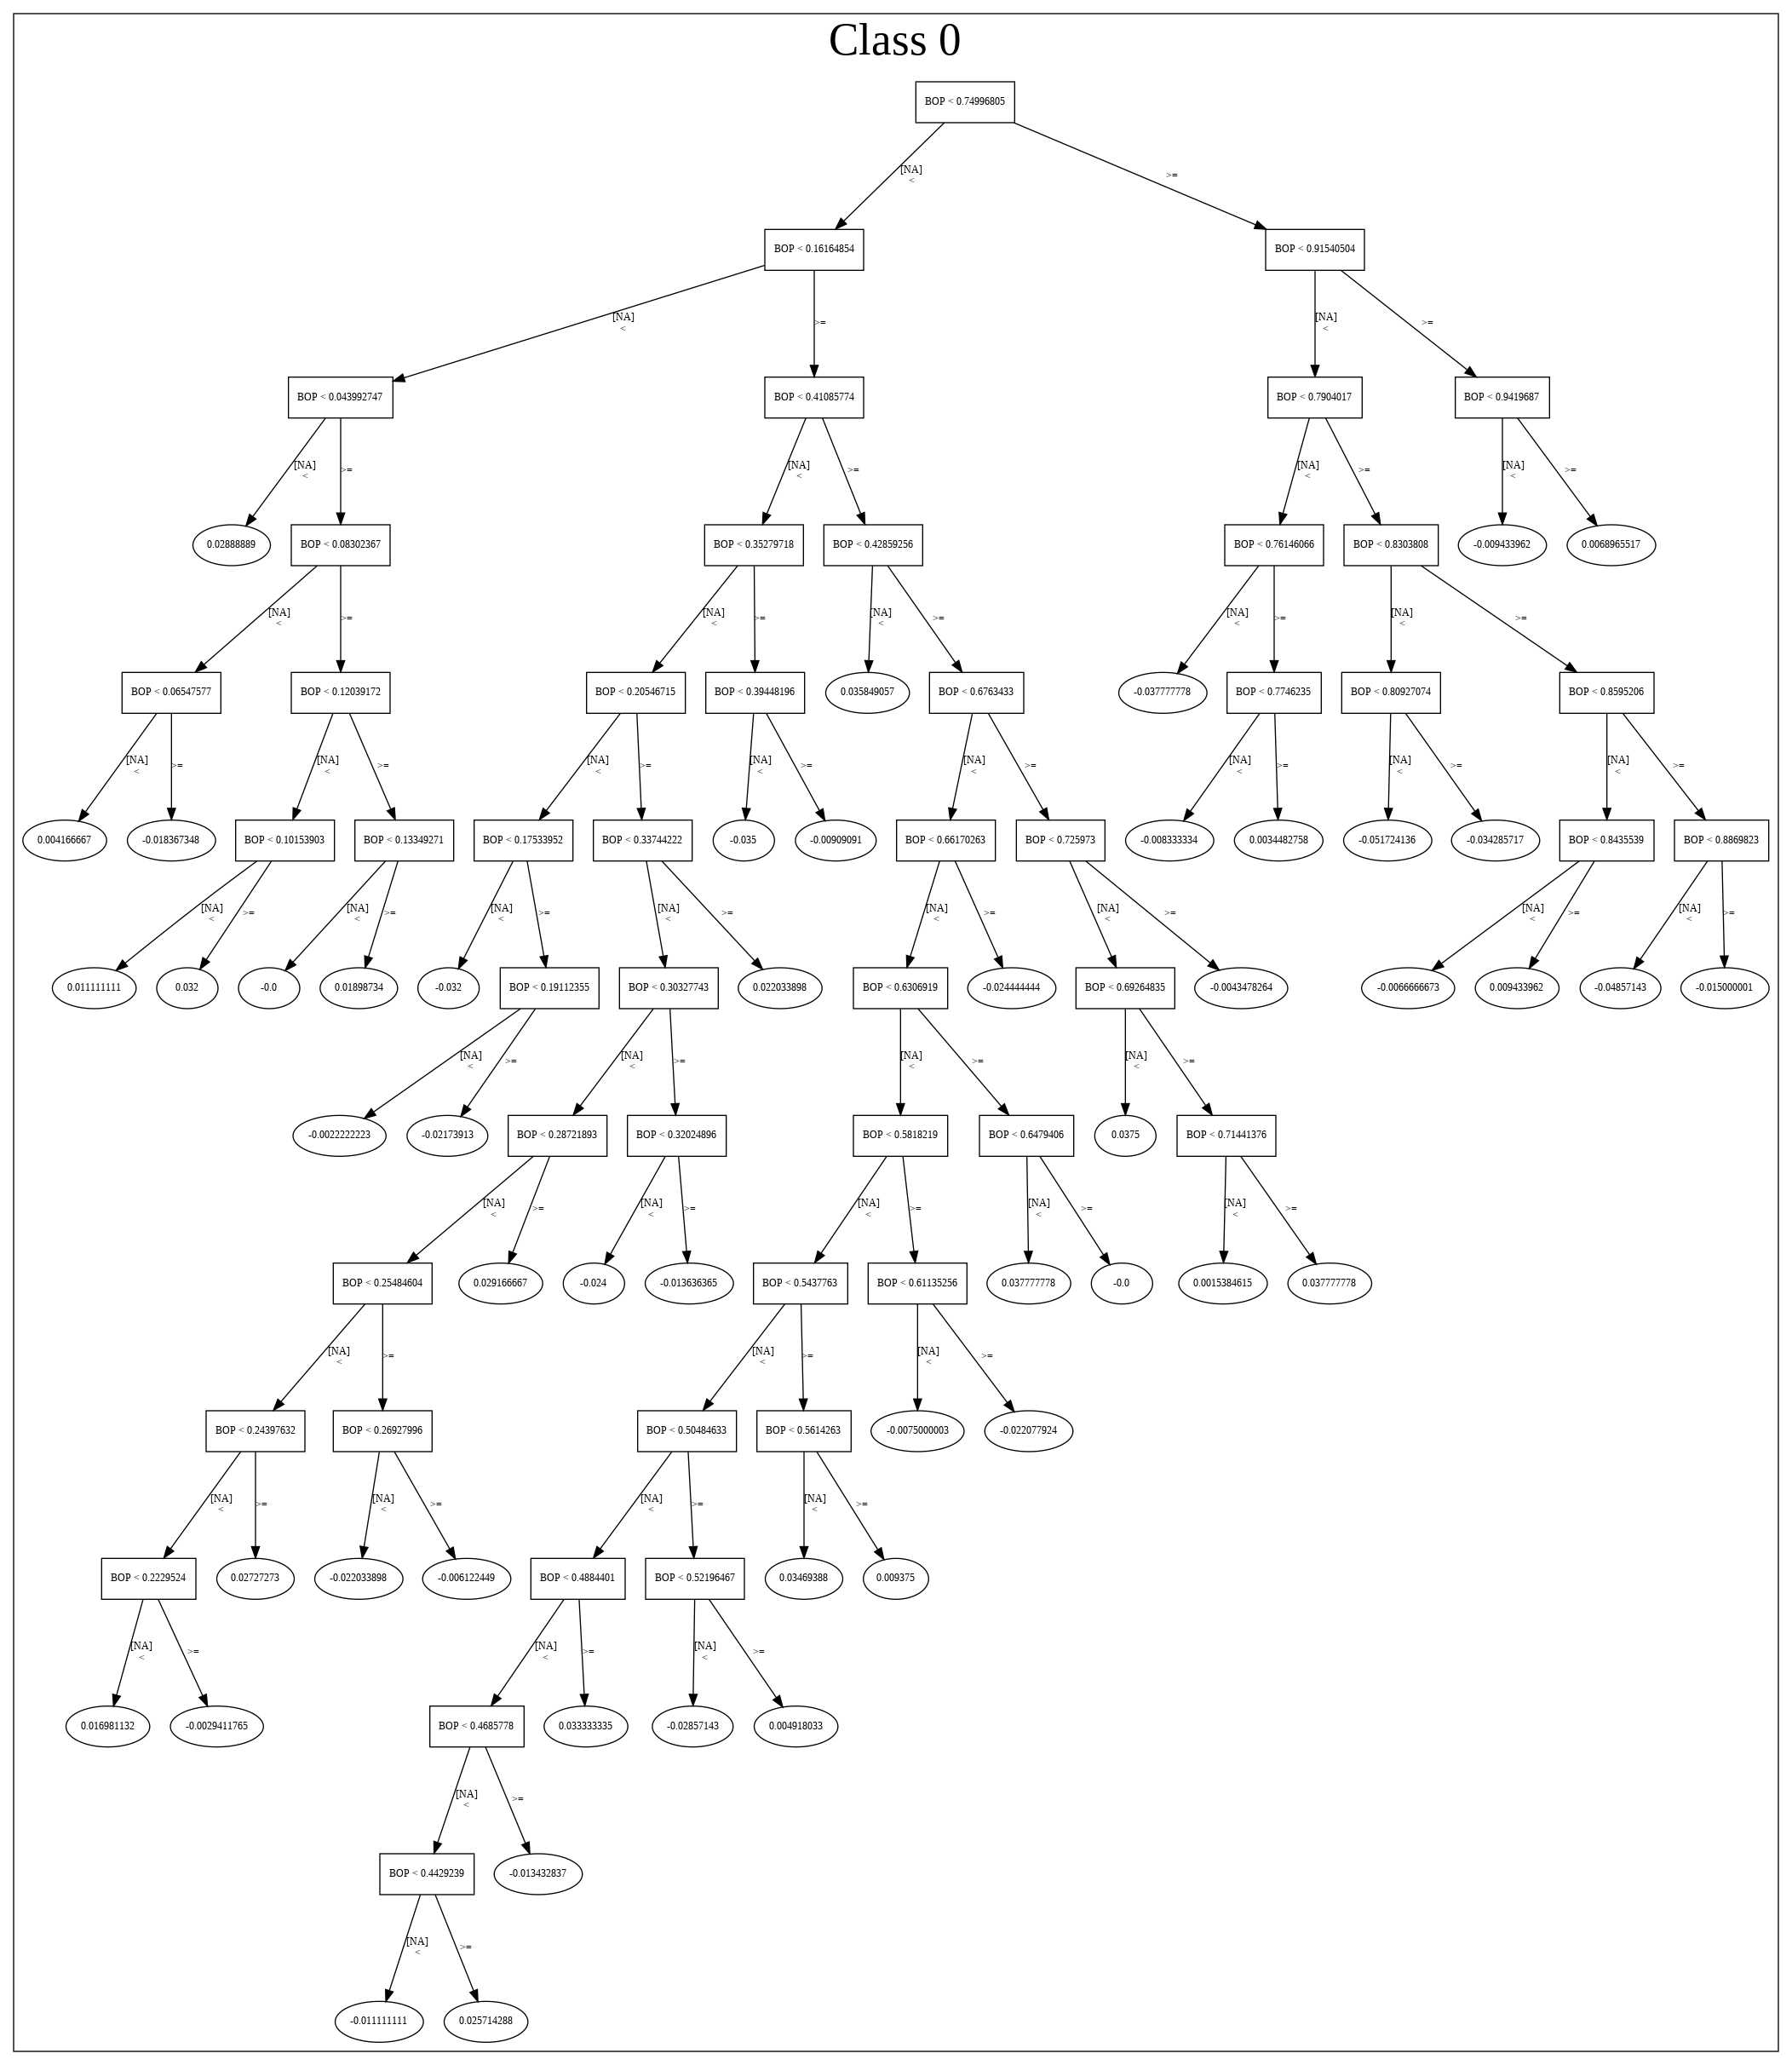

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_162734_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_162734_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'ULTOSC',
 'aroondown_24',
 'STOCHRSI_fastd',
 'BETA_14',
 'aroonup_8',
 'AROONOSC_14',
 'BETA_8',
 'DX_8',
 'DX_20',
 'STDDEV_12',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'NATR_24',
 'MFI_14',
 'ATR_30',
 'TRANGE',
 'ADXR_8',
 'MFI_20',
 'ROCR_24',
 'STDDEV_20',
 'MINUS_DI_8',
 'STOCH_slowd',
 'aroonup_12',
 'ROCR100_8',
 'ATR_12',
 'LINEARREG_SLOPE_30',
 'STOCHF_fastd',
 'PLUS_DI_8',
 'ADOSC',
 'MFI_8',
 'aroonup_14',
 'MINUS_DI_12',
 'PLUS_DM_12',
 'MFI_24',
 'CCI_8',
 'RSI_30',
 'ROC_30',
 'AROONOSC_8',
 'ROCR100_12',
 'WILLR_8',
 'VAR_8',
 'PLUS_DI_20',
 'STOCH_slowk',
 'ROCR_8',
 'LINEARREG_ANGLE_12',
 'ROC_14',
 'MACD',
 'HT_PHASOR_quadrature',
 'ROCP_14',
 'MFI_30',
 'MOM_8',
 'CMO_12',
 'RSI_24',
 'CCI_20',
 'ROCP_12',
 'MOM_20',
 'LINEARREG_ANGLE_8']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_165247_model_1  0.528785  0.691816              0.482829  0.499335  0.249335

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.008360           1.000000    0.093525
1                 ULTOSC             0.005764           0.689452    0.064481
2                WILLR_8             0.004947           0.591748    0.055343
3                  CCI_8             0.003756           0.449277    0.042019
4                  MOM_8             0.003139           0.375495    0.035118
5                 ROCR_8             0.003095           0.370229    0.034626
6              ROCR100_8             0.003093           0.370010    0.034605
7                  DX_20             0.002840           0.339762    0.031776
8                  MFI_8             0.002647           0.316667    0.029616
9                  ADOSC             0.002600           0.310949    0.029081
10          aroondown_24             0.002430           0.290640    0.027182
11             aroonup_8             0.002082           0.249007    0.023288
12             PLUS_DI_8             0.001965           0.235063    0.021984
13               NATR_24             0.001905           0.227901    0.021314
14                ATR_30             0.001893           0.226417    0.021176
15                CMO_12             0.001888           0.225802    0.021118
16  HT_PHASOR_quadrature             0.001816           0.217203    0.020314
17                ATR_12             0.001724           0.206252    0.019290
18          STOCHF_fastd             0.001697           0.202964    0.018982
19           STOCH_slowk             0.001691           0.202302    0.018920
20                 VAR_8             0.001653           0.197736    0.018493
21     HT_PHASOR_inphase             0.001594           0.190662    0.017832
22        STOCHRSI_fastd             0.001556           0.186154    0.017410
23           AROONOSC_14             0.001485           0.177661    0.016616
24           HT_DCPERIOD             0.001456           0.174172    0.016289
25            AROONOSC_8             0.001410           0.168642    0.015772
26               BETA_14             0.001348           0.161233    0.015079
27                BETA_8             0.001327           0.158686    0.014841
28            MINUS_DI_8             0.001172           0.140151    0.013108
29                MFI_14             0.001101           0.131708    0.012318
30                  DX_8             0.000990           0.118360    0.011070
31             STDDEV_12             0.000967           0.115669    0.010818
32                ROC_30             0.000932           0.111537    0.010431
33                TRANGE             0.000928           0.110983    0.010380
34               ROCP_14             0.000866           0.103567    0.009686
35                ROC_14             0.000864           0.103329    0.009664
36               ROCP_12             0.000861           0.103033    0.009636
37            ROCR100_12             0.000848           0.101395    0.009483
38                RSI_24             0.000846           0.101199    0.009465
39           MINUS_DI_12             0.000748           0.089414    0.008362
40                MFI_20             0.000705           0.084378    0.007891
41                  MACD             0.000668           0.079856    0.007468
42                RSI_30             0.000631           0.075536    0.007064
43               ROCR_24             0.000534           0.063825    0.005969
44           STOCH_slowd             0.000494           0.059091    0.005527
45             STDDEV_20             0.000491           0.058701    0.005490
46     LINEARREG_ANGLE_8             0.000485           0.058047    0.005429
47                MOM_20             0.000450           0.053799    0.005032
48    LINEARREG_ANGLE_12             0.000448           0.053592    0.005012
49            PLUS_DI_20             0.000434           0.051969    0.004860
50                CCI_20             0.000390           0.046611    0.004359
51          

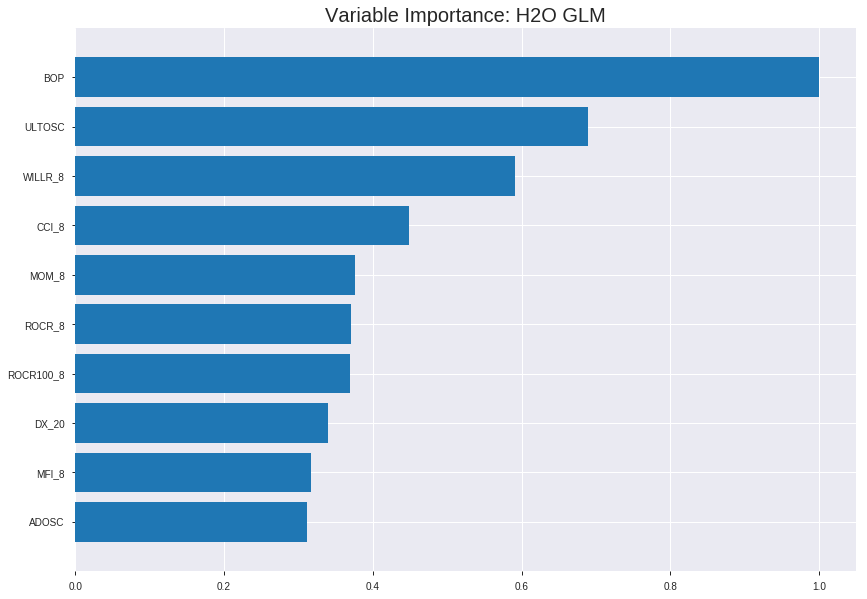

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_165247_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2494145674872511
RMSE: 0.49941422435414384
LogLoss: 0.6919755865137125
Null degrees of freedom: 4314
Residual degrees of freedom: 4256
Null deviance: 5981.431655925498
Residual deviance: 5971.749311613339
AIC: 6089.749311613339
AUC: 0.5343146101792219
pr_auc: 0.5196737844401844
Gini: 0.06862922035844377
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.464139572854384: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      8    2171  0.9963   (2171.0/2179.0)
1      1    2135  0.0005   (1.0/2136.0)
Total  9    4306  0.5034   (2172.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.46414      0.662838   392
max f2                       0.46414      0.830739   392
max f0point5                 0.481333     0.554814   314
max accuracy                 0.50127      0.529085   136
max precision                0.52626      1          0
max recall                   0.458815     1          398
max specificity              0.52626      1          0
max absolute_mcc             0.481333     0.0614268  314
max min_per_class_accuracy   0.495681     0.520881   188
max mean_per_class_accuracy  0.50127      0.527343   136

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010197                    0.517501           1.1478    1.1478             0.568182         0.519433  0.568182                    0.519433            0.0117041       0.0117041                  14.7802    14.7802
    2        0.0201622                   0.515549           1.12752   1.13777            0.55814          0.516547  0.563218                    0.518006            0.011236        0.0229401                  12.7515    13.7775
    3        0.0301275                   0.514056           0.610737  0.963447           0.302326         0.514721  0.476923                    0.51692             0.00608614      0.0290262                  -38.9263   -3.65529
    4        0.0400927                   0.513024           1.17449   1.0159             0.581395         0.513536  0.50289                     0.516079            0.0117041       0.0407303                  17.4495    1.59041
    5        0.0500579                   0.51226            0.892616  0.991361           0.44186          0.512659  0.490741                    0.515398            0.00889513      0.0496255                  -10.7384   -0.863937
    6        0.100116                    0.509176           1.1223    1.05683            0.555556         0.510457  0.523148                    0.512928            0.0561798       0.105805                   12.2295    5.68278
    7        0.150174                    0.50723            1.141     1.08489            0.564815         0.508129  0.537037                    0.511328            0.0571161       0.162921                   14.1       8.48852
    8        0.2                         0.505195           1.06174   1.07912            0.525581         0.50617   0.534183                    0.510043            0.0529026       0.215824                   6.17433    7.91199
    9        0.300116                    0.502089           1.07553   1.07792            0.532407         0.503578  0.533591                    0.507886            0.107678        0.323502                   7.55328    7.79232
    10       0.4                         0.49878            0.998348  1.05805            0.4942           0.50038   0.523754                    0.506012            0.0997191       0.423221                   -0.165215  5.80524
    11       0.500116                    0.495637           0.991361  1.0447             0.490741         0.497199  0.517146                    0.504248            0.0992509       0.522472                   -0.863937  4.47017
    12       0.6                         0.492333           0.993661  1.0362             0.491879         0.494067  0.512939                    0.502553            0.0992509       0.621723                   -0.633923  3.62047
    13       0.699884                    0.488781           1.05459   1.03883            0.522042         0.490437  0.514238                    0.500824            0.105337        0.72706                    5.45928    3.8829
    14       0.8                         0.484959           0.93057   1.02528            0.460648         0.48695   0.507532                    0.499087            0.0931648       0.820225                   -6.94304   2.52809
    15       0.899884                    0.479668           0.932729  1.01501            0.461717         0.482533  0.502447                    0.49725             0.0931648       0.91339                    -6.72713   1.50079
    16       1                           0.457076           0.865102  1                  0.428241         0.474949  0.495017                  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2503204366607356
RMSE: 0.5003203340468341
LogLoss: 0.6937885818372284
Null degrees of freedom: 1232
Residual degrees of freedom: 1174
Null deviance: 1710.5993345457732
Residual deviance: 1710.8826428106051
AIC: 1828.8826428106051
AUC: 0.506263152620503
pr_auc: 0.5349395222570899
Gini: 0.012526305241006064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46465771097253733: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    583   0.9932   (583.0/587.0)
1      1    645   0.0015   (1.0/646.0)
Total  5    1228  0.4736   (584.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.464658     0.688367   395
max f2                       0.462124     0.846658   397
max f0point5                 0.464658     0.580245   395
max accuracy                 0.486038     0.527981   273
max precision                0.518547     1          0
max recall                   0.462124     1          397
max specificity              0.518547     1          0
max absolute_mcc             0.51711      0.0470772  1
max min_per_class_accuracy   0.494751     0.492334   188
max mean_per_class_accuracy  0.489049     0.518037   246

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.514854           1.32139   1.32139            0.692308         0.516326  0.692308                    0.516326            0.0139319       0.0139319                  32.1386   32.1386
    2        0.0202758                   0.512598           1.11339   1.22155            0.583333         0.51365   0.64                        0.515041            0.0108359       0.0247678                  11.339    22.1548
    3        0.0300081                   0.511875           0.954334  1.13488            0.5              0.512154  0.594595                    0.514105            0.00928793      0.0340557                  -4.56656  13.4884
    4        0.0405515                   0.511001           1.02774   1.10703            0.538462         0.511443  0.58                        0.513413            0.0108359       0.0448916                  2.77447   10.7028
    5        0.0502839                   0.510444           0.954334  1.07747            0.5              0.510658  0.564516                    0.51288             0.00928793      0.0541796                  -4.56656  7.74743
    6        0.100568                    0.507826           1.04669   1.06208            0.548387         0.509101  0.556452                    0.51099             0.0526316       0.106811                   4.66893   6.20818
    7        0.150041                    0.506209           1.00127   1.04203            0.52459          0.50694   0.545946                    0.509655            0.0495356       0.156347                   0.126884  4.203
    8        0.200324                    0.504123           0.985119  1.02774            0.516129         0.505153  0.538462                    0.508525            0.0495356       0.205882                   -1.48807  2.77447
    9        0.300081                    0.501321           1.0552    1.03687            0.552846         0.50269   0.543243                    0.506585            0.105263        0.311146                   5.5199    3.68714
    10       0.399838                    0.498223           0.837952  0.987242           0.439024         0.49977   0.517241                    0.504885            0.0835913       0.394737                   -16.2048  -1.27576
    11       0.500406                    0.494727           0.985119  0.986816           0.516129         0.496432  0.517018                    0.503186            0.0990712       0.493808                   -1.48807  -1.31842
    12       0.600162                    0.491437           1.02416   0.993024           0.536585         0.493026  0.52027                     0.501497            0.102167        0.595975                   2.41637   -0.69764
    13       0.699919                    0.48768            1.17934   1.01958            0.617886         0.489695  0.534183                    0.499815            0.117647        0.713622                   17.934    1.95785
    14       0.799676                    0.484042           0.884505  1.00273            0.463415         0.486005  0.525355                    0.498092            0.0882353       0.801858                   -11.5495  0.27286
    15       0.899432                    0.478928           0.946576  0.996501           0.495935         0.48166   0.522092                    0.49627             0.0944272       0.896285                   -5.34245  -0.349937
    16       1                           0.458588           1.0313    1                  0.540323         0.473253  0.523925                    0.493955      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 16:52:47  0.000 sec   2            3.3       59            1.38395           1.38758
    2019-08-24 16:52:47  0.012 sec   3            2.1       59            1.38326           1.38788
    2019-08-24 16:52:47  0.031 sec   5            1.3       59            1.3824            1.38832
    2019-08-24 16:52:48  0.059 sec   7            0.8       59            1.38138           1.3889
    2019-08-24 16:52:48  0.087 sec   9            0.5       59            1.38024           1.38963

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5332252836304701)

('F1', 0.6607538802660754)

('auc', 0.5287854889589906)

('logloss', 0.6918158158769585)

('mean_per_class_error', 0.45953207150368036)

('rmse', 0.4993345501054847)

('mse', 0.24933499292904682)

glm prediction progress: |████████████████████████████████████████████████| 100%


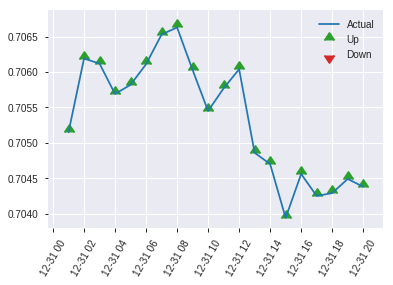


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24933499292904682
RMSE: 0.4993345501054847
LogLoss: 0.6918158158769585
Null degrees of freedom: 616
Residual degrees of freedom: 558
Null deviance: 855.0660663376912
Residual deviance: 853.7007167921668
AIC: 971.7007167921668
AUC: 0.5287854889589906
pr_auc: 0.5121966528799131
Gini: 0.05757097791798116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47482394199905315: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   304  0.959    (304.0/317.0)
1      2    298  0.0067   (2.0/300.0)
Total  15   602  0.4959   (306.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474824     0.660754  384
max f2                       0.471053     0.826881  390
max f0point5                 0.486284     0.554078  299
max accuracy                 0.487578     0.533225  285
max precision                0.523329     1         0
max recall                   0.465587     1         397
max specificity              0.523329     1         0
max absolute_mcc             0.474824     0.111451  384
max min_per_class_accuracy   0.496963     0.5       184
max mean_per_class_accuracy  0.487578     0.540468  285

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 49.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.51756            1.46905   1.46905            0.714286         0.519775  0.714286                    0.519775            0.0166667       0.0166667                  46.9048    46.9048
    2        0.0210697                   0.515285           1.37111   1.42385            0.666667         0.516247  0.692308                    0.518146            0.0133333       0.03                       37.1111    42.3846
    3        0.0307942                   0.514176           1.37111   1.40719            0.666667         0.514543  0.684211                    0.517009            0.0133333       0.0433333                  37.1111    40.7193
    4        0.0405186                   0.513461           1.02833   1.31627            0.5              0.513808  0.64                        0.51624             0.01            0.0533333                  2.83333    31.6267
    5        0.0502431                   0.512785           0.685556  1.19419            0.333333         0.513306  0.580645                    0.515673            0.00666667      0.06                       -31.4444   19.4194
    6        0.100486                    0.510078           0.995161  1.09468            0.483871         0.511502  0.532258                    0.513588            0.05            0.11                       -0.483871  9.46774
    7        0.150729                    0.508435           1.06151   1.08362            0.516129         0.509228  0.526882                    0.512134            0.0533333       0.163333                   6.15054    8.36201
    8        0.200972                    0.506136           1.26054   1.12785            0.612903         0.5072    0.548387                    0.510901            0.0633333       0.226667                   26.0538    12.7849
    9        0.299838                    0.502723           0.80918   1.02277            0.393443         0.504427  0.497297                    0.508766            0.08            0.306667                   -19.082    2.27748
    10       0.400324                    0.499308           1.06151   1.0325             0.516129         0.501005  0.502024                    0.506818            0.106667        0.413333                   6.15054    3.24966
    11       0.50081                     0.496897           0.862473  0.998382           0.419355         0.498098  0.485437                    0.505068            0.0866667       0.5                        -13.7527   -0.161812
    12       0.599676                    0.492997           1.14634   1.02277            0.557377         0.495117  0.497297                    0.503428            0.113333        0.613333                   14.6339    2.27748
    13       0.700162                    0.489507           1.12785   1.03785            0.548387         0.491248  0.50463                     0.50168             0.113333        0.726667                   12.7849    3.78549
    14       0.799028                    0.485788           1.07891   1.04293            0.52459          0.487785  0.507099                    0.49996             0.106667        0.833333                   7.89071    4.29344
    15       0.899514                    0.481042           0.729785  1.00795            0.354839         0.483574  0.49009                     0.49813             0.0733333       0.906667                   -27.0215   0.795195
    16       1                           0.461248           0.928817  1                  0.451613         0.476223  0.486224                 

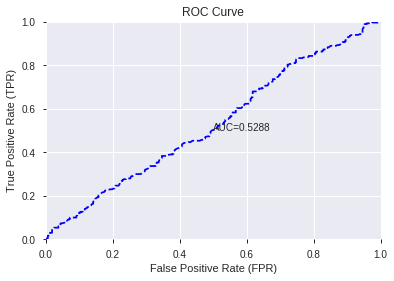

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


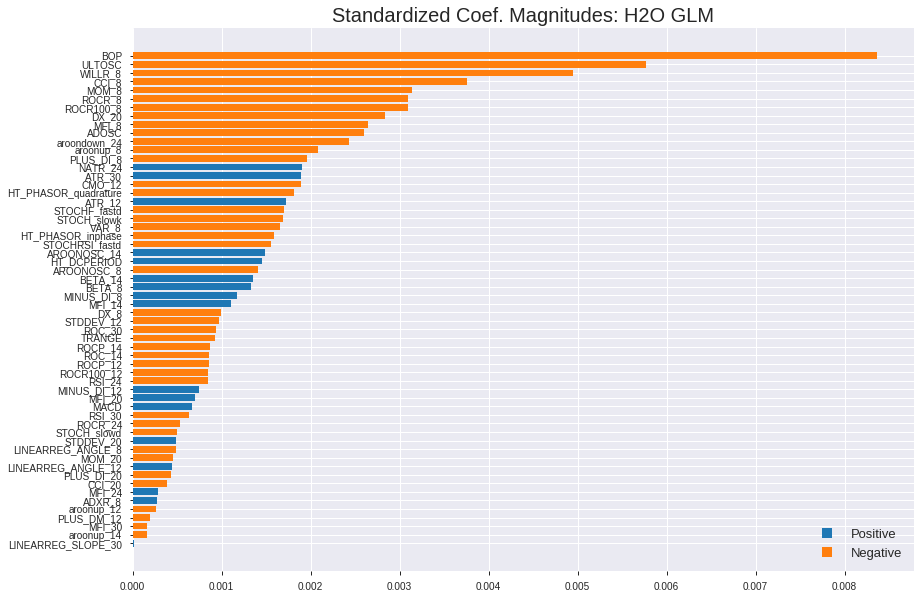

'log_likelihood'
--2019-08-24 16:52:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.20
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.20|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


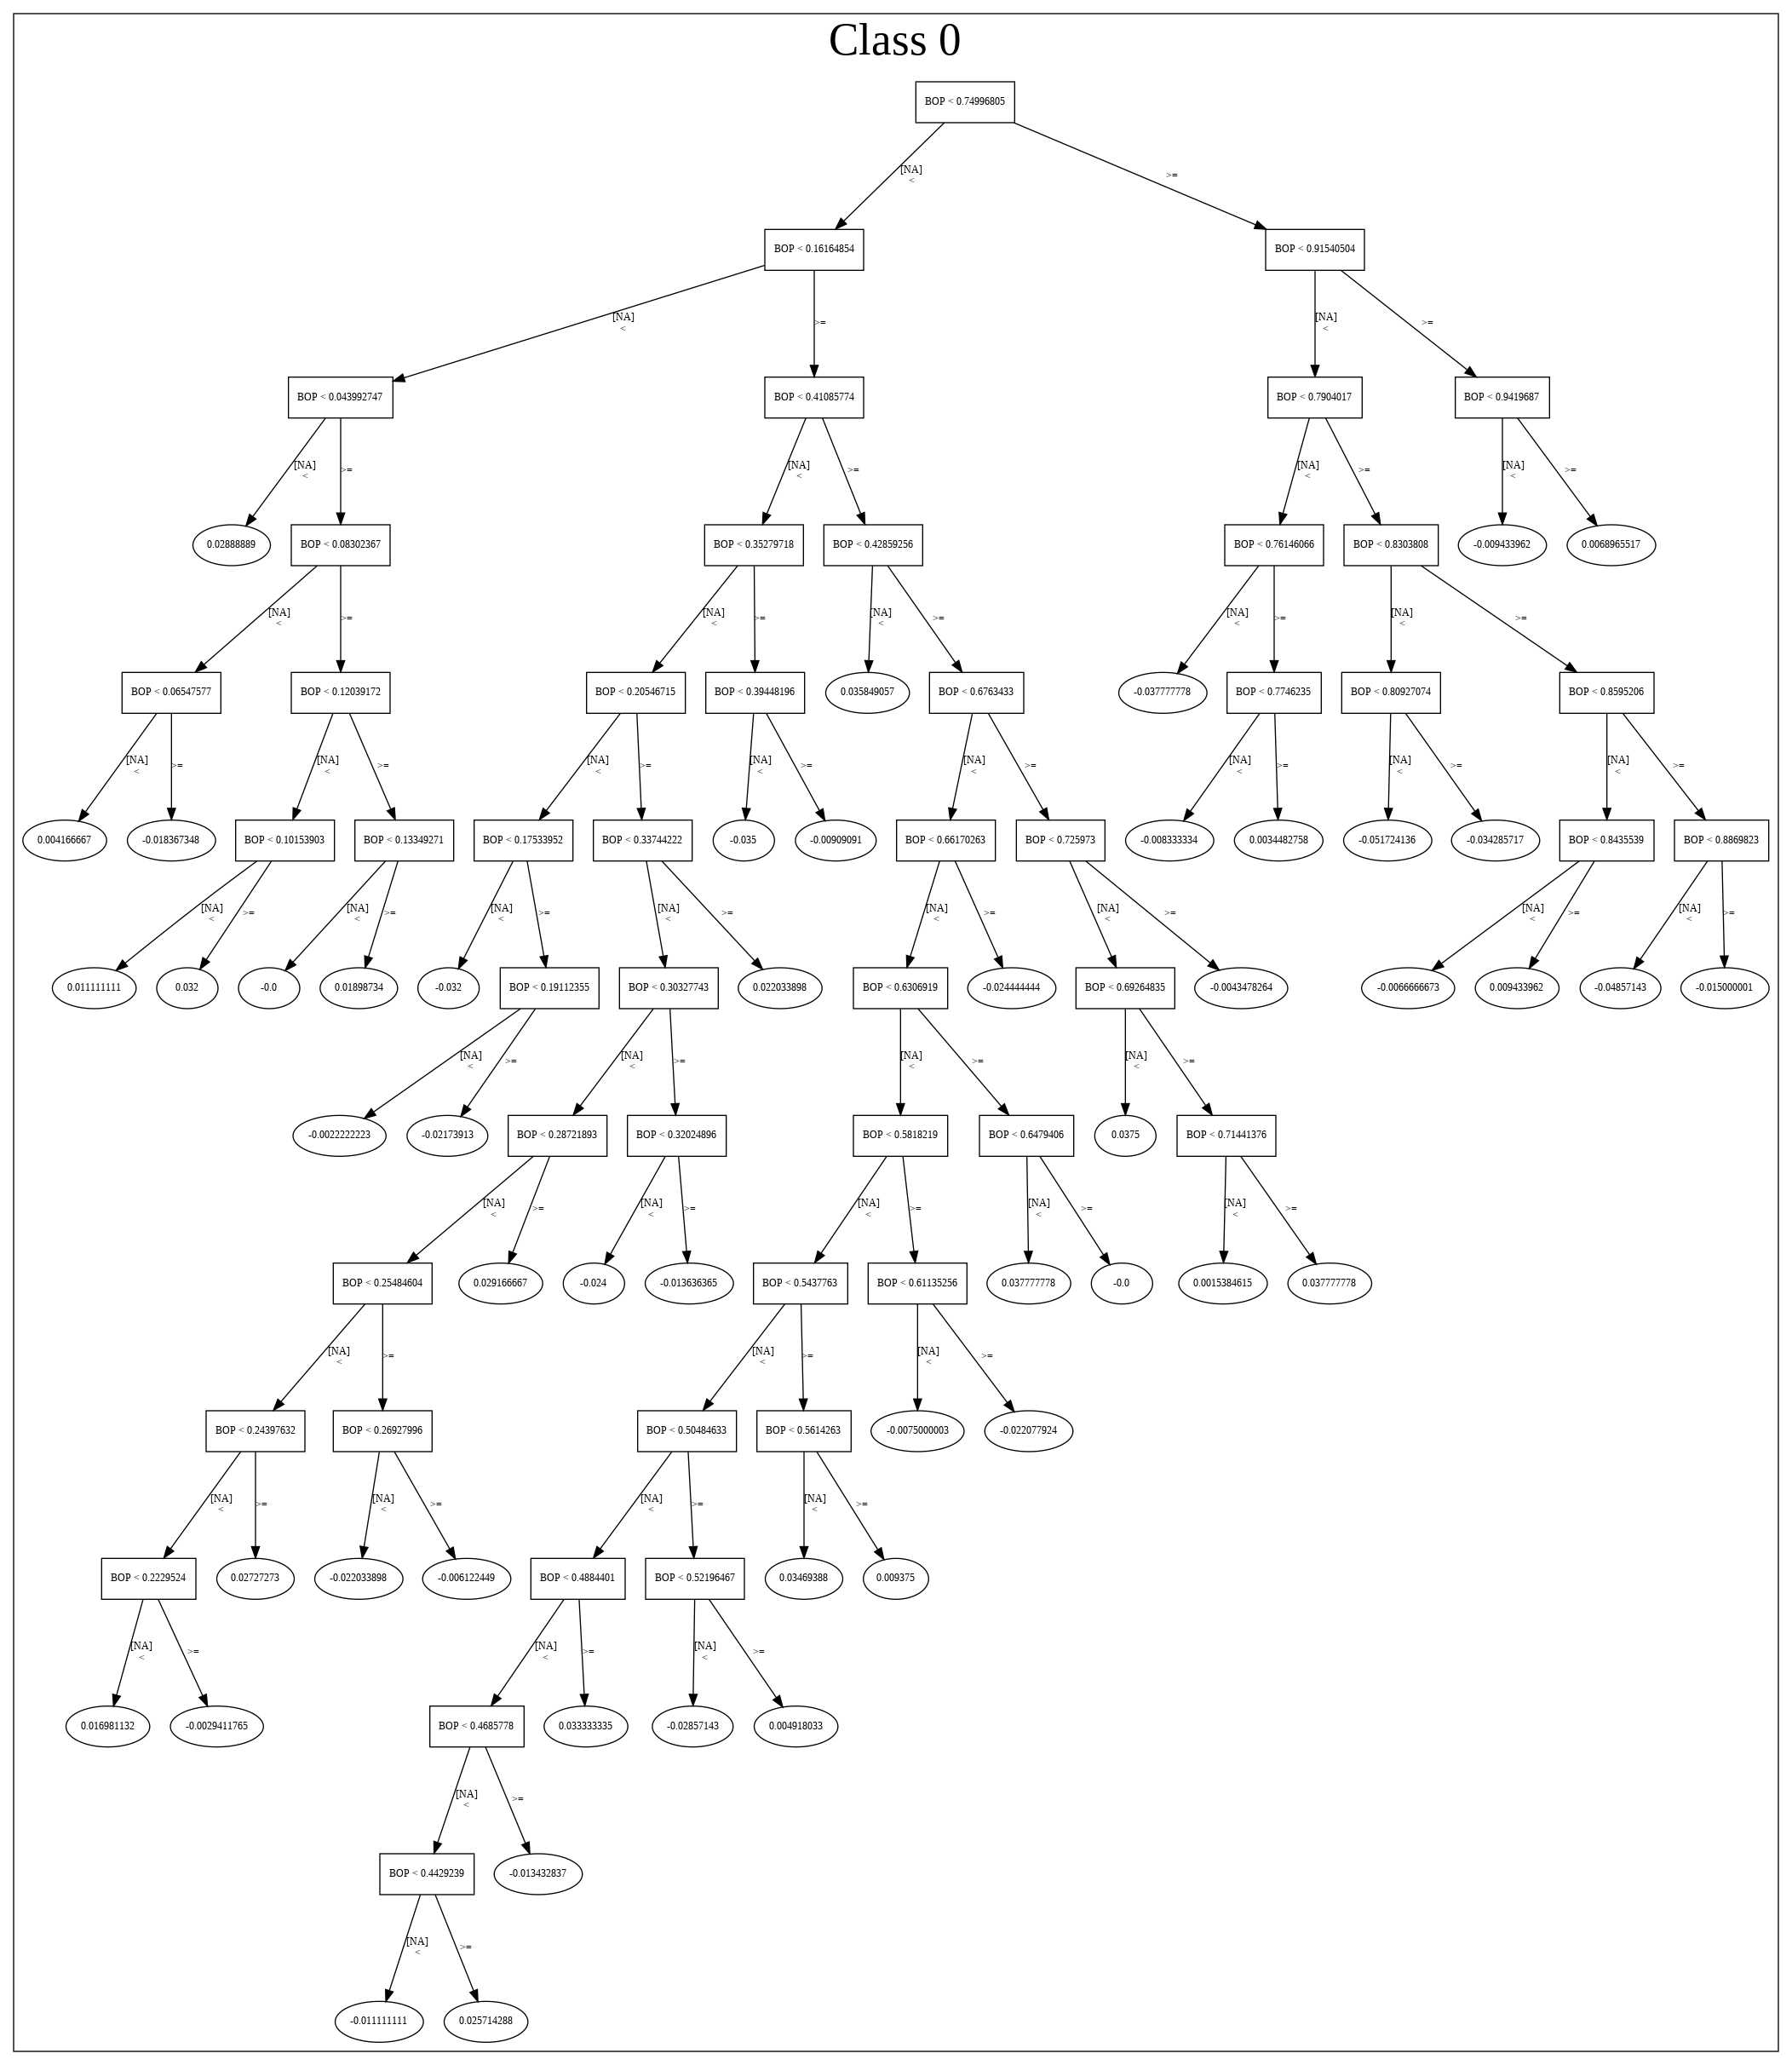

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_165247_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_165247_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'ULTOSC',
 'WILLR_8',
 'CCI_8',
 'MOM_8',
 'ROCR_8',
 'ROCR100_8',
 'DX_20',
 'MFI_8',
 'ADOSC',
 'aroondown_24',
 'aroonup_8',
 'PLUS_DI_8',
 'NATR_24',
 'ATR_30',
 'CMO_12',
 'HT_PHASOR_quadrature',
 'ATR_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'VAR_8',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'AROONOSC_14',
 'HT_DCPERIOD',
 'AROONOSC_8',
 'BETA_14',
 'BETA_8',
 'MINUS_DI_8',
 'MFI_14',
 'DX_8',
 'STDDEV_12',
 'ROC_30',
 'TRANGE',
 'ROCP_14',
 'ROC_14',
 'ROCP_12',
 'ROCR100_12',
 'RSI_24',
 'MINUS_DI_12',
 'MFI_20',
 'MACD',
 'RSI_30',
 'ROCR_24',
 'STOCH_slowd',
 'STDDEV_20',
 'LINEARREG_ANGLE_8',
 'MOM_20',
 'LINEARREG_ANGLE_12',
 'PLUS_DI_20',
 'CCI_20',
 'MFI_24',
 'ADXR_8',
 'aroonup_12',
 'PLUS_DM_12',
 'MFI_30',
 'aroonup_14',
 'LINEARREG_SLOPE_30']

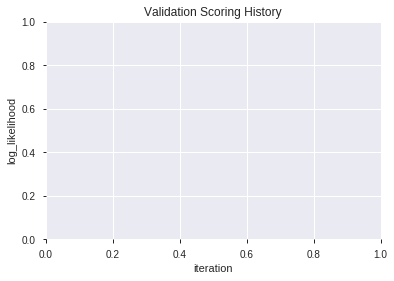

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190824_165355  0.534401  0.699531              0.495268  0.502867  0.252875
1  XGBoost_grid_1_AutoML_20190824_165355_model_7  0.530815  0.697039              0.484317  0.501884  0.251887
2  XGBoost_grid_1_AutoML_20190824_165355_model_1  0.528423  0.696008              0.496845  0.501334  0.251336
3  XGBoost_grid_1_AutoML_20190824_165355_model_4  0.528155  0.694364              0.484495  0.500580  0.250581
4               XGBoost_3_AutoML_20190824_165355  0.527103  0.694794              0.492114  0.500778  0.250778
5               XGBoost_1_AutoML_20190824_165355  0.526861  0.701730              0.490894  0.504017  0.254033
6  XGBoost_grid_1_AutoML_20190824_165355_model_2  0.520931  0.695835              0.478633  0.501298  0.251300
7  XGBoost_grid_1_AutoML_20190824_165355_model_6  0.501167  0.698087              0.489048  0.502459  0.252465
8  XGBoost_grid_1_AutoML_20190824_165355_model_5  0.496488  0.727874              0.495358  0.515773  0.266022
9  XGBoost_grid_1_AutoML_20190824_165355_model_3  0.490116  0.701617              0.487829  0.504145  0.254162

variable  relative_importance  scaled_importance  percentage
0                    BOP           474.083832           1.000000    0.033401
1                 ULTOSC           445.916992           0.940587    0.031416
2                 BETA_8           393.178619           0.829344    0.027701
3                 MFI_30           393.156158           0.829297    0.027699
4   HT_PHASOR_quadrature           385.112091           0.812329    0.027133
5                BETA_14           359.978912           0.759315    0.025362
6                 MFI_20           349.017792           0.736194    0.024590
7              STDDEV_12           339.314697           0.715727    0.023906
8            HT_DCPERIOD           336.971710           0.710785    0.023741
9                  MFI_8           330.320618           0.696756    0.023272
10                ATR_30           329.763275           0.695580    0.023233
11                 ADOSC           325.480530           0.686546    0.022931
12               NATR_24           318.588409           0.672009    0.022446
13     HT_PHASOR_inphase           315.850372           0.666233    0.022253
14                MFI_14           315.469604           0.665430    0.022226
15               WILLR_8           306.959839           0.647480    0.021626
16                 VAR_8           302.615021           0.638315    0.021320
17             STDDEV_20           289.054626           0.609712    0.020365
18             PLUS_DI_8           288.623901           0.608804    0.020335
19                ADXR_8           286.597748           0.604530    0.020192
20               ROCP_12           282.702087           0.596312    0.019917
21                ATR_12           280.863800           0.592435    0.019788
22            PLUS_DI_20           277.172852           0.584649    0.019528
23                ROC_30           277.057922           0.584407    0.019520
24                MOM_20           274.909454           0.579875    0.019368
25                TRANGE           271.900513           0.573528    0.019156
26                 DX_20           269.237701           0.567912    0.018969
27            MINUS_DI_8           264.565918           0.558057    0.018640
28                MFI_24           261.929901           0.552497    0.018454
29           STOCH_slowk           248.751480           0.524699    0.017525
30           STOCH_slowd           247.440094           0.521933    0.017433
31    LINEARREG_SLOPE_30           245.785126           0.518442    0.017316
32                CCI_20           245.702835           0.518269    0.017311
33                  DX_8           245.567383           0.517983    0.017301
34    LINEARREG_ANGLE_12           240.948059           0.508239    0.016976
35                RSI_24           232.351425           0.490106    0.016370
36     LINEARREG_ANGLE_8           231.739517           0.488815    0.016327
37                 CCI_8           218.991013           0.461925    0.015429
38        STOCHRSI_fastd           215.162354           0.453849    0.015159
39                ROC_14           200.636932           0.423210    0.014136
40                RSI_30           198.884338           0.419513    0.014012
41            PLUS_DM_12           194.623611           0.410526    0.013712
42                  MACD           191.437820           0.403806    0.013487
43                 MOM_8           180.820862           0.381411    0.012739
44               ROCR_24           177.736572           0.374905    0.012522
45                ROCR_8           171.743622           0.362264    0.012100
46          aroondown_24           169.391678           0.357303    0.011934
47           MINUS_DI_12           158.916794           0.335208    0.011196
48                CMO_12           115.493095           0.243613    0.008137
49             aroonup_8           102.842911           0.216930    0.007246
50            aroonup_12           102.042114           0.215241    0.007189
51          

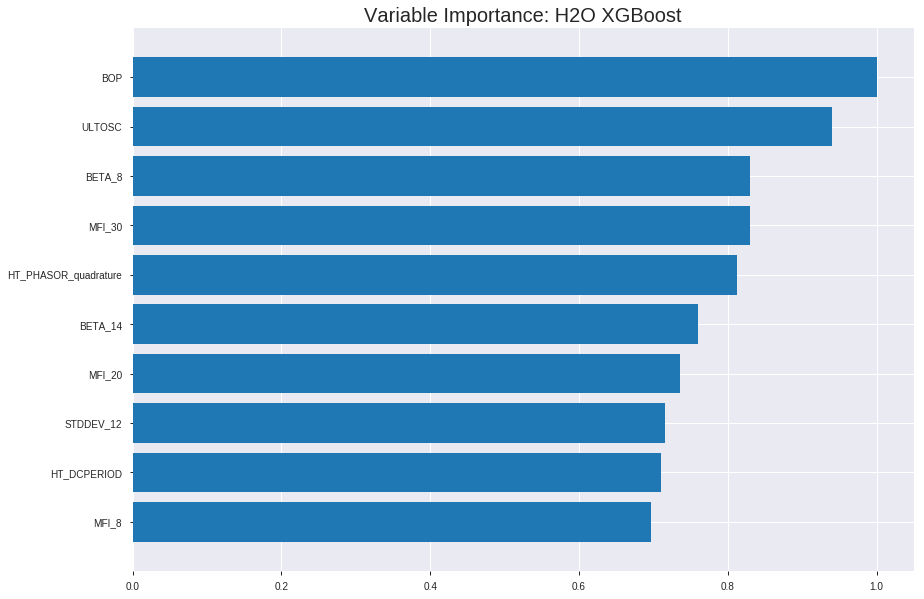

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190824_165355


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17579690298211528
RMSE: 0.41928141263609014
LogLoss: 0.540683544026614
Mean Per-Class Error: 0.12321532314757999
AUC: 0.9511506884751105
pr_auc: 0.9517816118739338
Gini: 0.9023013769502211
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49144261846175563: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1887  292   0.134    (292.0/2179.0)
1      241   1895  0.1128   (241.0/2136.0)
Total  2128  2187  0.1235   (533.0/4315.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491443     0.876706  203
max f2                       0.444657     0.916342  249
max f0point5                 0.53151      0.894425  168
max accuracy                 0.494017     0.876709  201
max precision                0.766584     1         0
max recall                   0.362259     1         330
max specificity              0.766584     1         0
max absolute_mcc             0.492554     0.753554  202
max min_per_class_accuracy   0.49676      0.875     199
max mean_per_class_accuracy  0.492554     0.876785  202

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.75 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010197                    0.723237           2.02013    2.02013            1                0.74121   1                           0.74121             0.0205993       0.0205993                  102.013   102.013
    2        0.0201622                   0.706038           2.02013    2.02013            1                0.714688  1                           0.728101            0.0201311       0.0407303                  102.013   102.013
    3        0.0301275                   0.695574           2.02013    2.02013            1                0.701971  1                           0.719458            0.0201311       0.0608614                  102.013   102.013
    4        0.0400927                   0.684486           2.02013    2.02013            1                0.689839  1                           0.712096            0.0201311       0.0809925                  102.013   102.013
    5        0.0500579                   0.6777             2.02013    2.02013            1                0.680688  1                           0.705844            0.0201311       0.101124                   102.013   102.013
    6        0.100116                    0.648936           2.02013    2.02013            1                0.662641  1                           0.684242            0.101124        0.202247                   102.013   102.013
    7        0.150174                    0.62714            1.98272    2.00766            0.981481         0.638318  0.993827                    0.668934            0.0992509       0.301498                   98.2721   100.766
    8        0.2                         0.609056           1.99194    2.00375            0.986047         0.618184  0.991889                    0.656291            0.0992509       0.400749                   99.1943   100.375
    9        0.300116                    0.570769           1.90323    1.97021            0.94213          0.589724  0.97529                     0.634085            0.190543        0.591292                   90.3225   97.0213
    10       0.4                         0.532342           1.64985    1.89022            0.816705         0.551657  0.935689                    0.613502            0.164794        0.756086                   64.9852   89.0215
    11       0.500116                    0.493865           1.23452    1.75896            0.611111         0.513544  0.870714                    0.593492            0.123596        0.879682                   23.4525   75.8956
    12       0.6                         0.456506           0.703062   1.58318            0.348028         0.475261  0.7837                      0.573809            0.0702247       0.949906                   -29.6938  58.3177
    13       0.699884                    0.421034           0.360905   1.40874            0.178654         0.439386  0.697351                    0.554625            0.0360487       0.985955                   -63.9095  40.874
    14       0.8                         0.387479           0.102877   1.24532            0.0509259        0.404755  0.616454                    0.53587             0.0102996       0.996255                   -89.7123  24.5318
    15       0.899884                    0.349018           0.0374966  1.11125            0.0185615        0.369434  0.55009                     0.517396            0.00374532      1                          -96.2503  11.1254
    16       1                           0.230004           0          1                  0                0.318465  0.495017                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25464416403380213
RMSE: 0.5046227938111815
LogLoss: 0.7030369160758417
Mean Per-Class Error: 0.4709745729189192
AUC: 0.5245449654801398
pr_auc: 0.5479095913754972
Gini: 0.04908993096027969
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24846124649047852: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    587   1        (587.0/587.0)
1      0    646   0        (0.0/646.0)
Total  0    1233  0.4761   (587.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.248461     0.6876     399
max f2                       0.248461     0.846214   399
max f0point5                 0.248461     0.579061   399
max accuracy                 0.450444     0.532036   256
max precision                0.775933     1          0
max recall                   0.248461     1          399
max specificity              0.775933     1          0
max absolute_mcc             0.521564     0.0603672  163
max min_per_class_accuracy   0.491342     0.516184   202
max mean_per_class_accuracy  0.521564     0.529025   163

Gains/Lift Table: Avg response rate: 52.39 %, avg score: 49.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.688923           1.46821   1.46821            0.769231         0.718313  0.769231                    0.718313            0.0154799       0.0154799                  46.8207   46.8207
    2        0.0202758                   0.66896            0.636223  1.06885            0.333333         0.676507  0.56                        0.698246            0.00619195      0.0216718                  -36.3777  6.88545
    3        0.0300081                   0.659763           0.795279  0.980127           0.416667         0.664365  0.513514                    0.687258            0.00773994      0.0294118                  -20.4721  -1.98728
    4        0.0405515                   0.647096           1.46821   1.10703            0.769231         0.653608  0.58                        0.678509            0.0154799       0.0448916                  46.8207   10.7028
    5        0.0502839                   0.641261           1.11339   1.10826            0.583333         0.644273  0.580645                    0.671883            0.0108359       0.0557276                  11.339    10.8259
    6        0.100568                    0.608338           1.20061   1.15444            0.629032         0.62371   0.604839                    0.647796            0.0603715       0.116099                   20.0614   15.4437
    7        0.150041                    0.58395            1.03256   1.11425            0.540984         0.596669  0.583784                    0.630938            0.0510836       0.167183                   3.25585   11.425
    8        0.200324                    0.568329           0.861979  1.05093            0.451613         0.576054  0.550607                    0.617162            0.0433437       0.210526                   -13.8021  5.09269
    9        0.300081                    0.539537           1.03968   1.04719            0.544715         0.554761  0.548649                    0.596418            0.103715        0.314241                   3.96813   4.71885
    10       0.399838                    0.51337            1.07072   1.05306            0.560976         0.525006  0.551724                    0.578601            0.106811        0.421053                   7.07166   5.30586
    11       0.500406                    0.491332           0.954334  1.03322            0.5              0.50208   0.541329                    0.563222            0.0959752       0.517028                   -4.56656  3.32178
    12       0.600162                    0.470095           0.977611  1.02397            0.512195         0.480855  0.536486                    0.549532            0.0975232       0.614551                   -2.23892  2.3975
    13       0.699919                    0.444267           1.02416   1.024              0.536585         0.45688   0.536501                    0.536326            0.102167        0.716718                   2.41637   2.40019
    14       0.799676                    0.415883           0.931058  1.01241            0.487805         0.431383  0.530426                    0.523235            0.0928793       0.809598                   -6.89421  1.24075
    15       0.899432                    0.374975           0.884505  0.998222           0.463415         0.395495  0.522994                    0.509067            0.0882353       0.897833                   -11.5495  -0.17783
    16       1                           0.248461           1.0159    1                  0.532258         0.340913  0.523925                    0.492156         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:53:58  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.504983                         0.5                0.693147              0.5               0                    1                  0.476075
    2019-08-24 16:53:58  0.169 sec   5                  0.489977         0.673269            0.758422        0.747947           1.88239          0.347161                         0.499277           0.691701              0.533501          0.549839             1.46821            0.475264
    2019-08-24 16:53:58  0.325 sec   10                 0.480638         0.655021            0.823703        0.815893           1.97422          0.267439                         0.50092            0.694998              0.504333          0.535208             1.17457            0.476075
    2019-08-24 16:53:58  0.474 sec   15                 0.471866         0.638101            0.859145        0.85716            2.02013          0.222016                         0.500647           0.694467              0.520178          0.545636             1.17457            0.476075
    2019-08-24 16:53:58  0.637 sec   20                 0.463285         0.621741            0.882701        0.881192           2.02013          0.205562                         0.500512           0.6942                0.525563          0.555084             1.61503            0.475264
    2019-08-24 16:53:58  0.795 sec   25                 0.455136         0.606376            0.899251        0.899099           2.02013          0.189571                         0.501216           0.695708              0.529203          0.552017             1.17457            0.476075
    2019-08-24 16:53:59  0.989 sec   30                 0.44758          0.592268            0.913078        0.914153           2.02013          0.178447                         0.502126           0.69758               0.523604          0.548956             1.46821            0.476075
    2019-08-24 16:53:59  1.274 sec   35                 0.439932         0.578104            0.924492        0.9252             2.02013          0.15898                          0.503401           0.700279              0.520115          0.547895             1.61503            0.476075
    2019-08-24 16:53:59  1.447 sec   40                 0.432861         0.565179            0.934635        0.934137           2.02013          0.148783                         0.504518           0.702624              0.515225          0.545044             1.32139            0.476075
    2019-08-24 16:53:59  1.642 sec   45                 0.425805         0.552401            0.944142        0.942316           2.02013          0.131866                         0.504596           0.702842              0.518286          0.545674             1.32139            0.476075
    2019-08-24 16:53:59  1.821 sec   50                 0.419281         0.540684            0.951151        0.951782           2.02013          0.123523                         0.504623           0.703037              0.524545          0.54791              1.46821            0.476075

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  ---------------------
BOP                   474.0838317871094      1.0                  0.03340094135157346
ULTOSC                445.9169921875         0.9405867956023063   0.03141648439597705
BETA_8                393.1786193847656      0.8293440801443007   0.02770087298117443
MFI_30                393.1561584472656      0.8292967025794188   0.027699290525908426
HT_PHASOR_quadrature  385.1120910644531      0.8123290971825219   0.02713255653317003
---                   ---                    ---                  ---
AROONOSC_14           82.58369445800781      0.17419639506941167  0.00581832357536894
ROCP_14               79.95879364013672      0.1686596088685909   0.005633389704199125
AROONOSC_8            69.88592529296875      0.1474125895192973   0.0049237192570176225
aroonup_14            65.00511932373047      0.1371173513314866   0.004579848610106077
ROCR100_8             33.953346252441406     0.0716188656433413   0.0023921375310194627


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.539708265802269)

('F1', 0.6564551422319475)

('auc', 0.5344006309148265)

('logloss', 0.6995310442817048)

('mean_per_class_error', 0.4626288117770767)

('rmse', 0.5028671742904617)

('mse', 0.25287539497887357)

xgboost prediction progress: |████████████████████████████████████████████| 100%


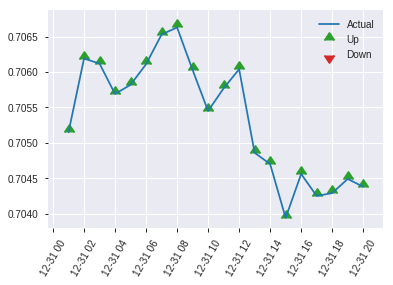


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25287539497887357
RMSE: 0.5028671742904617
LogLoss: 0.6995310442817048
Mean Per-Class Error: 0.4626288117770767
AUC: 0.5344006309148265
pr_auc: 0.501542033701467
Gini: 0.06880126182965296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.299132764339447: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    314  0.9905   (314.0/317.0)
1      0    300  0        (0.0/300.0)
Total  3    614  0.5089   (314.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.299133     0.656455   396
max f2                       0.299133     0.826902   396
max f0point5                 0.395073     0.549919   337
max accuracy                 0.522572     0.539708   151
max precision                0.522572     0.537037   151
max recall                   0.299133     1          396
max specificity              0.764803     0.996845   0
max absolute_mcc             0.447955     0.0821827  267
max min_per_class_accuracy   0.493217     0.53       198
max mean_per_class_accuracy  0.447955     0.537371   267

Gains/Lift Table: Avg response rate: 48.62 %, avg score: 49.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.708945           0.587619  0.587619           0.285714         0.72818   0.285714                    0.72818             0.00666667      0.00666667                 -41.2381  -41.2381
    2        0.0210697                   0.692413           0.342778  0.474615           0.166667         0.701759  0.230769                    0.715986            0.00333333      0.01                       -65.7222  -52.5385
    3        0.0307942                   0.67498            1.71389   0.865965           0.833333         0.683514  0.421053                    0.705731            0.0166667       0.0266667                  71.3889   -13.4035
    4        0.0405186                   0.660105           1.37111   0.9872             0.666667         0.668366  0.48                        0.696764            0.0133333       0.04                       37.1111   -1.28
    5        0.0502431                   0.649034           1.02833   0.995161           0.5              0.65427   0.483871                    0.688539            0.01            0.05                       2.83333   -0.483871
    6        0.100486                    0.602837           1.06151   1.02833            0.516129         0.623122  0.5                         0.65583             0.0533333       0.103333                   6.15054   2.83333
    7        0.150729                    0.580501           1.12785   1.06151            0.548387         0.590325  0.516129                    0.633995            0.0566667       0.16                       12.7849   6.15054
    8        0.200972                    0.56219            0.928817  1.02833            0.451613         0.570929  0.5                         0.618229            0.0466667       0.206667                   -7.11828  2.83333
    9        0.299838                    0.537675           1.21377   1.08948            0.590164         0.548437  0.52973                     0.595216            0.12            0.326667                   21.377    8.94775
    10       0.400324                    0.511125           1.09468   1.09078            0.532258         0.523212  0.530364                    0.577142            0.11            0.436667                   9.46774   9.07827
    11       0.50081                     0.492261           0.928817  1.05828            0.451613         0.502639  0.514563                    0.562194            0.0933333       0.53                       -7.11828  5.82848
    12       0.599676                    0.473065           0.842896  1.02277            0.409836         0.482941  0.497297                    0.549128            0.0833333       0.613333                   -15.7104  2.27748
    13       0.700162                    0.450563           1.19419   1.04738            0.580645         0.463001  0.509259                    0.536767            0.12            0.733333                   19.4194   4.73765
    14       0.799028                    0.42388            0.876612  1.02625            0.42623          0.438305  0.498986                    0.524584            0.0866667       0.82                       -12.3388  2.62475
    15       0.899514                    0.38731            0.961989  1.01907            0.467742         0.40458   0.495495                    0.511178            0.0966667       0.916667                   -3.80108  1.90691
    16       1                           0.284583           0.829301  1                  0.403226         0.353012  0.486224                    0.495285      

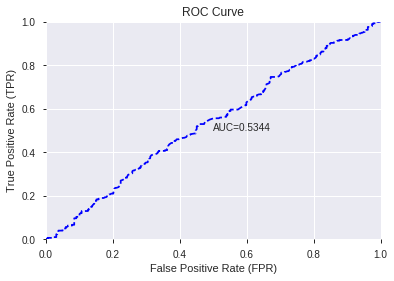

This function is available for GLM models only


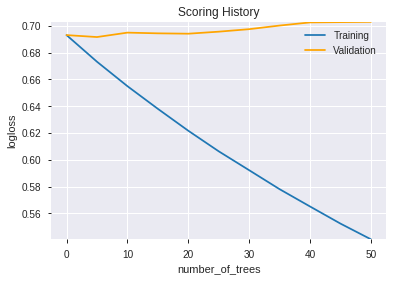

--2019-08-24 16:54:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


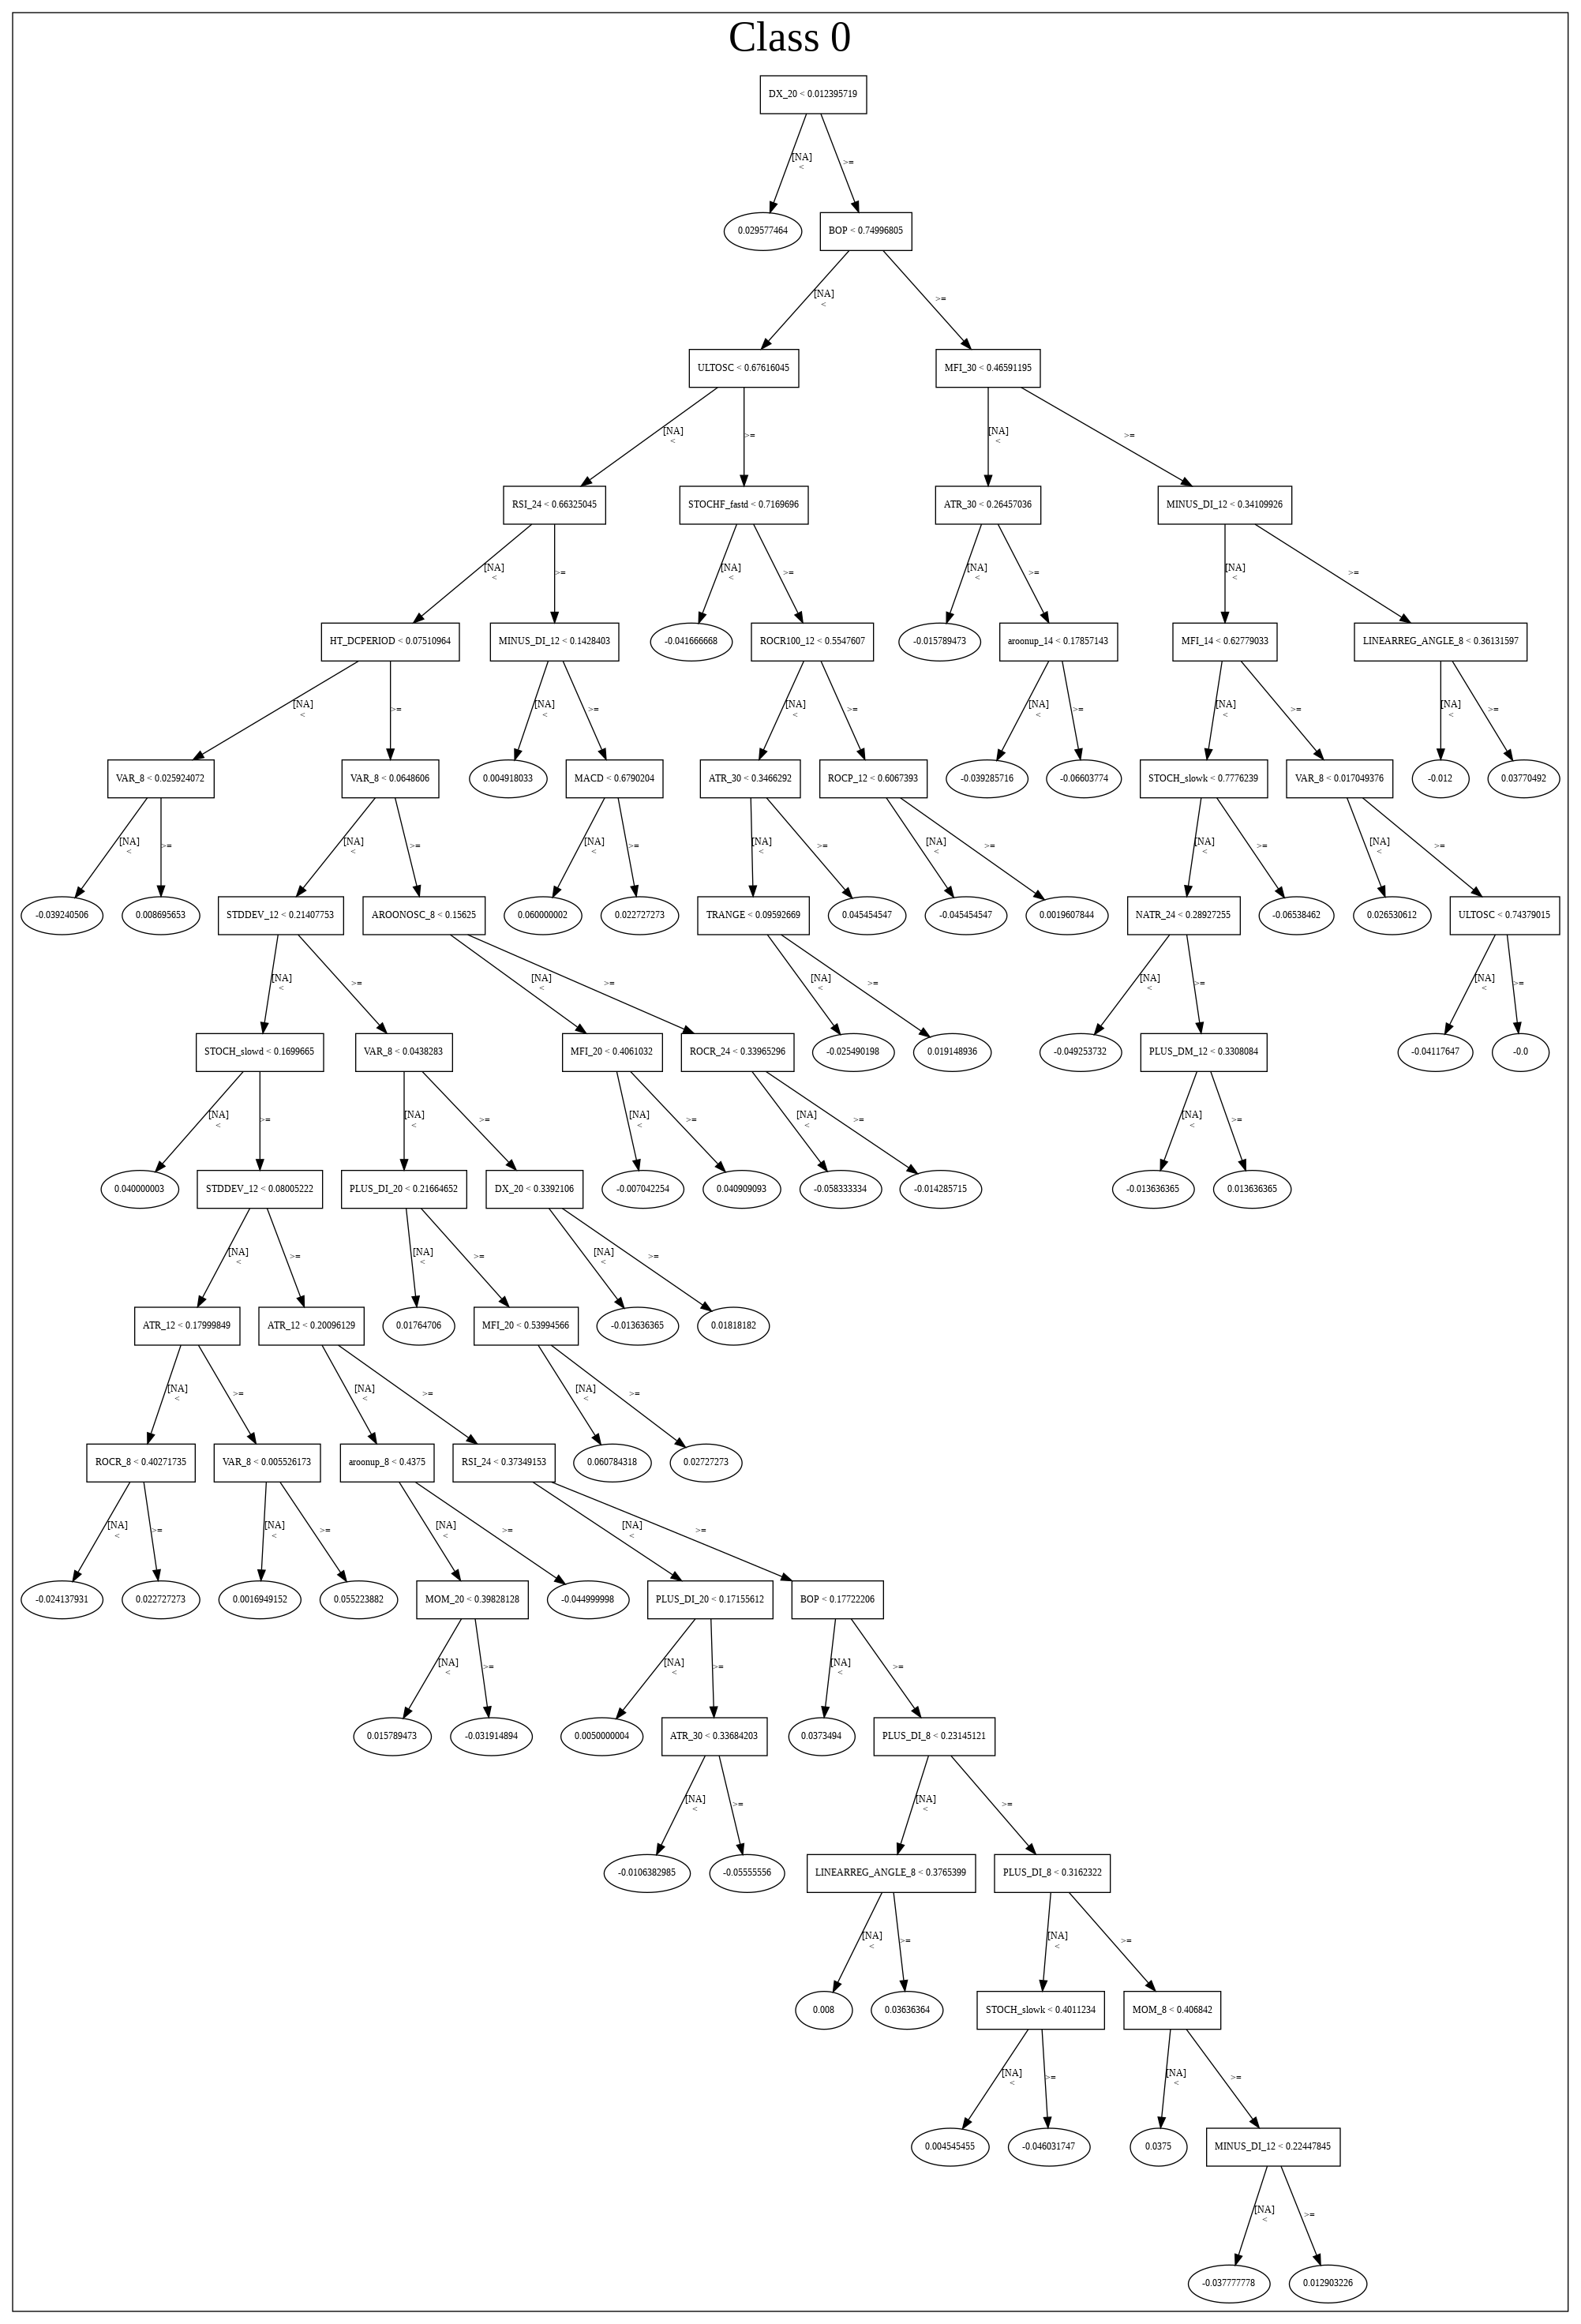

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190824_165355',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190824_165355',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_aebd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_aebd',
   'ty

['BOP',
 'ULTOSC',
 'BETA_8',
 'MFI_30',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'MFI_20',
 'STDDEV_12',
 'HT_DCPERIOD',
 'MFI_8',
 'ATR_30',
 'ADOSC',
 'NATR_24',
 'HT_PHASOR_inphase',
 'MFI_14',
 'WILLR_8',
 'VAR_8',
 'STDDEV_20',
 'PLUS_DI_8',
 'ADXR_8',
 'ROCP_12',
 'ATR_12',
 'PLUS_DI_20',
 'ROC_30',
 'MOM_20',
 'TRANGE',
 'DX_20',
 'MINUS_DI_8',
 'MFI_24',
 'STOCH_slowk',
 'STOCH_slowd',
 'LINEARREG_SLOPE_30',
 'CCI_20',
 'DX_8',
 'LINEARREG_ANGLE_12',
 'RSI_24',
 'LINEARREG_ANGLE_8',
 'CCI_8',
 'STOCHRSI_fastd',
 'ROC_14',
 'RSI_30',
 'PLUS_DM_12',
 'MACD',
 'MOM_8',
 'ROCR_24',
 'ROCR_8',
 'aroondown_24',
 'MINUS_DI_12',
 'CMO_12',
 'aroonup_8',
 'aroonup_12',
 'STOCHF_fastd',
 'ROCR100_12',
 'AROONOSC_14',
 'ROCP_14',
 'AROONOSC_8',
 'aroonup_14',
 'ROCR100_8']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.545
GLM             0.543
XGBoost         0.551
dtype: float64

DeepLearning    GLM  XGBoost
All          0.532  0.535    0.546
DLF          0.545  0.543    0.551
Fwe          0.525  0.525    0.541
RFE          0.535  0.533    0.540
XGBF         0.535  0.543    0.551





F1


DeepLearning    0.659
GLM             0.661
XGBoost         0.656
dtype: float64

DeepLearning    GLM  XGBoost
All          0.656  0.658    0.656
DLF          0.659  0.656    0.656
Fwe          0.656  0.656    0.654
RFE          0.658  0.661    0.656
XGBF         0.656  0.656    0.656





auc


DeepLearning    0.533
GLM             0.529
XGBoost         0.547
dtype: float64

DeepLearning    GLM  XGBoost
All          0.518  0.528    0.547
DLF          0.533  0.504    0.537
Fwe          0.519  0.519    0.529
RFE          0.527  0.529    0.534
XGBF         0.508  0.504    0.537





logloss


DeepLearning    0.901
GLM             0.692
XGBoost         0.700
dtype: float64

DeepLearning    GLM  XGBoost
All          0.901  0.691    0.698
DLF          0.721  0.692    0.696
Fwe          0.693  0.692    0.698
RFE          0.697  0.692    0.700
XGBF         0.708  0.692    0.696





mean_per_class_error


DeepLearning    0.475
GLM             0.473
XGBoost         0.463
dtype: float64

DeepLearning    GLM  XGBoost
All          0.467  0.463    0.448
DLF          0.463  0.465    0.445
Fwe          0.473  0.473    0.460
RFE          0.462  0.460    0.463
XGBF         0.475  0.465    0.445





rmse


DeepLearning    0.555
GLM             0.500
XGBoost         0.503
dtype: float64

DeepLearning    GLM  XGBoost
All          0.555  0.499    0.502
DLF          0.509  0.500    0.501
Fwe          0.500  0.500    0.502
RFE          0.502  0.499    0.503
XGBF         0.506  0.500    0.501





mse


DeepLearning    0.308
GLM             0.250
XGBoost         0.253
dtype: float64

DeepLearning    GLM  XGBoost
All          0.308  0.249    0.252
DLF          0.259  0.250    0.251
Fwe          0.250  0.250    0.252
RFE          0.252  0.249    0.253
XGBF         0.256  0.250    0.251

{'F1':       DeepLearning    GLM  XGBoost
 All          0.656    NaN      NaN
 DLF          0.659    NaN      NaN
 DLF            NaN  0.656      NaN
 DLF            NaN    NaN    0.656
 All            NaN  0.658      NaN
 All            NaN    NaN    0.656
 XGBF         0.656    NaN      NaN
 XGBF           NaN  0.656      NaN
 XGBF           NaN    NaN    0.656
 Fwe          0.656    NaN      NaN
 Fwe            NaN  0.656      NaN
 Fwe            NaN    NaN    0.654
 RFE          0.658    NaN      NaN
 RFE            NaN  0.661      NaN
 RFE            NaN    NaN    0.656,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.532    NaN      NaN
 DLF          0.545    NaN      NaN
 DLF            NaN  0.543      NaN
 DLF            NaN    NaN    0.551
 All            NaN  0.535      NaN
 All            NaN    NaN    0.546
 XGBF         0.535    NaN      NaN
 XGBF           NaN  0.543      NaN
 XGBF           NaN    NaN    0.551
 Fwe          0.525    NaN      NaN
 Fwe     